In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

# Import the libraries

In [2]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, LeakyReLU, Flatten, GRU
import time
import datetime

from tensorflow.keras.layers import Lambda

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr

In [3]:
def plot_dataframe(df):
  for column_name in df.columns:
    plt.figure()
    plt.title(column_name)
    plt.plot(df[column_name])

# Preprocessing

In [4]:
def add_Ma(df, window=5):
    for i in range(window, df.shape[0]):
        sum = 0.0
        for k in range(1, window+1):
            sum += df.iloc[i-k, 4]
        df.loc[df.index[i], 'Ma'] = np.round(sum/window, 6)
    return df[window:]

In [5]:
class Standarized_TimeseriesGenerator(tf.keras.preprocessing.sequence.TimeseriesGenerator):
  def __getitem__(self, index):
    samples, targets  = super(Standarized_TimeseriesGenerator, self).__getitem__(index)
    mean = samples.mean(axis=1)
    std = samples.std(axis=1)
    samples = (samples - mean[:,None,:])/std[:,None,:]
    targets = (targets - mean)/std
    return samples, targets

In [6]:
def get_gen_train_test(dataframe, n_sequence, n_batch):
    data = dataframe.drop(columns='Date').to_numpy()
    targets = data
    n_samples = data.shape[0]
    train_test_split=int(n_samples*0.9)

    data_gen_train = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = 0,
                                end_index = train_test_split,
                                shuffle = True)
    data_gen_test = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = train_test_split,
                                end_index = n_samples-1)

    return data_gen_train, data_gen_test

# Baseline

In [7]:
def mean_squared_error(X, lenght = 5):
    squared_error = 0
    for i in range(0, X.shape[0] - lenght):
        x = X[i:i+lenght]
        mean = x.mean()
        std = x.std()
        x = (x - mean)/std
        y = (X[i+lenght] - mean)/std
        squared_error += np.square(x[-1]-y)
    return squared_error/X.shape[0]

In [8]:
# For generated data
def mean_squared_error(dataset):
    mse=0
    for X_batch, y_batch in dataset:
        mse += np.mean(np.square(X_batch[:, -1, 3:4]-y_batch[:, 3:4]))
    mse /= len(dataset)
    return mse

# Utilities

In [9]:
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3]))
def mae(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])))
    # ***The absolute is over the whole thing as y_true can be negative
def mape(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])/y_true[:,3]))
    # ***The absolute is over the whole thing as y_true can be negative
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3])))
def ar(y_true, y_pred):
    mask = tf.cast(y_pred[1:,3] > y_true[:-1,3],tf.float32)
    return tf.reduce_mean((y_true[1:,3]-y_true[:-1,3])*mask)

# GAN

## Perdidas

In [10]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(x, y, fake_output):
    a1=0.01
    g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
    g_mse = tf.keras.losses.MSE(x, y)
    return a1*g_mse + (1-a1)*g_loss, g_mse

## Generator

In [11]:
def make_generator_model(n_sequence, n_features):
    inputs = Input(shape=(n_sequence, n_features,))
    gru_1 = GRU(units=10, return_sequences=True, activation=None, kernel_initializer='random_normal')(inputs)
    batch_norm1 = tf.keras.layers.BatchNormalization()(gru_1)
    gru_1_LRelu = LeakyReLU(alpha=0.3)(batch_norm1) 
    gru_1_dropout = Dropout(0.3)(gru_1_LRelu)
    gru_2 = GRU(units=10, return_sequences=False, activation=None, kernel_initializer='random_normal')(gru_1_dropout)
    batch_norm2 = tf.keras.layers.BatchNormalization()(gru_2)
    gru_2_LRelu = LeakyReLU(alpha=0.3)(batch_norm2) 
    gru_2_dropout = Dropout(0.3)(gru_2_LRelu)
    output_dense = Dense(n_features, activation=None)(gru_2_dropout)
    output = LeakyReLU(alpha=0.3)(output_dense) 

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss=None, metrics=[mse, mae, mape, rmse, ar])
    model.summary()

    return model

## Discriminator

In [12]:
def make_discriminator_model(n_features):
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(units=72, input_shape=((n_sequence+1) * n_features,), activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(tf.keras.layers.GaussianNoise(stddev=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(units=100, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(units=10, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(1 ,activation='sigmoid'))
    model.compile(loss=discriminator_loss)
    return model

# Training

In [13]:
def train_step_def(sequences, sequences_end):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_prediction = generator(sequences, training=True)

        sequences_true = tf.concat((sequences, sequences_end[:, None, :]), axis=1)
        sequences_fake = tf.concat((sequences, generated_prediction[:, None, :]), axis=1)

        real_output = discriminator(sequences_true, training=True)
        fake_output = discriminator(sequences_fake, training=True)

        gen_loss, gen_mse_loss = generator_loss(generated_prediction, 
                                                sequences_end, 
                                                fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

def test_step_def(sequences, sequences_end):
    generated_prediction = generator(sequences, training=False)

    sequences_true = tf.concat((sequences, sequences_end[:,None,:]), axis=1)
    sequences_fake = tf.concat((sequences, generated_prediction[:,None,:]), axis=1)

    real_output = discriminator(sequences_true, training=False)
    fake_output = discriminator(sequences_fake, training=False)

    gen_loss, gen_mse_loss = generator_loss(generated_prediction, sequences_end, fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

In [14]:
def train(dataset, dataset_val, epochs):
    history = np.empty(shape = (8, epochs))
    history_val = np.empty(shape = (8, epochs))
    len_dataset = len(dataset)
    len_dataset_val = len(dataset_val)
    for epoch in range(epochs):
        start = time.time()

        cur_dis_loss = 0
        cur_gen_loss = 0
        cur_gen_mse_loss = 0
        for sequence_batch, sequence_end_batch in dataset:
            aux_cur_losses = train_step(tf.cast(sequence_batch, tf.float32), 
                                      tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss += aux_cur_losses[0]/len_dataset
            cur_dis_loss += aux_cur_losses[1]/len_dataset
            cur_gen_mse_loss += aux_cur_losses[2]/len_dataset
        cur_gen_metrics = generator.evaluate(dataset,verbose=False)[1:]

        history[:, epoch] = cur_gen_loss, cur_dis_loss, cur_gen_mse_loss, *cur_gen_metrics

        cur_gen_metrics_val = generator.evaluate(dataset_val,verbose=False)[1: ]

        cur_gen_loss_val = 0
        cur_dis_loss_val = 0
        cur_gen_mse_loss_val = 0
        for sequence_batch, sequence_end_batch in dataset_val:
            aux_cur_losses_val = test_step(tf.cast(sequence_batch, tf.float32), 
                                         tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss_val += aux_cur_losses_val[0]/len_dataset_val
            cur_dis_loss_val += aux_cur_losses_val[1]/len_dataset_val
            cur_gen_mse_loss_val += aux_cur_losses_val[2]/len_dataset_val
    


        history_val[:, epoch] = cur_gen_loss_val, cur_dis_loss_val, cur_gen_mse_loss_val, *cur_gen_metrics_val

        print ('Time for epoch {} is {} sec Generator Loss: {},  Discriminator_loss: {}'
               .format(epoch + 1, time.time()-start, cur_gen_loss, cur_dis_loss))

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

    return history, history_val

## Visualization

In [15]:
def plot_history(history, history_val):
    metrics = ["gen_loss","dis_loss","gen_mse_loss", 'mse','mae','mape','rmse','ar']
    for i, metric_name in enumerate(metrics):  
        plt.figure()
        plt.title(metric_name)
        plt.plot(history[i], label='train')
        plt.plot(history_val[i], label='test')
        plt.legend()
    plt.show()

In [16]:
def plot_frame(sequence, target, model):
    y_pred = model.predict(sequence)[...,3]
    y_true = target[...,3]

    plt.figure()
    plt.title("closing price")
    plt.plot(y_true, label="true")
    plt.plot(y_pred, label="prediction")
    plt.legend()
    plt.show()

In [17]:
def get_best_results(history):
    min_index = np.argmin(history[3, :])
    return history[:, min_index]

## Variables

In [18]:
window = 5
n_sequence = window
n_features = 7
n_batch = 50

## Data loading

In [19]:
stock_code = "AMZN"
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2020, 12, 31)
raw_data = pdr.get_data_yahoo(stock_code, start, end,threads=False, proxy="http://127.0.0.1:7890")
df = raw_data.dropna();
df = df.reset_index(level=0)
df = add_Ma(df, window)
df

[*********************100%***********************]  1 of 1 completed


Date        Open        High         Low       Close   Adj Close  \
5    2000-01-10    3.628125    3.631250    3.278125    3.459375    3.459375   
6    2000-01-11    3.343750    3.500000    3.250000    3.337500    3.337500   
7    2000-01-12    3.393750    3.400000    3.150000    3.178125    3.178125   
8    2000-01-13    3.246875    3.359375    3.156250    3.296875    3.296875   
9    2000-01-14    3.337500    3.431250    3.200000    3.212500    3.212500   
...         ...         ...         ...         ...         ...         ...   
5278 2020-12-23  160.250000  160.506500  159.208496  159.263504  159.263504   
5279 2020-12-24  159.695007  160.100006  158.449997  158.634506  158.634506   
5280 2020-12-28  159.699997  165.199997  158.634506  164.197998  164.197998   
5281 2020-12-29  165.496994  167.532501  164.061005  166.100006  166.100006   
5282 2020-12-30  167.050003  167.104996  164.123505  164.292496  164.292496   

         Volume          Ma  
5     295158000    3.761875  
6     210654000    3.560000  
7     216090000    3.408125  
8     208962000    3.346250  
9     137072000    3.350000  
...         ...         ...  
5278   41876000  160.913904  
5279   29038000  160.357004  
5280  113736000  159.723105  
5281   97458000  160.546204  
5282   64186000  161.704404  

[5278 rows x 8 columns]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 gru (GRU)                   (None, 5, 10)             570       
                                                                 
 batch_normalization (BatchN  (None, 5, 10)            40        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 5, 10)             0         
                                                                 
 dropout (Dropout)           (None, 5, 10)             0         
                                                                 
 gru_1 (GRU)                 (None, 10)                660       
                                                             

Time for epoch 54 is 0.745553731918335 sec Generator Loss: 1.0090779066085815,  Discriminator_loss: 1.2084332704544067
Time for epoch 55 is 0.7381796836853027 sec Generator Loss: 1.0075494050979614,  Discriminator_loss: 1.2281019687652588
Time for epoch 56 is 0.7569489479064941 sec Generator Loss: 0.9929617643356323,  Discriminator_loss: 1.2222208976745605
Time for epoch 57 is 0.7615673542022705 sec Generator Loss: 0.9891884326934814,  Discriminator_loss: 1.2385892868041992
Time for epoch 58 is 0.8394842147827148 sec Generator Loss: 0.9566843509674072,  Discriminator_loss: 1.2566826343536377
Time for epoch 59 is 0.7268002033233643 sec Generator Loss: 0.9796397686004639,  Discriminator_loss: 1.2509220838546753
Time for epoch 60 is 0.7868072986602783 sec Generator Loss: 0.9588593244552612,  Discriminator_loss: 1.2513172626495361
Time for epoch 61 is 0.8572189807891846 sec Generator Loss: 0.9719570279121399,  Discriminator_loss: 1.2390508651733398
Time for epoch 62 is 0.8567204475402832 s

Time for epoch 123 is 0.7708392143249512 sec Generator Loss: 0.9045453667640686,  Discriminator_loss: 1.2944248914718628
Time for epoch 124 is 0.817455530166626 sec Generator Loss: 0.8828837871551514,  Discriminator_loss: 1.293123483657837
Time for epoch 125 is 0.8057525157928467 sec Generator Loss: 0.8969128131866455,  Discriminator_loss: 1.2874407768249512
Time for epoch 126 is 0.8453884124755859 sec Generator Loss: 0.9111637473106384,  Discriminator_loss: 1.290224313735962
Time for epoch 127 is 0.794529914855957 sec Generator Loss: 0.9132838249206543,  Discriminator_loss: 1.2853689193725586
Time for epoch 128 is 0.8100252151489258 sec Generator Loss: 0.9060323238372803,  Discriminator_loss: 1.2879055738449097
Time for epoch 129 is 0.8316657543182373 sec Generator Loss: 0.8903430104255676,  Discriminator_loss: 1.2963961362838745
Time for epoch 130 is 0.9606287479400635 sec Generator Loss: 0.8972640037536621,  Discriminator_loss: 1.2964149713516235
Time for epoch 131 is 0.836662292480

Time for epoch 192 is 0.8624486923217773 sec Generator Loss: 0.9024602770805359,  Discriminator_loss: 1.2852931022644043
Time for epoch 193 is 0.8430373668670654 sec Generator Loss: 0.8850188255310059,  Discriminator_loss: 1.2895960807800293
Time for epoch 194 is 0.8474524021148682 sec Generator Loss: 0.8927563428878784,  Discriminator_loss: 1.2950102090835571
Time for epoch 195 is 0.8556060791015625 sec Generator Loss: 0.8977726101875305,  Discriminator_loss: 1.2899763584136963
Time for epoch 196 is 0.8554258346557617 sec Generator Loss: 0.9003579020500183,  Discriminator_loss: 1.287921667098999
Time for epoch 197 is 0.8834648132324219 sec Generator Loss: 0.8969220519065857,  Discriminator_loss: 1.2895598411560059
Time for epoch 198 is 0.8604598045349121 sec Generator Loss: 0.9157535433769226,  Discriminator_loss: 1.2803822755813599
Time for epoch 199 is 0.860196590423584 sec Generator Loss: 0.9135212898254395,  Discriminator_loss: 1.2812190055847168
Time for epoch 200 is 0.8335120677

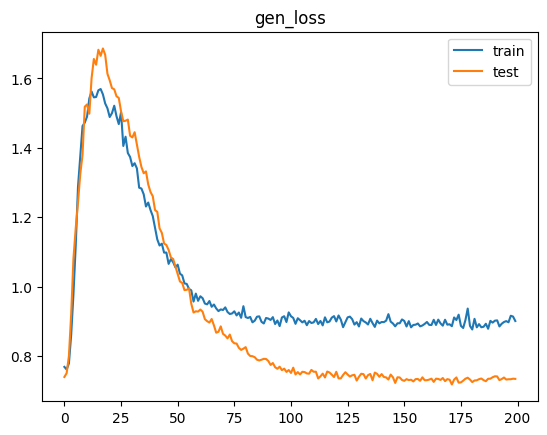

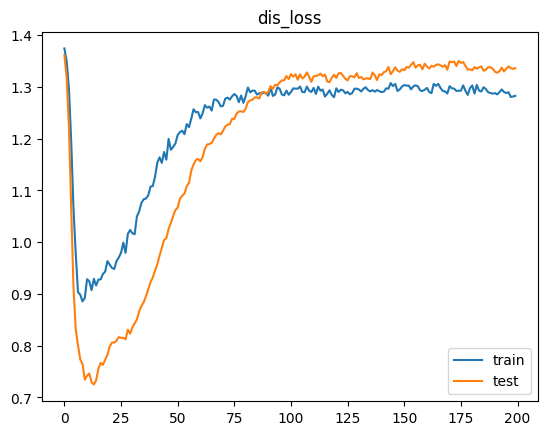

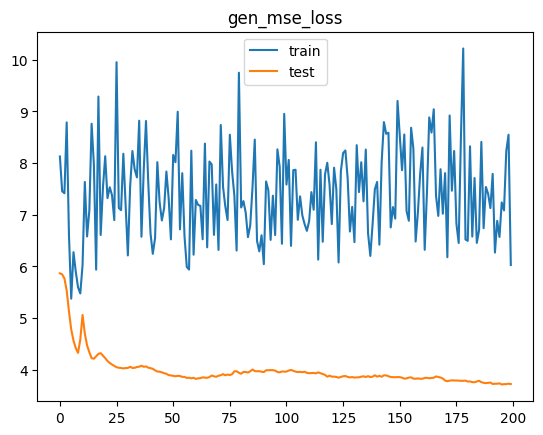

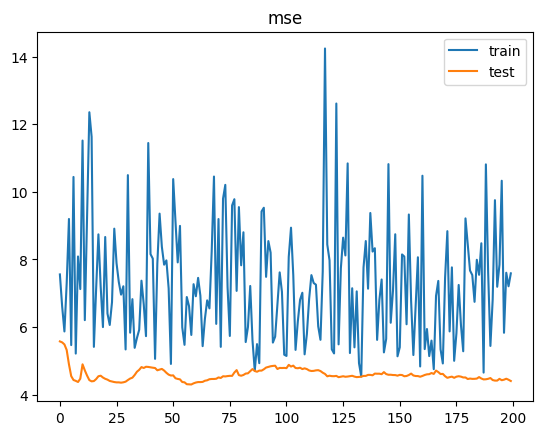

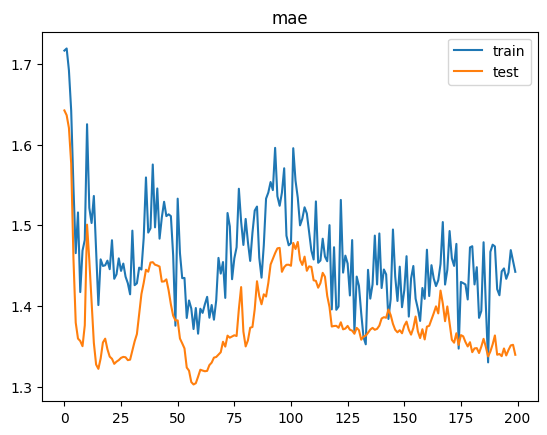

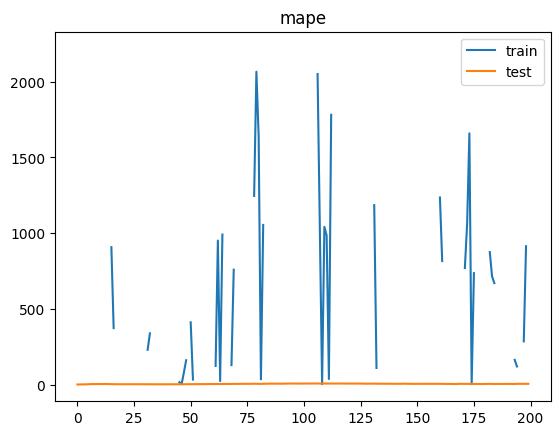

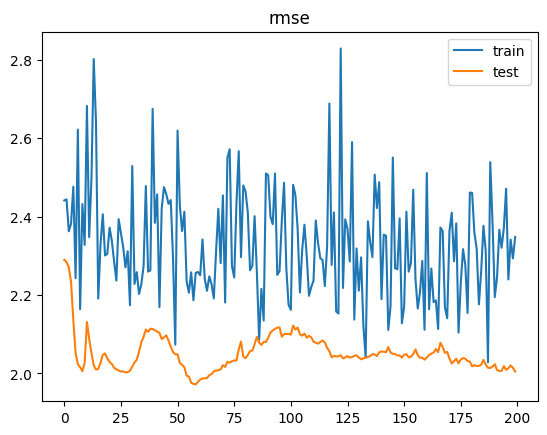

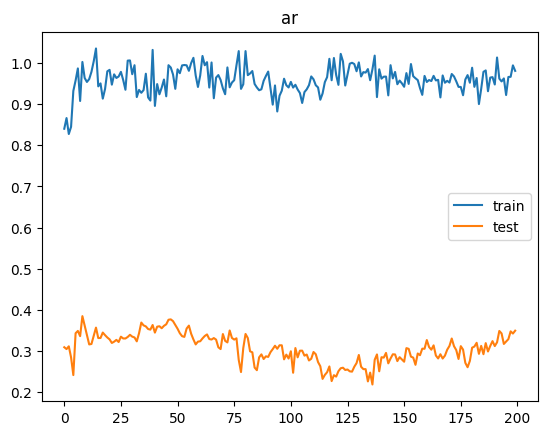

2/2 [==============================] - 0s 4ms/step


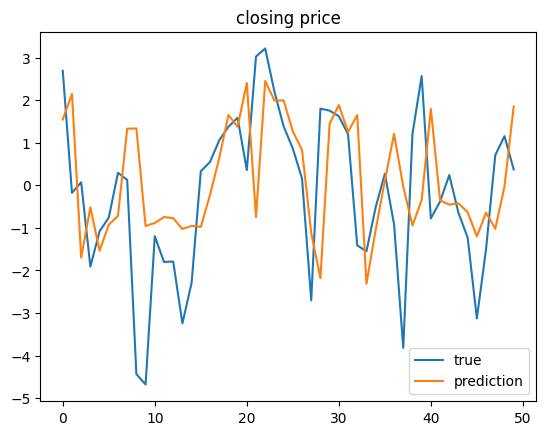

[MSE Baseline] train: 9.652437534418517  test: 4.137918162168212
Delta time with epochs = 200: 0:02:55.579565
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 gru_2 (GRU)                 (None, 5, 10)             570       
                                                                 
 batch_normalization_2 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 5, 10)             0         
                                                                 
 dropout_5 (Dropout)         (None, 5, 10)             0         
                                                                 
 gru_3 (GRU)   

Time for epoch 53 is 0.8658649921417236 sec Generator Loss: 0.9877123832702637,  Discriminator_loss: 1.2321141958236694
Time for epoch 54 is 0.8613970279693604 sec Generator Loss: 0.9902415871620178,  Discriminator_loss: 1.2399463653564453
Time for epoch 55 is 0.8486030101776123 sec Generator Loss: 0.9911406636238098,  Discriminator_loss: 1.2351875305175781
Time for epoch 56 is 0.8501319885253906 sec Generator Loss: 0.9736279249191284,  Discriminator_loss: 1.2318308353424072
Time for epoch 57 is 0.8801431655883789 sec Generator Loss: 0.9811075329780579,  Discriminator_loss: 1.2480144500732422
Time for epoch 58 is 0.8703923225402832 sec Generator Loss: 0.980853796005249,  Discriminator_loss: 1.2432805299758911
Time for epoch 59 is 0.8446433544158936 sec Generator Loss: 0.9722049236297607,  Discriminator_loss: 1.2509515285491943
Time for epoch 60 is 0.8473711013793945 sec Generator Loss: 0.9652778506278992,  Discriminator_loss: 1.252431035041809
Time for epoch 61 is 0.8393640518188477 se

Time for epoch 122 is 0.8844265937805176 sec Generator Loss: 0.8851902484893799,  Discriminator_loss: 1.3000746965408325
Time for epoch 123 is 0.8412196636199951 sec Generator Loss: 0.8881716728210449,  Discriminator_loss: 1.292102575302124
Time for epoch 124 is 0.8413724899291992 sec Generator Loss: 0.8912433981895447,  Discriminator_loss: 1.2960662841796875
Time for epoch 125 is 0.8775894641876221 sec Generator Loss: 0.897484302520752,  Discriminator_loss: 1.2875343561172485
Time for epoch 126 is 0.854482889175415 sec Generator Loss: 0.9000769853591919,  Discriminator_loss: 1.2950156927108765
Time for epoch 127 is 0.8536176681518555 sec Generator Loss: 0.8832273483276367,  Discriminator_loss: 1.2917366027832031
Time for epoch 128 is 0.8351113796234131 sec Generator Loss: 0.8955893516540527,  Discriminator_loss: 1.2954295873641968
Time for epoch 129 is 0.8452422618865967 sec Generator Loss: 0.9088277816772461,  Discriminator_loss: 1.2861130237579346
Time for epoch 130 is 0.84580206871

Time for epoch 191 is 0.8744215965270996 sec Generator Loss: 0.8939563632011414,  Discriminator_loss: 1.283690333366394
Time for epoch 192 is 0.777641773223877 sec Generator Loss: 0.8912363648414612,  Discriminator_loss: 1.2943676710128784
Time for epoch 193 is 0.7655501365661621 sec Generator Loss: 0.8722086548805237,  Discriminator_loss: 1.2926889657974243
Time for epoch 194 is 0.7597830295562744 sec Generator Loss: 0.8952673077583313,  Discriminator_loss: 1.28390371799469
Time for epoch 195 is 0.762507438659668 sec Generator Loss: 0.9022616744041443,  Discriminator_loss: 1.2900159358978271
Time for epoch 196 is 0.8442773818969727 sec Generator Loss: 0.8984826803207397,  Discriminator_loss: 1.2943894863128662
Time for epoch 197 is 0.8365342617034912 sec Generator Loss: 0.8933255672454834,  Discriminator_loss: 1.2939016819000244
Time for epoch 198 is 0.7471930980682373 sec Generator Loss: 0.9029767513275146,  Discriminator_loss: 1.2900243997573853
Time for epoch 199 is 0.7576735019683

Time for epoch 260 is 0.7607066631317139 sec Generator Loss: 0.8973637819290161,  Discriminator_loss: 1.2853055000305176
Time for epoch 261 is 0.7602694034576416 sec Generator Loss: 0.877993643283844,  Discriminator_loss: 1.285646677017212
Time for epoch 262 is 0.7763605117797852 sec Generator Loss: 0.8944942951202393,  Discriminator_loss: 1.276724934577942
Time for epoch 263 is 0.758908748626709 sec Generator Loss: 0.9218016266822815,  Discriminator_loss: 1.2771821022033691
Time for epoch 264 is 0.8119478225708008 sec Generator Loss: 0.9069674611091614,  Discriminator_loss: 1.2818591594696045
Time for epoch 265 is 0.7747008800506592 sec Generator Loss: 0.9222949147224426,  Discriminator_loss: 1.280886173248291
Time for epoch 266 is 0.7614257335662842 sec Generator Loss: 0.9093552827835083,  Discriminator_loss: 1.2824093103408813
Time for epoch 267 is 0.7587003707885742 sec Generator Loss: 0.9179746508598328,  Discriminator_loss: 1.281684160232544
Time for epoch 268 is 0.80485939979553

Time for epoch 328 is 0.8671488761901855 sec Generator Loss: 0.9067010283470154,  Discriminator_loss: 1.2696056365966797
Time for epoch 329 is 0.8492753505706787 sec Generator Loss: 0.9150776863098145,  Discriminator_loss: 1.265752911567688
Time for epoch 330 is 0.9087569713592529 sec Generator Loss: 0.9278172850608826,  Discriminator_loss: 1.2615333795547485
Time for epoch 331 is 0.8853228092193604 sec Generator Loss: 0.9336602687835693,  Discriminator_loss: 1.2734324932098389
Time for epoch 332 is 0.849017858505249 sec Generator Loss: 0.9267514944076538,  Discriminator_loss: 1.2556450366973877
Time for epoch 333 is 0.8945751190185547 sec Generator Loss: 0.923765242099762,  Discriminator_loss: 1.2720924615859985
Time for epoch 334 is 0.8891284465789795 sec Generator Loss: 0.9335450530052185,  Discriminator_loss: 1.2712994813919067
Time for epoch 335 is 0.8667657375335693 sec Generator Loss: 0.9348020553588867,  Discriminator_loss: 1.2678738832473755
Time for epoch 336 is 0.85162663459

Time for epoch 396 is 0.8948311805725098 sec Generator Loss: 0.9307084083557129,  Discriminator_loss: 1.2764273881912231
Time for epoch 397 is 0.8861391544342041 sec Generator Loss: 0.9260722398757935,  Discriminator_loss: 1.2649245262145996
Time for epoch 398 is 0.9292275905609131 sec Generator Loss: 0.9359467625617981,  Discriminator_loss: 1.2564222812652588
Time for epoch 399 is 0.9070134162902832 sec Generator Loss: 0.9517358541488647,  Discriminator_loss: 1.2559787034988403
Time for epoch 400 is 1.0638175010681152 sec Generator Loss: 0.9427074193954468,  Discriminator_loss: 1.2461413145065308
Time for epoch 401 is 0.9137582778930664 sec Generator Loss: 0.933422327041626,  Discriminator_loss: 1.2639285326004028
Time for epoch 402 is 0.9100837707519531 sec Generator Loss: 0.9499712586402893,  Discriminator_loss: 1.26494300365448
Time for epoch 403 is 0.9240069389343262 sec Generator Loss: 0.9356143474578857,  Discriminator_loss: 1.2571113109588623
Time for epoch 404 is 0.76343083381

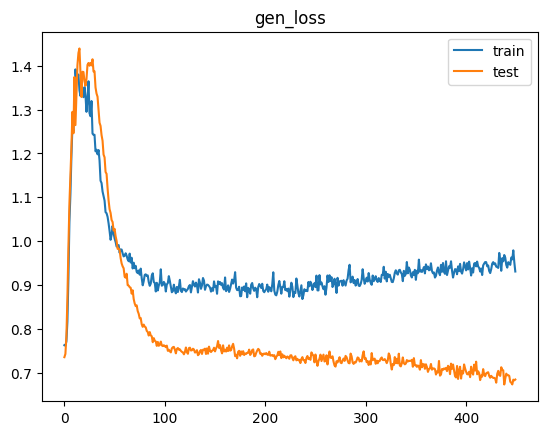

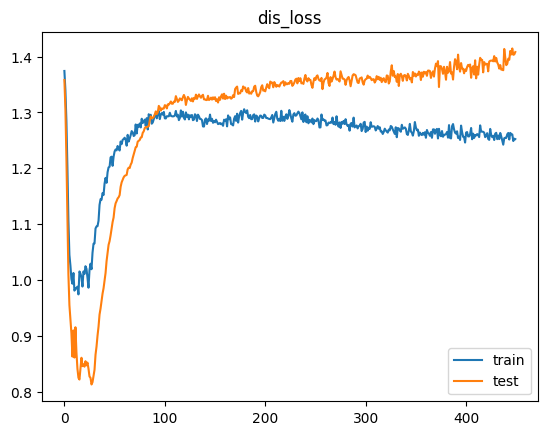

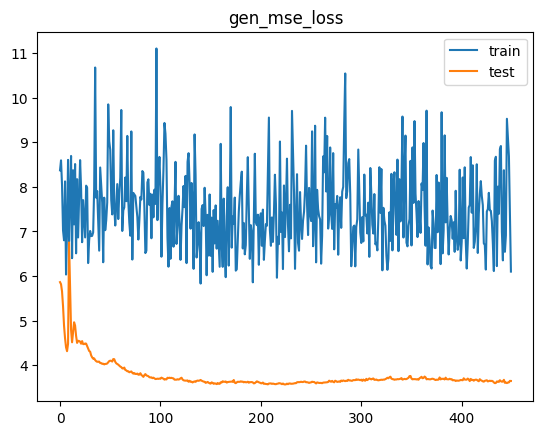

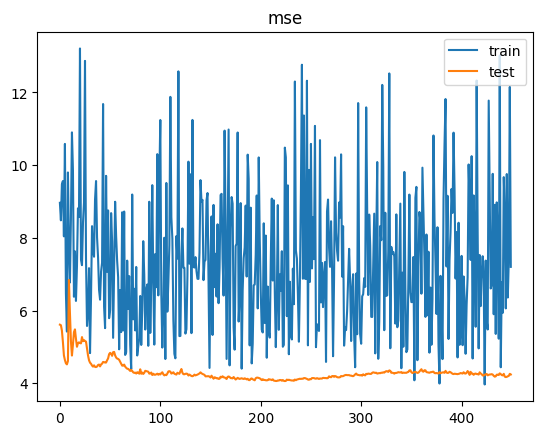

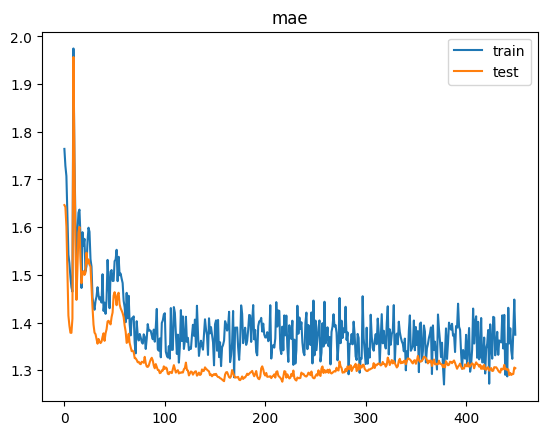

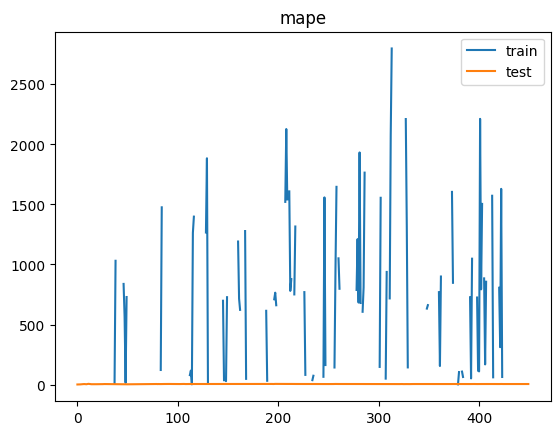

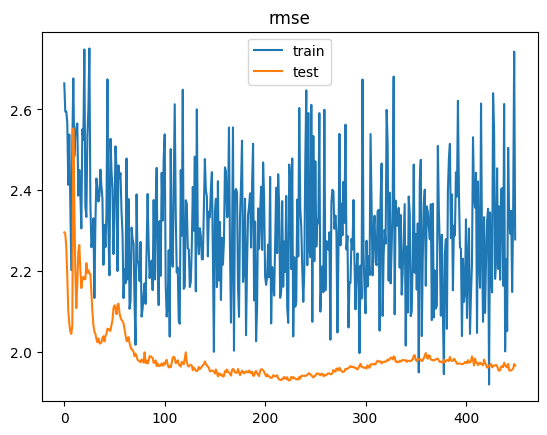

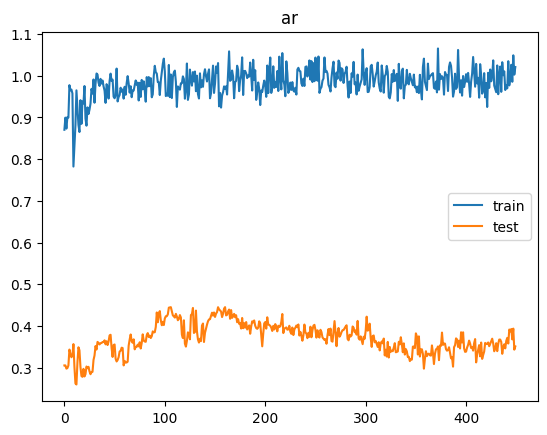

2/2 [==============================] - 0s 4ms/step


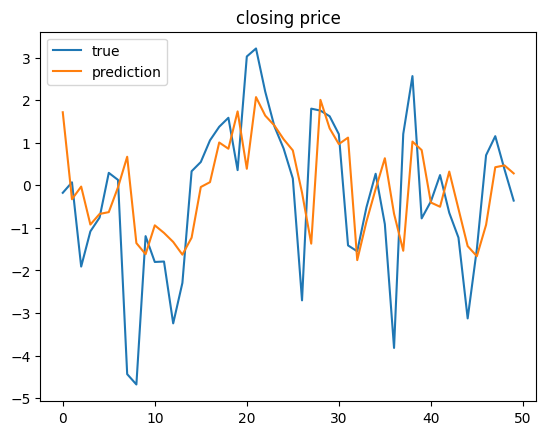

[MSE Baseline] train: 8.157539546634203  test: 4.1521541466081695
Delta time with epochs = 450: 0:06:41.703301
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 gru_4 (GRU)                 (None, 5, 10)             570       
                                                                 
 batch_normalization_4 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_10 (Dropout)        (None, 5, 10)             0         
                                                                 
 gru_5 (GRU)  

Time for epoch 52 is 0.9327297210693359 sec Generator Loss: 0.9656515717506409,  Discriminator_loss: 1.2306926250457764
Time for epoch 53 is 0.9170300960540771 sec Generator Loss: 0.9416756629943848,  Discriminator_loss: 1.253237247467041
Time for epoch 54 is 0.9081470966339111 sec Generator Loss: 0.9419183731079102,  Discriminator_loss: 1.249559760093689
Time for epoch 55 is 0.8920023441314697 sec Generator Loss: 0.9514952301979065,  Discriminator_loss: 1.2573676109313965
Time for epoch 56 is 0.9060723781585693 sec Generator Loss: 0.9409846067428589,  Discriminator_loss: 1.2525686025619507
Time for epoch 57 is 0.8973309993743896 sec Generator Loss: 0.9292876124382019,  Discriminator_loss: 1.2716310024261475
Time for epoch 58 is 1.0008022785186768 sec Generator Loss: 0.9431925415992737,  Discriminator_loss: 1.2491984367370605
Time for epoch 59 is 0.9000747203826904 sec Generator Loss: 0.9363839626312256,  Discriminator_loss: 1.2499465942382812
Time for epoch 60 is 0.9000506401062012 se

Time for epoch 121 is 0.8471405506134033 sec Generator Loss: 0.916479766368866,  Discriminator_loss: 1.2787538766860962
Time for epoch 122 is 0.8536117076873779 sec Generator Loss: 0.9016720056533813,  Discriminator_loss: 1.2912214994430542
Time for epoch 123 is 0.8604488372802734 sec Generator Loss: 0.9057741165161133,  Discriminator_loss: 1.2772598266601562
Time for epoch 124 is 0.832965612411499 sec Generator Loss: 0.8974528312683105,  Discriminator_loss: 1.2824304103851318
Time for epoch 125 is 0.8860855102539062 sec Generator Loss: 0.920222818851471,  Discriminator_loss: 1.2715587615966797
Time for epoch 126 is 0.8459348678588867 sec Generator Loss: 0.909580647945404,  Discriminator_loss: 1.272760272026062
Time for epoch 127 is 0.8342654705047607 sec Generator Loss: 0.9235038757324219,  Discriminator_loss: 1.2741936445236206
Time for epoch 128 is 0.8253967761993408 sec Generator Loss: 0.9305769205093384,  Discriminator_loss: 1.2672749757766724
Time for epoch 129 is 0.8315072059631

Time for epoch 189 is 0.79048752784729 sec Generator Loss: 0.8858473300933838,  Discriminator_loss: 1.3001246452331543
Time for epoch 190 is 0.7914309501647949 sec Generator Loss: 0.9139631986618042,  Discriminator_loss: 1.2925896644592285
Time for epoch 191 is 0.8202967643737793 sec Generator Loss: 0.9005644917488098,  Discriminator_loss: 1.30020010471344
Time for epoch 192 is 0.8121917247772217 sec Generator Loss: 0.884240448474884,  Discriminator_loss: 1.3023860454559326
Time for epoch 193 is 0.8267734050750732 sec Generator Loss: 0.912124752998352,  Discriminator_loss: 1.2927148342132568
Time for epoch 194 is 0.8241374492645264 sec Generator Loss: 0.8702076077461243,  Discriminator_loss: 1.2940943241119385
Time for epoch 195 is 0.7922725677490234 sec Generator Loss: 0.9260008931159973,  Discriminator_loss: 1.2991621494293213
Time for epoch 196 is 0.7451550960540771 sec Generator Loss: 0.8712118268013,  Discriminator_loss: 1.304348349571228
Time for epoch 197 is 0.7739541530609131 s

Time for epoch 258 is 0.9004495143890381 sec Generator Loss: 0.8907179236412048,  Discriminator_loss: 1.3035825490951538
Time for epoch 259 is 0.9331488609313965 sec Generator Loss: 0.8726060390472412,  Discriminator_loss: 1.3046543598175049
Time for epoch 260 is 0.8972885608673096 sec Generator Loss: 0.8724158406257629,  Discriminator_loss: 1.2957098484039307
Time for epoch 261 is 0.9304320812225342 sec Generator Loss: 0.891352117061615,  Discriminator_loss: 1.3138456344604492
Time for epoch 262 is 0.9037389755249023 sec Generator Loss: 0.8665007948875427,  Discriminator_loss: 1.3081138134002686
Time for epoch 263 is 0.8897290229797363 sec Generator Loss: 0.8882197141647339,  Discriminator_loss: 1.3018635511398315
Time for epoch 264 is 0.9097130298614502 sec Generator Loss: 0.8980006575584412,  Discriminator_loss: 1.3003008365631104
Time for epoch 265 is 0.9049084186553955 sec Generator Loss: 0.86119544506073,  Discriminator_loss: 1.3116297721862793
Time for epoch 266 is 0.94554638862

Time for epoch 326 is 0.8039257526397705 sec Generator Loss: 0.8695065975189209,  Discriminator_loss: 1.3167258501052856
Time for epoch 327 is 0.8021483421325684 sec Generator Loss: 0.8586644530296326,  Discriminator_loss: 1.3193031549453735
Time for epoch 328 is 0.78662109375 sec Generator Loss: 0.8668350577354431,  Discriminator_loss: 1.3125163316726685
Time for epoch 329 is 0.7826001644134521 sec Generator Loss: 0.8662019371986389,  Discriminator_loss: 1.3094426393508911
Time for epoch 330 is 0.7956089973449707 sec Generator Loss: 0.866079568862915,  Discriminator_loss: 1.3177621364593506
Time for epoch 331 is 0.7904975414276123 sec Generator Loss: 0.8709487318992615,  Discriminator_loss: 1.3173578977584839
Time for epoch 332 is 0.7811124324798584 sec Generator Loss: 0.8795181512832642,  Discriminator_loss: 1.316505789756775
Time for epoch 333 is 0.7853150367736816 sec Generator Loss: 0.8579215407371521,  Discriminator_loss: 1.31698477268219
Time for epoch 334 is 0.8101999759674072 

Time for epoch 395 is 0.7906277179718018 sec Generator Loss: 0.8543515205383301,  Discriminator_loss: 1.313259482383728
Time for epoch 396 is 0.8097419738769531 sec Generator Loss: 0.8594914674758911,  Discriminator_loss: 1.311564326286316
Time for epoch 397 is 0.782050371170044 sec Generator Loss: 0.8610677719116211,  Discriminator_loss: 1.3149309158325195
Time for epoch 398 is 0.862067699432373 sec Generator Loss: 0.845099151134491,  Discriminator_loss: 1.3187373876571655
Time for epoch 399 is 0.8059086799621582 sec Generator Loss: 0.8638839721679688,  Discriminator_loss: 1.323203206062317
Time for epoch 400 is 0.779036283493042 sec Generator Loss: 0.8596032857894897,  Discriminator_loss: 1.3160535097122192
Time for epoch 401 is 0.7968697547912598 sec Generator Loss: 0.8763031363487244,  Discriminator_loss: 1.3089215755462646
Time for epoch 402 is 0.8006079196929932 sec Generator Loss: 0.8840790390968323,  Discriminator_loss: 1.3032869100570679
Time for epoch 403 is 0.787491321563720

Time for epoch 463 is 1.4831676483154297 sec Generator Loss: 0.8581353425979614,  Discriminator_loss: 1.3069318532943726
Time for epoch 464 is 0.9455301761627197 sec Generator Loss: 0.8779283761978149,  Discriminator_loss: 1.299891471862793
Time for epoch 465 is 0.87845778465271 sec Generator Loss: 0.892810583114624,  Discriminator_loss: 1.3086557388305664
Time for epoch 466 is 0.9037821292877197 sec Generator Loss: 0.866328239440918,  Discriminator_loss: 1.3032432794570923
Time for epoch 467 is 0.9407100677490234 sec Generator Loss: 0.8844051957130432,  Discriminator_loss: 1.3079737424850464
Time for epoch 468 is 0.898453950881958 sec Generator Loss: 0.8837244510650635,  Discriminator_loss: 1.3043346405029297
Time for epoch 469 is 0.9544327259063721 sec Generator Loss: 0.872127115726471,  Discriminator_loss: 1.2999680042266846
Time for epoch 470 is 0.8954389095306396 sec Generator Loss: 0.8591632843017578,  Discriminator_loss: 1.3125419616699219
Time for epoch 471 is 0.896864414215087

Time for epoch 532 is 1.033332347869873 sec Generator Loss: 0.8868853449821472,  Discriminator_loss: 1.2943631410598755
Time for epoch 533 is 1.0957181453704834 sec Generator Loss: 0.8718540668487549,  Discriminator_loss: 1.3054285049438477
Time for epoch 534 is 1.061957597732544 sec Generator Loss: 0.8623186349868774,  Discriminator_loss: 1.3096890449523926
Time for epoch 535 is 0.9957795143127441 sec Generator Loss: 0.8941929936408997,  Discriminator_loss: 1.287612795829773
Time for epoch 536 is 1.1517205238342285 sec Generator Loss: 0.8962745666503906,  Discriminator_loss: 1.303573727607727
Time for epoch 537 is 0.9888112545013428 sec Generator Loss: 0.8790322542190552,  Discriminator_loss: 1.3090318441390991
Time for epoch 538 is 0.9994955062866211 sec Generator Loss: 0.8803831338882446,  Discriminator_loss: 1.299004077911377
Time for epoch 539 is 0.9259378910064697 sec Generator Loss: 0.8935584425926208,  Discriminator_loss: 1.2958488464355469
Time for epoch 540 is 0.9355385303497

Time for epoch 601 is 0.9483590126037598 sec Generator Loss: 0.8946449756622314,  Discriminator_loss: 1.2913795709609985
Time for epoch 602 is 1.1718153953552246 sec Generator Loss: 0.9130121469497681,  Discriminator_loss: 1.2911772727966309
Time for epoch 603 is 1.032505989074707 sec Generator Loss: 0.9207506775856018,  Discriminator_loss: 1.2902982234954834
Time for epoch 604 is 1.0190489292144775 sec Generator Loss: 0.9066400527954102,  Discriminator_loss: 1.288710594177246
Time for epoch 605 is 0.9338011741638184 sec Generator Loss: 0.8865060210227966,  Discriminator_loss: 1.3002746105194092
Time for epoch 606 is 0.9854323863983154 sec Generator Loss: 0.885532557964325,  Discriminator_loss: 1.2940664291381836
Time for epoch 607 is 1.0069401264190674 sec Generator Loss: 0.8905860781669617,  Discriminator_loss: 1.2907160520553589
Time for epoch 608 is 0.9504368305206299 sec Generator Loss: 0.8909631371498108,  Discriminator_loss: 1.2902517318725586
Time for epoch 609 is 0.91508030891

Time for epoch 669 is 0.9091379642486572 sec Generator Loss: 0.8891991972923279,  Discriminator_loss: 1.2916319370269775
Time for epoch 670 is 0.9295260906219482 sec Generator Loss: 0.9006349444389343,  Discriminator_loss: 1.284576654434204
Time for epoch 671 is 0.9181451797485352 sec Generator Loss: 0.8947317004203796,  Discriminator_loss: 1.2958707809448242
Time for epoch 672 is 0.9318990707397461 sec Generator Loss: 0.9159234166145325,  Discriminator_loss: 1.284784197807312
Time for epoch 673 is 0.8986234664916992 sec Generator Loss: 0.8875234723091125,  Discriminator_loss: 1.2910302877426147
Time for epoch 674 is 0.8790884017944336 sec Generator Loss: 0.8946584463119507,  Discriminator_loss: 1.2916094064712524
Time for epoch 675 is 0.9470584392547607 sec Generator Loss: 0.9170281887054443,  Discriminator_loss: 1.286194086074829
Time for epoch 676 is 0.9057543277740479 sec Generator Loss: 0.9094348549842834,  Discriminator_loss: 1.2861266136169434
Time for epoch 677 is 0.89841556549

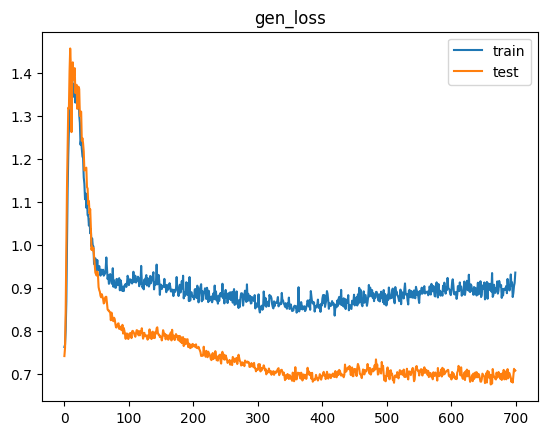

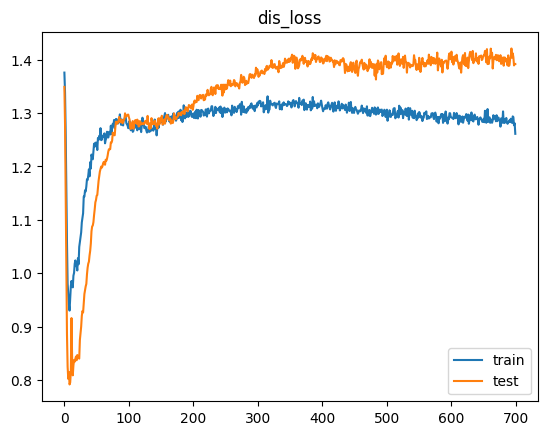

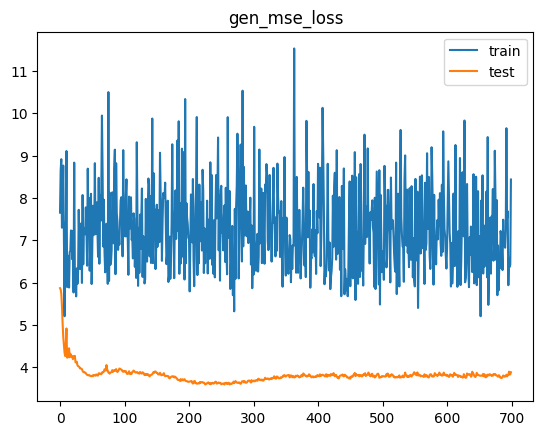

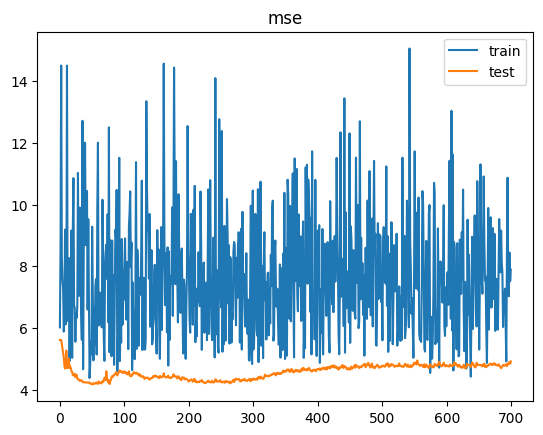

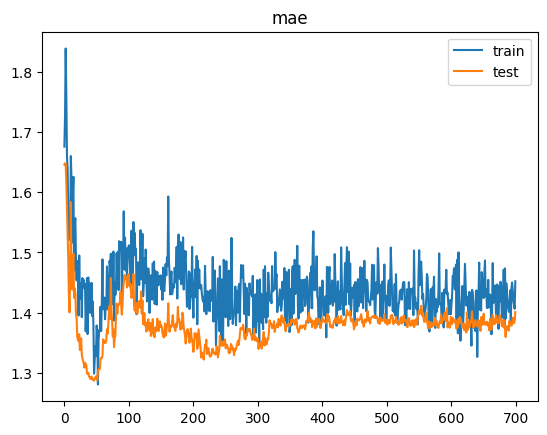

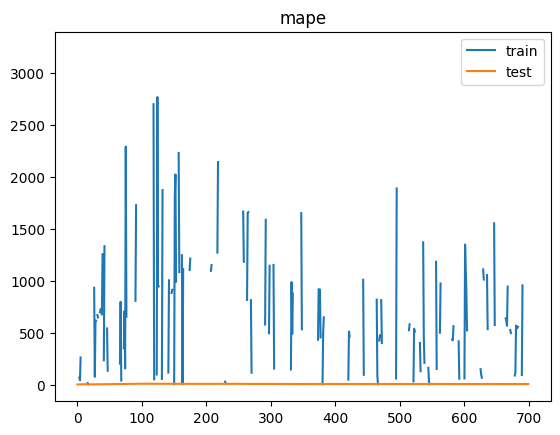

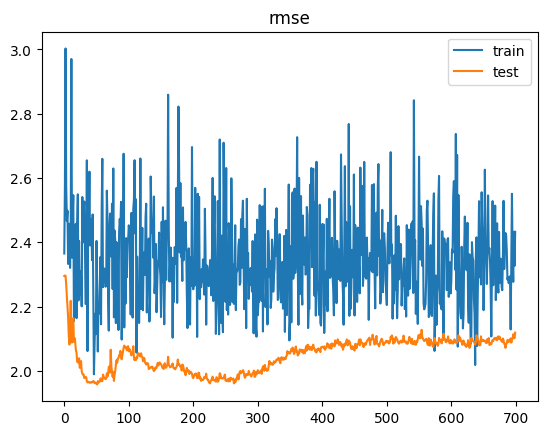

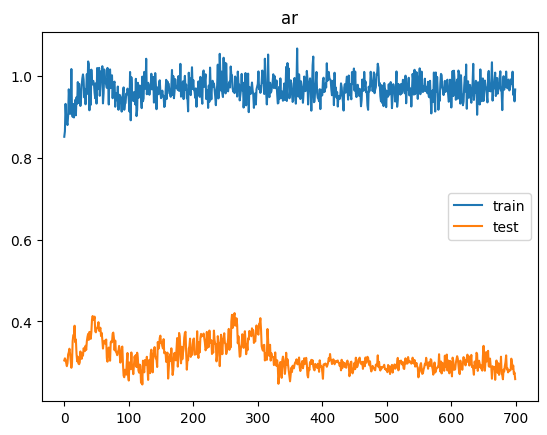

2/2 [==============================] - 0s 3ms/step


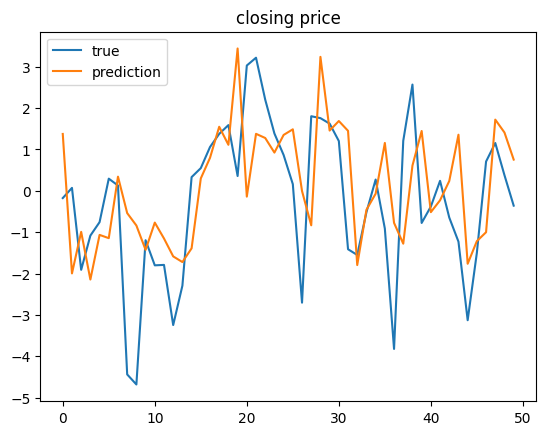

[MSE Baseline] train: 7.34076230674328  test: 4.1521541466081695
Delta time with epochs = 700: 0:10:19.081465
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 gru_6 (GRU)                 (None, 5, 10)             570       
                                                                 
 batch_normalization_6 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_15 (Dropout)        (None, 5, 10)             0         
                                                                 
 gru_7 (GRU)   

Time for epoch 53 is 0.7683811187744141 sec Generator Loss: 0.9634960889816284,  Discriminator_loss: 1.2342066764831543
Time for epoch 54 is 0.7556240558624268 sec Generator Loss: 0.9735299944877625,  Discriminator_loss: 1.237488865852356
Time for epoch 55 is 0.8514788150787354 sec Generator Loss: 0.9697892069816589,  Discriminator_loss: 1.252624273300171
Time for epoch 56 is 0.8764450550079346 sec Generator Loss: 0.9465640187263489,  Discriminator_loss: 1.2484742403030396
Time for epoch 57 is 0.85345458984375 sec Generator Loss: 0.9736626744270325,  Discriminator_loss: 1.2635793685913086
Time for epoch 58 is 0.8027327060699463 sec Generator Loss: 0.9429678320884705,  Discriminator_loss: 1.2574492692947388
Time for epoch 59 is 0.8272202014923096 sec Generator Loss: 0.9260923862457275,  Discriminator_loss: 1.2759660482406616
Time for epoch 60 is 0.8157739639282227 sec Generator Loss: 0.9403871297836304,  Discriminator_loss: 1.2678399085998535
Time for epoch 61 is 0.792396068572998 sec G

Time for epoch 122 is 0.8425755500793457 sec Generator Loss: 0.8506603837013245,  Discriminator_loss: 1.3161616325378418
Time for epoch 123 is 0.864915132522583 sec Generator Loss: 0.8786723613739014,  Discriminator_loss: 1.312976360321045
Time for epoch 124 is 0.8502740859985352 sec Generator Loss: 0.8646094799041748,  Discriminator_loss: 1.3192702531814575
Time for epoch 125 is 0.8620707988739014 sec Generator Loss: 0.8573415279388428,  Discriminator_loss: 1.3149735927581787
Time for epoch 126 is 0.8962748050689697 sec Generator Loss: 0.8689773082733154,  Discriminator_loss: 1.3135650157928467
Time for epoch 127 is 0.9399673938751221 sec Generator Loss: 0.8708942532539368,  Discriminator_loss: 1.305206537246704
Time for epoch 128 is 0.9477076530456543 sec Generator Loss: 0.8763689994812012,  Discriminator_loss: 1.3114874362945557
Time for epoch 129 is 0.9413180351257324 sec Generator Loss: 0.8447155952453613,  Discriminator_loss: 1.319745659828186
Time for epoch 130 is 1.042396545410

Time for epoch 191 is 0.8426518440246582 sec Generator Loss: 0.8559389710426331,  Discriminator_loss: 1.312757134437561
Time for epoch 192 is 0.8195750713348389 sec Generator Loss: 0.8458006381988525,  Discriminator_loss: 1.328169584274292
Time for epoch 193 is 0.8196537494659424 sec Generator Loss: 0.8360747694969177,  Discriminator_loss: 1.32198166847229
Time for epoch 194 is 0.8655130863189697 sec Generator Loss: 0.8764711022377014,  Discriminator_loss: 1.3107123374938965
Time for epoch 195 is 0.8369414806365967 sec Generator Loss: 0.8517000079154968,  Discriminator_loss: 1.3170692920684814
Time for epoch 196 is 0.8207297325134277 sec Generator Loss: 0.8399249911308289,  Discriminator_loss: 1.3134548664093018
Time for epoch 197 is 0.8575935363769531 sec Generator Loss: 0.8566959500312805,  Discriminator_loss: 1.319952130317688
Time for epoch 198 is 0.8288118839263916 sec Generator Loss: 0.8514660000801086,  Discriminator_loss: 1.3198574781417847
Time for epoch 199 is 0.8246827125549

Time for epoch 259 is 0.777651309967041 sec Generator Loss: 0.8650490641593933,  Discriminator_loss: 1.3065087795257568
Time for epoch 260 is 0.7536542415618896 sec Generator Loss: 0.8869248032569885,  Discriminator_loss: 1.309848427772522
Time for epoch 261 is 0.7424521446228027 sec Generator Loss: 0.8840699195861816,  Discriminator_loss: 1.3028470277786255
Time for epoch 262 is 0.7684640884399414 sec Generator Loss: 0.8597655296325684,  Discriminator_loss: 1.3173431158065796
Time for epoch 263 is 0.8054213523864746 sec Generator Loss: 0.8917412757873535,  Discriminator_loss: 1.311192512512207
Time for epoch 264 is 0.8494644165039062 sec Generator Loss: 0.855424165725708,  Discriminator_loss: 1.3158924579620361
Time for epoch 265 is 0.8699984550476074 sec Generator Loss: 0.8728285431861877,  Discriminator_loss: 1.3078808784484863
Time for epoch 266 is 0.7898213863372803 sec Generator Loss: 0.8770403861999512,  Discriminator_loss: 1.3077527284622192
Time for epoch 267 is 0.776132822036

Time for epoch 327 is 0.8851168155670166 sec Generator Loss: 0.8833253383636475,  Discriminator_loss: 1.3009332418441772
Time for epoch 328 is 0.8979918956756592 sec Generator Loss: 0.8896214962005615,  Discriminator_loss: 1.305714726448059
Time for epoch 329 is 0.881019115447998 sec Generator Loss: 0.8842917084693909,  Discriminator_loss: 1.3067373037338257
Time for epoch 330 is 0.8577170372009277 sec Generator Loss: 0.8920010924339294,  Discriminator_loss: 1.2966712713241577
Time for epoch 331 is 0.8598172664642334 sec Generator Loss: 0.906653106212616,  Discriminator_loss: 1.2905610799789429
Time for epoch 332 is 0.8567113876342773 sec Generator Loss: 0.8953923583030701,  Discriminator_loss: 1.3127878904342651
Time for epoch 333 is 0.894249677658081 sec Generator Loss: 0.8839741349220276,  Discriminator_loss: 1.3028486967086792
Time for epoch 334 is 0.8588531017303467 sec Generator Loss: 0.8986412882804871,  Discriminator_loss: 1.2895363569259644
Time for epoch 335 is 0.847497463226

Time for epoch 395 is 0.786597728729248 sec Generator Loss: 0.8840655088424683,  Discriminator_loss: 1.2990267276763916
Time for epoch 396 is 0.7804913520812988 sec Generator Loss: 0.9004626274108887,  Discriminator_loss: 1.2934837341308594
Time for epoch 397 is 0.7885873317718506 sec Generator Loss: 0.8913170099258423,  Discriminator_loss: 1.2946739196777344
Time for epoch 398 is 0.7874429225921631 sec Generator Loss: 0.8975908756256104,  Discriminator_loss: 1.291377067565918
Time for epoch 399 is 0.8308393955230713 sec Generator Loss: 0.9094131588935852,  Discriminator_loss: 1.2936921119689941
Time for epoch 400 is 0.819054365158081 sec Generator Loss: 0.8859635591506958,  Discriminator_loss: 1.3056237697601318
Time for epoch 401 is 0.7901220321655273 sec Generator Loss: 0.9149758815765381,  Discriminator_loss: 1.289078950881958
Time for epoch 402 is 0.7831552028656006 sec Generator Loss: 0.9252892732620239,  Discriminator_loss: 1.2802444696426392
Time for epoch 403 is 0.799629211425

Time for epoch 464 is 0.7914974689483643 sec Generator Loss: 0.895323634147644,  Discriminator_loss: 1.2897499799728394
Time for epoch 465 is 0.8357992172241211 sec Generator Loss: 0.9038500189781189,  Discriminator_loss: 1.271707534790039
Time for epoch 466 is 0.7977471351623535 sec Generator Loss: 0.9099494218826294,  Discriminator_loss: 1.284488558769226
Time for epoch 467 is 0.8133804798126221 sec Generator Loss: 0.9057366847991943,  Discriminator_loss: 1.2878972291946411
Time for epoch 468 is 0.7860321998596191 sec Generator Loss: 0.9371105432510376,  Discriminator_loss: 1.285022258758545
Time for epoch 469 is 0.7779836654663086 sec Generator Loss: 0.9243621826171875,  Discriminator_loss: 1.2883530855178833
Time for epoch 470 is 0.7909097671508789 sec Generator Loss: 0.8987382054328918,  Discriminator_loss: 1.2880421876907349
Time for epoch 471 is 0.8366434574127197 sec Generator Loss: 0.9039729833602905,  Discriminator_loss: 1.2852845191955566
Time for epoch 472 is 0.821838140487

Time for epoch 532 is 0.8768496513366699 sec Generator Loss: 0.9326292872428894,  Discriminator_loss: 1.2907723188400269
Time for epoch 533 is 0.8829593658447266 sec Generator Loss: 0.9089182615280151,  Discriminator_loss: 1.2816637754440308
Time for epoch 534 is 0.9218988418579102 sec Generator Loss: 0.9157316088676453,  Discriminator_loss: 1.2872562408447266
Time for epoch 535 is 0.9808204174041748 sec Generator Loss: 0.9286497235298157,  Discriminator_loss: 1.2810189723968506
Time for epoch 536 is 0.9432132244110107 sec Generator Loss: 0.9048068523406982,  Discriminator_loss: 1.2882243394851685
Time for epoch 537 is 0.961545467376709 sec Generator Loss: 0.9089096784591675,  Discriminator_loss: 1.2832030057907104
Time for epoch 538 is 0.9259676933288574 sec Generator Loss: 0.9102547764778137,  Discriminator_loss: 1.285048484802246
Time for epoch 539 is 0.9293901920318604 sec Generator Loss: 0.9322938919067383,  Discriminator_loss: 1.2780914306640625
Time for epoch 540 is 1.0033373832

Time for epoch 600 is 0.8293414115905762 sec Generator Loss: 0.9247671365737915,  Discriminator_loss: 1.2838624715805054
Time for epoch 601 is 0.8384122848510742 sec Generator Loss: 0.9244356751441956,  Discriminator_loss: 1.2790530920028687
Time for epoch 602 is 0.8334484100341797 sec Generator Loss: 0.924988865852356,  Discriminator_loss: 1.2774015665054321
Time for epoch 603 is 0.804567813873291 sec Generator Loss: 0.9243813157081604,  Discriminator_loss: 1.2679792642593384
Time for epoch 604 is 0.7834575176239014 sec Generator Loss: 0.9149424433708191,  Discriminator_loss: 1.2871599197387695
Time for epoch 605 is 0.787182092666626 sec Generator Loss: 0.9288876056671143,  Discriminator_loss: 1.272489309310913
Time for epoch 606 is 0.7983596324920654 sec Generator Loss: 0.9298914670944214,  Discriminator_loss: 1.2775923013687134
Time for epoch 607 is 0.8019540309906006 sec Generator Loss: 0.9149577021598816,  Discriminator_loss: 1.2851321697235107
Time for epoch 608 is 0.804089069366

Time for epoch 668 is 0.8321738243103027 sec Generator Loss: 0.9236227869987488,  Discriminator_loss: 1.2812408208847046
Time for epoch 669 is 0.8280441761016846 sec Generator Loss: 0.9341976642608643,  Discriminator_loss: 1.27597177028656
Time for epoch 670 is 0.8657057285308838 sec Generator Loss: 0.912774384021759,  Discriminator_loss: 1.2836427688598633
Time for epoch 671 is 0.8260350227355957 sec Generator Loss: 0.9517241716384888,  Discriminator_loss: 1.2592322826385498
Time for epoch 672 is 0.8426945209503174 sec Generator Loss: 0.9335843324661255,  Discriminator_loss: 1.2651642560958862
Time for epoch 673 is 0.8909475803375244 sec Generator Loss: 0.9280980229377747,  Discriminator_loss: 1.2632333040237427
Time for epoch 674 is 0.9183962345123291 sec Generator Loss: 0.9160816669464111,  Discriminator_loss: 1.2766070365905762
Time for epoch 675 is 0.9541361331939697 sec Generator Loss: 0.9028010964393616,  Discriminator_loss: 1.2836307287216187
Time for epoch 676 is 0.93256902694

Time for epoch 736 is 0.944101095199585 sec Generator Loss: 0.9282645583152771,  Discriminator_loss: 1.2738380432128906
Time for epoch 737 is 0.9084763526916504 sec Generator Loss: 0.9285596013069153,  Discriminator_loss: 1.274416446685791
Time for epoch 738 is 0.924189567565918 sec Generator Loss: 0.9535831212997437,  Discriminator_loss: 1.2742762565612793
Time for epoch 739 is 0.900651216506958 sec Generator Loss: 0.9500528573989868,  Discriminator_loss: 1.2651267051696777
Time for epoch 740 is 0.8818032741546631 sec Generator Loss: 0.9474729895591736,  Discriminator_loss: 1.2777479887008667
Time for epoch 741 is 0.9003133773803711 sec Generator Loss: 0.9365198612213135,  Discriminator_loss: 1.2843669652938843
Time for epoch 742 is 0.9294195175170898 sec Generator Loss: 0.941098153591156,  Discriminator_loss: 1.2739930152893066
Time for epoch 743 is 0.9361133575439453 sec Generator Loss: 0.9140583276748657,  Discriminator_loss: 1.2764272689819336
Time for epoch 744 is 0.8968756198883

Time for epoch 805 is 0.9151623249053955 sec Generator Loss: 0.9451861381530762,  Discriminator_loss: 1.2650270462036133
Time for epoch 806 is 0.8805158138275146 sec Generator Loss: 0.9449537992477417,  Discriminator_loss: 1.2657470703125
Time for epoch 807 is 0.9347171783447266 sec Generator Loss: 0.9244617819786072,  Discriminator_loss: 1.2749608755111694
Time for epoch 808 is 0.9350590705871582 sec Generator Loss: 0.9614238739013672,  Discriminator_loss: 1.2605303525924683
Time for epoch 809 is 0.853895902633667 sec Generator Loss: 0.9283519387245178,  Discriminator_loss: 1.2750426530838013
Time for epoch 810 is 0.8413455486297607 sec Generator Loss: 0.9340154528617859,  Discriminator_loss: 1.272237777709961
Time for epoch 811 is 0.8450970649719238 sec Generator Loss: 0.966729998588562,  Discriminator_loss: 1.259950041770935
Time for epoch 812 is 0.8651852607727051 sec Generator Loss: 0.9514399170875549,  Discriminator_loss: 1.2707144021987915
Time for epoch 813 is 0.885074853897094

Time for epoch 874 is 0.750737190246582 sec Generator Loss: 0.9383034706115723,  Discriminator_loss: 1.2617688179016113
Time for epoch 875 is 0.7536094188690186 sec Generator Loss: 0.9550291299819946,  Discriminator_loss: 1.2649987936019897
Time for epoch 876 is 0.7663905620574951 sec Generator Loss: 0.9633000493049622,  Discriminator_loss: 1.2606762647628784
Time for epoch 877 is 0.7877688407897949 sec Generator Loss: 0.9275294542312622,  Discriminator_loss: 1.2781728506088257
Time for epoch 878 is 0.7547886371612549 sec Generator Loss: 0.9573052525520325,  Discriminator_loss: 1.2511745691299438
Time for epoch 879 is 0.7657015323638916 sec Generator Loss: 0.9528425335884094,  Discriminator_loss: 1.263350009918213
Time for epoch 880 is 0.7532131671905518 sec Generator Loss: 0.9352379441261292,  Discriminator_loss: 1.2705800533294678
Time for epoch 881 is 0.7592446804046631 sec Generator Loss: 0.9432782530784607,  Discriminator_loss: 1.2677154541015625
Time for epoch 882 is 0.7836353778

Time for epoch 942 is 0.9082202911376953 sec Generator Loss: 0.9653977751731873,  Discriminator_loss: 1.260003924369812
Time for epoch 943 is 0.9272258281707764 sec Generator Loss: 0.9459755420684814,  Discriminator_loss: 1.2650465965270996
Time for epoch 944 is 0.9665324687957764 sec Generator Loss: 0.9475373029708862,  Discriminator_loss: 1.2643733024597168
Time for epoch 945 is 0.9863970279693604 sec Generator Loss: 0.9655930995941162,  Discriminator_loss: 1.2609128952026367
Time for epoch 946 is 1.021226406097412 sec Generator Loss: 0.9655463099479675,  Discriminator_loss: 1.259108543395996
Time for epoch 947 is 0.9613509178161621 sec Generator Loss: 0.9390158653259277,  Discriminator_loss: 1.2623921632766724
Time for epoch 948 is 0.8841350078582764 sec Generator Loss: 0.9511845111846924,  Discriminator_loss: 1.259634256362915
Time for epoch 949 is 0.8168947696685791 sec Generator Loss: 0.9556558132171631,  Discriminator_loss: 1.2604764699935913
Time for epoch 950 is 0.767138719558

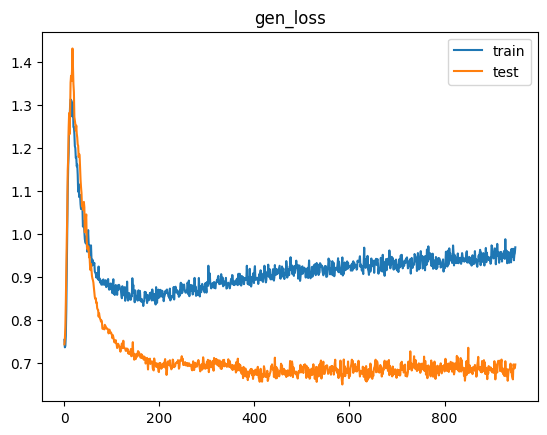

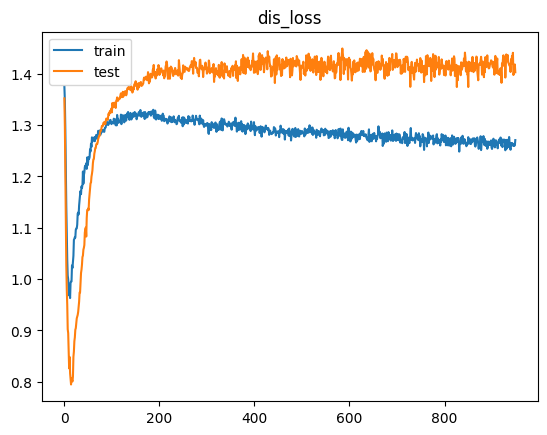

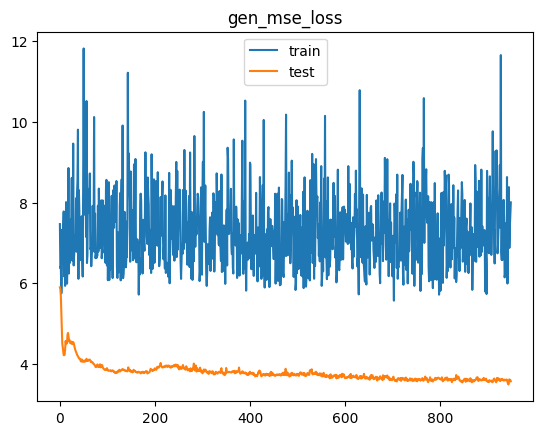

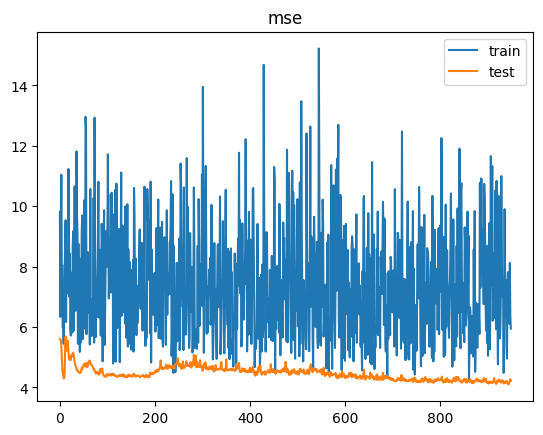

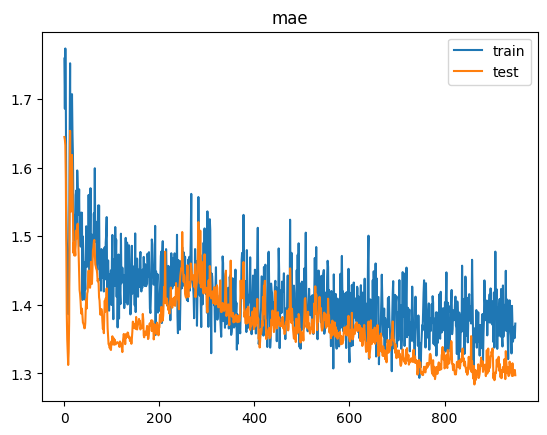

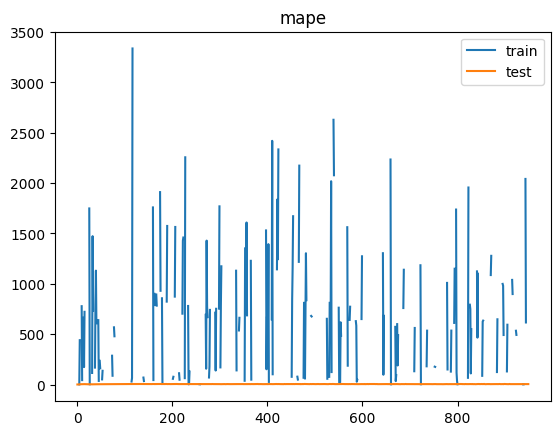

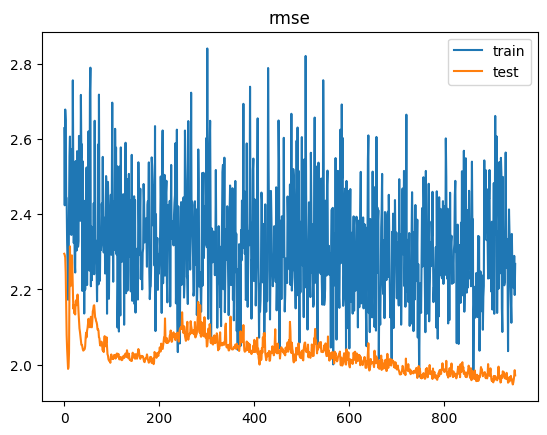

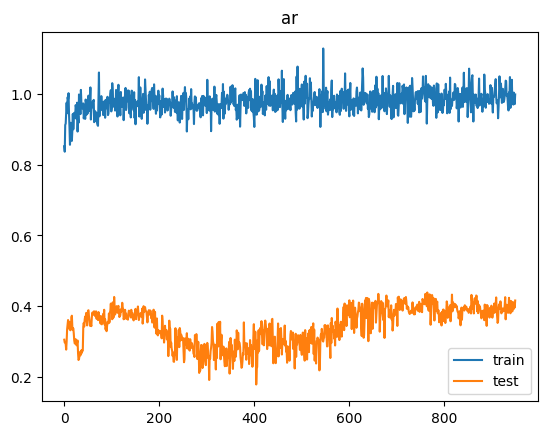

2/2 [==============================] - 0s 3ms/step


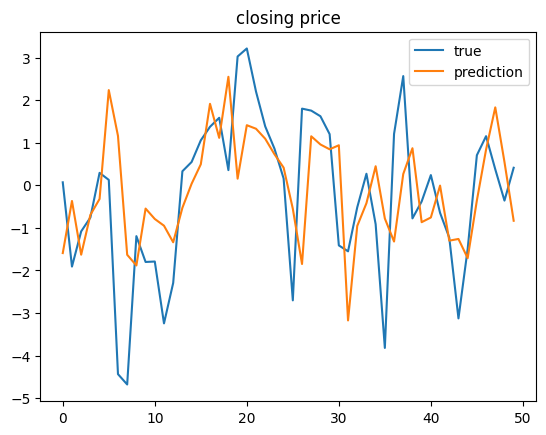

[MSE Baseline] train: 5.615690822177881  test: 4.16723565376744
Delta time with epochs = 950: 0:13:49.984424
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 gru_8 (GRU)                 (None, 5, 10)             570       
                                                                 
 batch_normalization_8 (Batc  (None, 5, 10)            40        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_20 (Dropout)        (None, 5, 10)             0         
                                                                 
 gru_9 (GRU)    

Time for epoch 53 is 0.8304390907287598 sec Generator Loss: 0.9978060722351074,  Discriminator_loss: 1.2424131631851196
Time for epoch 54 is 0.8551125526428223 sec Generator Loss: 0.9809575080871582,  Discriminator_loss: 1.2350667715072632
Time for epoch 55 is 0.8782923221588135 sec Generator Loss: 0.97396320104599,  Discriminator_loss: 1.2445770502090454
Time for epoch 56 is 1.000922441482544 sec Generator Loss: 0.965273380279541,  Discriminator_loss: 1.250099539756775
Time for epoch 57 is 1.0183095932006836 sec Generator Loss: 0.9919254183769226,  Discriminator_loss: 1.2415974140167236
Time for epoch 58 is 0.9130830764770508 sec Generator Loss: 0.963364839553833,  Discriminator_loss: 1.2668821811676025
Time for epoch 59 is 0.961292028427124 sec Generator Loss: 0.9467763900756836,  Discriminator_loss: 1.2722208499908447
Time for epoch 60 is 0.9447238445281982 sec Generator Loss: 0.9446718692779541,  Discriminator_loss: 1.2589640617370605
Time for epoch 61 is 0.9093418121337891 sec Gen

Time for epoch 122 is 0.9417121410369873 sec Generator Loss: 0.9020390510559082,  Discriminator_loss: 1.2957807779312134
Time for epoch 123 is 0.9080297946929932 sec Generator Loss: 0.9198634624481201,  Discriminator_loss: 1.2862718105316162
Time for epoch 124 is 0.9020349979400635 sec Generator Loss: 0.9040333032608032,  Discriminator_loss: 1.2950289249420166
Time for epoch 125 is 0.8726346492767334 sec Generator Loss: 0.9073124527931213,  Discriminator_loss: 1.2927558422088623
Time for epoch 126 is 0.8986043930053711 sec Generator Loss: 0.9065549373626709,  Discriminator_loss: 1.3083072900772095
Time for epoch 127 is 0.8537108898162842 sec Generator Loss: 0.8999104499816895,  Discriminator_loss: 1.2935292720794678
Time for epoch 128 is 0.8760643005371094 sec Generator Loss: 0.8976064324378967,  Discriminator_loss: 1.2930952310562134
Time for epoch 129 is 0.8455522060394287 sec Generator Loss: 0.9077604413032532,  Discriminator_loss: 1.3031630516052246
Time for epoch 130 is 0.83918118

Time for epoch 190 is 0.8609800338745117 sec Generator Loss: 0.8870543241500854,  Discriminator_loss: 1.2986630201339722
Time for epoch 191 is 0.8554904460906982 sec Generator Loss: 0.8800365924835205,  Discriminator_loss: 1.2988393306732178
Time for epoch 192 is 0.9245450496673584 sec Generator Loss: 0.8966930508613586,  Discriminator_loss: 1.2902021408081055
Time for epoch 193 is 0.9545614719390869 sec Generator Loss: 0.8876399397850037,  Discriminator_loss: 1.3034917116165161
Time for epoch 194 is 1.0889256000518799 sec Generator Loss: 0.8962466716766357,  Discriminator_loss: 1.295779824256897
Time for epoch 195 is 0.9717416763305664 sec Generator Loss: 0.8844154477119446,  Discriminator_loss: 1.2969022989273071
Time for epoch 196 is 0.9860491752624512 sec Generator Loss: 0.9099239110946655,  Discriminator_loss: 1.2926630973815918
Time for epoch 197 is 1.0089399814605713 sec Generator Loss: 0.891409695148468,  Discriminator_loss: 1.2858400344848633
Time for epoch 198 is 1.0575098991

Time for epoch 259 is 0.8071279525756836 sec Generator Loss: 0.8966888785362244,  Discriminator_loss: 1.2979401350021362
Time for epoch 260 is 0.8130831718444824 sec Generator Loss: 0.8962181806564331,  Discriminator_loss: 1.2949802875518799
Time for epoch 261 is 0.876763105392456 sec Generator Loss: 0.9168898463249207,  Discriminator_loss: 1.2976523637771606
Time for epoch 262 is 0.8186230659484863 sec Generator Loss: 0.9249714612960815,  Discriminator_loss: 1.2946854829788208
Time for epoch 263 is 0.7838685512542725 sec Generator Loss: 0.8984222412109375,  Discriminator_loss: 1.305120825767517
Time for epoch 264 is 0.8384253978729248 sec Generator Loss: 0.886947751045227,  Discriminator_loss: 1.299211025238037
Time for epoch 265 is 0.8046736717224121 sec Generator Loss: 0.8895261883735657,  Discriminator_loss: 1.2914265394210815
Time for epoch 266 is 0.817547082901001 sec Generator Loss: 0.8971767425537109,  Discriminator_loss: 1.2994235754013062
Time for epoch 267 is 0.8201675415039

Time for epoch 327 is 1.0172295570373535 sec Generator Loss: 0.9060781598091125,  Discriminator_loss: 1.2893356084823608
Time for epoch 328 is 1.0729329586029053 sec Generator Loss: 0.8961204290390015,  Discriminator_loss: 1.2923356294631958
Time for epoch 329 is 1.0294926166534424 sec Generator Loss: 0.8943631649017334,  Discriminator_loss: 1.2978565692901611
Time for epoch 330 is 0.9805829524993896 sec Generator Loss: 0.9196308851242065,  Discriminator_loss: 1.2903205156326294
Time for epoch 331 is 0.9653780460357666 sec Generator Loss: 0.9031155109405518,  Discriminator_loss: 1.2857372760772705
Time for epoch 332 is 0.8570899963378906 sec Generator Loss: 0.910402238368988,  Discriminator_loss: 1.2961431741714478
Time for epoch 333 is 0.8685898780822754 sec Generator Loss: 0.9108050465583801,  Discriminator_loss: 1.2941983938217163
Time for epoch 334 is 0.8896474838256836 sec Generator Loss: 0.8986853361129761,  Discriminator_loss: 1.291646957397461
Time for epoch 335 is 0.8513324260

Time for epoch 395 is 0.9321050643920898 sec Generator Loss: 0.8989612460136414,  Discriminator_loss: 1.3003007173538208
Time for epoch 396 is 0.9232239723205566 sec Generator Loss: 0.9106982946395874,  Discriminator_loss: 1.2852139472961426
Time for epoch 397 is 0.8564074039459229 sec Generator Loss: 0.9169658422470093,  Discriminator_loss: 1.2891427278518677
Time for epoch 398 is 0.8610212802886963 sec Generator Loss: 0.9081836342811584,  Discriminator_loss: 1.2966513633728027
Time for epoch 399 is 0.8570883274078369 sec Generator Loss: 0.9294734597206116,  Discriminator_loss: 1.2862873077392578
Time for epoch 400 is 0.8867595195770264 sec Generator Loss: 0.9235063195228577,  Discriminator_loss: 1.294344186782837
Time for epoch 401 is 0.91365647315979 sec Generator Loss: 0.8938402533531189,  Discriminator_loss: 1.2981207370758057
Time for epoch 402 is 0.8540596961975098 sec Generator Loss: 0.8984847664833069,  Discriminator_loss: 1.2955595254898071
Time for epoch 403 is 0.83117961883

Time for epoch 463 is 0.8424122333526611 sec Generator Loss: 0.8960700631141663,  Discriminator_loss: 1.2897602319717407
Time for epoch 464 is 0.7657034397125244 sec Generator Loss: 0.9011818170547485,  Discriminator_loss: 1.301254391670227
Time for epoch 465 is 0.7548415660858154 sec Generator Loss: 0.892578125,  Discriminator_loss: 1.3028249740600586
Time for epoch 466 is 2.1894290447235107 sec Generator Loss: 0.9101806282997131,  Discriminator_loss: 1.2999986410140991
Time for epoch 467 is 0.9613854885101318 sec Generator Loss: 0.8938130140304565,  Discriminator_loss: 1.2921397686004639
Time for epoch 468 is 0.9582102298736572 sec Generator Loss: 0.9036449193954468,  Discriminator_loss: 1.29790461063385
Time for epoch 469 is 0.9563117027282715 sec Generator Loss: 0.9289148449897766,  Discriminator_loss: 1.292126178741455
Time for epoch 470 is 0.9309704303741455 sec Generator Loss: 0.8973708748817444,  Discriminator_loss: 1.288953423500061
Time for epoch 471 is 0.9217207431793213 sec

Time for epoch 532 is 0.7800061702728271 sec Generator Loss: 0.8922944068908691,  Discriminator_loss: 1.3002127408981323
Time for epoch 533 is 0.7561120986938477 sec Generator Loss: 0.909447193145752,  Discriminator_loss: 1.2999439239501953
Time for epoch 534 is 0.7813601493835449 sec Generator Loss: 0.8827502131462097,  Discriminator_loss: 1.3008534908294678
Time for epoch 535 is 0.814971923828125 sec Generator Loss: 0.9049058556556702,  Discriminator_loss: 1.2865480184555054
Time for epoch 536 is 0.7824490070343018 sec Generator Loss: 0.8854601383209229,  Discriminator_loss: 1.2925552129745483
Time for epoch 537 is 0.779691219329834 sec Generator Loss: 0.9003925919532776,  Discriminator_loss: 1.2877763509750366
Time for epoch 538 is 0.8200712203979492 sec Generator Loss: 0.885367751121521,  Discriminator_loss: 1.304616093635559
Time for epoch 539 is 0.8269138336181641 sec Generator Loss: 0.8985296487808228,  Discriminator_loss: 1.2915083169937134
Time for epoch 540 is 0.7532892227172

Time for epoch 601 is 1.0294697284698486 sec Generator Loss: 0.8965716361999512,  Discriminator_loss: 1.2914427518844604
Time for epoch 602 is 0.9951107501983643 sec Generator Loss: 0.9112218618392944,  Discriminator_loss: 1.2906396389007568
Time for epoch 603 is 1.0035009384155273 sec Generator Loss: 0.8984537124633789,  Discriminator_loss: 1.2937242984771729
Time for epoch 604 is 0.9215960502624512 sec Generator Loss: 0.915137767791748,  Discriminator_loss: 1.285200595855713
Time for epoch 605 is 0.9400358200073242 sec Generator Loss: 0.9181394577026367,  Discriminator_loss: 1.2799817323684692
Time for epoch 606 is 0.956352949142456 sec Generator Loss: 0.9055101871490479,  Discriminator_loss: 1.295253872871399
Time for epoch 607 is 1.0324771404266357 sec Generator Loss: 0.9387838840484619,  Discriminator_loss: 1.2828309535980225
Time for epoch 608 is 0.9652183055877686 sec Generator Loss: 0.9073137640953064,  Discriminator_loss: 1.2984356880187988
Time for epoch 609 is 0.973607778549

Time for epoch 670 is 0.8414790630340576 sec Generator Loss: 0.9210677146911621,  Discriminator_loss: 1.282234787940979
Time for epoch 671 is 0.8516433238983154 sec Generator Loss: 0.926260769367218,  Discriminator_loss: 1.2740179300308228
Time for epoch 672 is 0.9715132713317871 sec Generator Loss: 0.9469545483589172,  Discriminator_loss: 1.273450255393982
Time for epoch 673 is 0.8745377063751221 sec Generator Loss: 0.9121080040931702,  Discriminator_loss: 1.2887240648269653
Time for epoch 674 is 0.9031500816345215 sec Generator Loss: 0.9267918467521667,  Discriminator_loss: 1.2767324447631836
Time for epoch 675 is 0.9133734703063965 sec Generator Loss: 0.9335774779319763,  Discriminator_loss: 1.2818379402160645
Time for epoch 676 is 0.8844788074493408 sec Generator Loss: 0.9573240876197815,  Discriminator_loss: 1.2779418230056763
Time for epoch 677 is 0.8330633640289307 sec Generator Loss: 0.9352865815162659,  Discriminator_loss: 1.273532509803772
Time for epoch 678 is 1.164446592330

Time for epoch 738 is 0.8223185539245605 sec Generator Loss: 0.9115952253341675,  Discriminator_loss: 1.271272897720337
Time for epoch 739 is 0.8621165752410889 sec Generator Loss: 0.9384844899177551,  Discriminator_loss: 1.2819427251815796
Time for epoch 740 is 0.835564136505127 sec Generator Loss: 0.9635602831840515,  Discriminator_loss: 1.2847840785980225
Time for epoch 741 is 0.8244574069976807 sec Generator Loss: 0.9277663230895996,  Discriminator_loss: 1.2836023569107056
Time for epoch 742 is 0.801720142364502 sec Generator Loss: 0.951600193977356,  Discriminator_loss: 1.2719054222106934
Time for epoch 743 is 0.8350157737731934 sec Generator Loss: 0.9260702729225159,  Discriminator_loss: 1.2770265340805054
Time for epoch 744 is 0.8970334529876709 sec Generator Loss: 0.9275488257408142,  Discriminator_loss: 1.2741111516952515
Time for epoch 745 is 0.9549896717071533 sec Generator Loss: 0.9279816150665283,  Discriminator_loss: 1.2698079347610474
Time for epoch 746 is 0.792950391769

Time for epoch 807 is 0.780104398727417 sec Generator Loss: 0.9208438992500305,  Discriminator_loss: 1.280562400817871
Time for epoch 808 is 0.7855901718139648 sec Generator Loss: 0.9513356685638428,  Discriminator_loss: 1.2616366147994995
Time for epoch 809 is 0.8000023365020752 sec Generator Loss: 0.918371856212616,  Discriminator_loss: 1.2835540771484375
Time for epoch 810 is 0.7912428379058838 sec Generator Loss: 0.917626142501831,  Discriminator_loss: 1.277897834777832
Time for epoch 811 is 0.8560011386871338 sec Generator Loss: 0.9370303153991699,  Discriminator_loss: 1.274750828742981
Time for epoch 812 is 0.8432257175445557 sec Generator Loss: 0.9223078489303589,  Discriminator_loss: 1.2761989831924438
Time for epoch 813 is 0.8087947368621826 sec Generator Loss: 0.922012984752655,  Discriminator_loss: 1.2795802354812622
Time for epoch 814 is 0.82810378074646 sec Generator Loss: 0.9472923874855042,  Discriminator_loss: 1.2715705633163452
Time for epoch 815 is 0.8052501678466797 

Time for epoch 876 is 0.8175463676452637 sec Generator Loss: 0.9211719036102295,  Discriminator_loss: 1.2791591882705688
Time for epoch 877 is 0.9157817363739014 sec Generator Loss: 0.9201485514640808,  Discriminator_loss: 1.2927072048187256
Time for epoch 878 is 0.8753774166107178 sec Generator Loss: 0.9465781450271606,  Discriminator_loss: 1.2678558826446533
Time for epoch 879 is 0.78515625 sec Generator Loss: 0.9395753145217896,  Discriminator_loss: 1.276878833770752
Time for epoch 880 is 0.8760960102081299 sec Generator Loss: 0.9628989696502686,  Discriminator_loss: 1.2613179683685303
Time for epoch 881 is 0.9787311553955078 sec Generator Loss: 0.9292075634002686,  Discriminator_loss: 1.2826459407806396
Time for epoch 882 is 1.0099360942840576 sec Generator Loss: 0.9387285113334656,  Discriminator_loss: 1.274657130241394
Time for epoch 883 is 1.1332249641418457 sec Generator Loss: 0.9384363889694214,  Discriminator_loss: 1.275411605834961
Time for epoch 884 is 0.9347801208496094 se

Time for epoch 945 is 0.799640417098999 sec Generator Loss: 0.9565845727920532,  Discriminator_loss: 1.2751095294952393
Time for epoch 946 is 0.834261417388916 sec Generator Loss: 0.9273936152458191,  Discriminator_loss: 1.2755626440048218
Time for epoch 947 is 0.8301863670349121 sec Generator Loss: 0.9235405325889587,  Discriminator_loss: 1.2739944458007812
Time for epoch 948 is 0.7999632358551025 sec Generator Loss: 0.9368563294410706,  Discriminator_loss: 1.2787021398544312
Time for epoch 949 is 0.8056807518005371 sec Generator Loss: 0.946811854839325,  Discriminator_loss: 1.2778868675231934
Time for epoch 950 is 0.8110966682434082 sec Generator Loss: 0.9528596997261047,  Discriminator_loss: 1.2590508460998535
Time for epoch 951 is 0.8195765018463135 sec Generator Loss: 0.9397201538085938,  Discriminator_loss: 1.2685507535934448
Time for epoch 952 is 0.7943308353424072 sec Generator Loss: 0.948225200176239,  Discriminator_loss: 1.2699534893035889
Time for epoch 953 is 0.851192951202

Time for epoch 1013 is 0.842113733291626 sec Generator Loss: 0.9287503361701965,  Discriminator_loss: 1.2854305505752563
Time for epoch 1014 is 0.7952702045440674 sec Generator Loss: 0.9236971139907837,  Discriminator_loss: 1.2747145891189575
Time for epoch 1015 is 0.8044366836547852 sec Generator Loss: 0.9186385869979858,  Discriminator_loss: 1.2870819568634033
Time for epoch 1016 is 0.8017735481262207 sec Generator Loss: 0.9261771440505981,  Discriminator_loss: 1.276930570602417
Time for epoch 1017 is 0.8021841049194336 sec Generator Loss: 0.9521253705024719,  Discriminator_loss: 1.2702670097351074
Time for epoch 1018 is 0.8197050094604492 sec Generator Loss: 0.9532058238983154,  Discriminator_loss: 1.2635602951049805
Time for epoch 1019 is 0.8429722785949707 sec Generator Loss: 0.9184812307357788,  Discriminator_loss: 1.274774432182312
Time for epoch 1020 is 0.7953438758850098 sec Generator Loss: 0.9220552444458008,  Discriminator_loss: 1.2827515602111816
Time for epoch 1021 is 0.80

Time for epoch 1081 is 0.8661293983459473 sec Generator Loss: 0.932968020439148,  Discriminator_loss: 1.2695345878601074
Time for epoch 1082 is 0.824265718460083 sec Generator Loss: 0.9599898457527161,  Discriminator_loss: 1.2584327459335327
Time for epoch 1083 is 0.8080239295959473 sec Generator Loss: 0.9456853866577148,  Discriminator_loss: 1.2607804536819458
Time for epoch 1084 is 0.793304443359375 sec Generator Loss: 0.9257277846336365,  Discriminator_loss: 1.2775285243988037
Time for epoch 1085 is 0.8598356246948242 sec Generator Loss: 0.9797602295875549,  Discriminator_loss: 1.2587432861328125
Time for epoch 1086 is 0.7947256565093994 sec Generator Loss: 0.9474451541900635,  Discriminator_loss: 1.2633105516433716
Time for epoch 1087 is 0.8013584613800049 sec Generator Loss: 0.9189480543136597,  Discriminator_loss: 1.275492548942566
Time for epoch 1088 is 0.7909338474273682 sec Generator Loss: 0.9349353313446045,  Discriminator_loss: 1.2782297134399414
Time for epoch 1089 is 0.800

Time for epoch 1149 is 0.9650537967681885 sec Generator Loss: 0.9514290690422058,  Discriminator_loss: 1.269144058227539
Time for epoch 1150 is 0.8767187595367432 sec Generator Loss: 0.9351272583007812,  Discriminator_loss: 1.267032504081726
Time for epoch 1151 is 0.8799421787261963 sec Generator Loss: 0.9618685841560364,  Discriminator_loss: 1.2585605382919312
Time for epoch 1152 is 0.943925142288208 sec Generator Loss: 0.9389548897743225,  Discriminator_loss: 1.2789522409439087
Time for epoch 1153 is 0.8485391139984131 sec Generator Loss: 0.9525415301322937,  Discriminator_loss: 1.2688581943511963
Time for epoch 1154 is 0.8577101230621338 sec Generator Loss: 0.960480272769928,  Discriminator_loss: 1.271349549293518
Time for epoch 1155 is 0.8419606685638428 sec Generator Loss: 0.9473956823348999,  Discriminator_loss: 1.266043782234192
Time for epoch 1156 is 0.8340880870819092 sec Generator Loss: 0.9498518705368042,  Discriminator_loss: 1.2733161449432373
Time for epoch 1157 is 0.84220

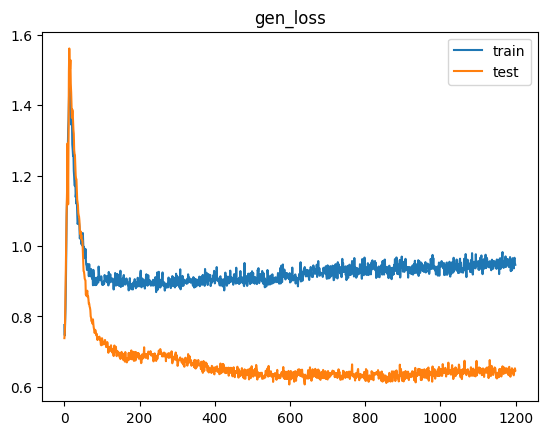

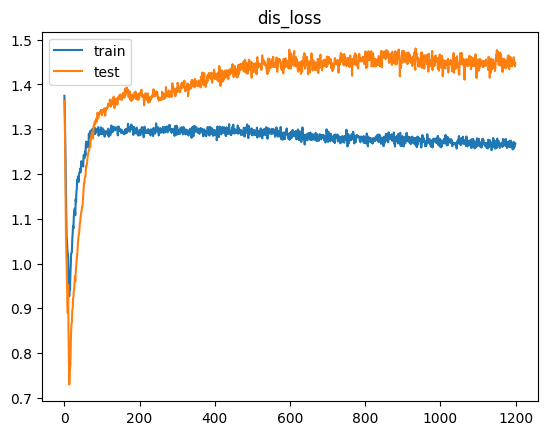

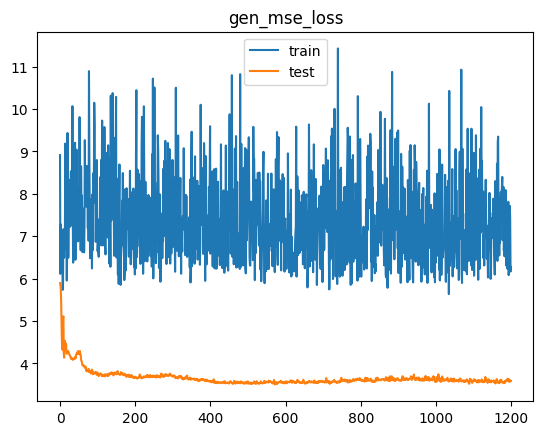

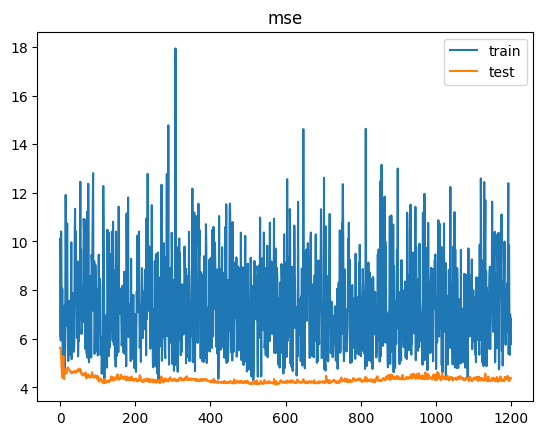

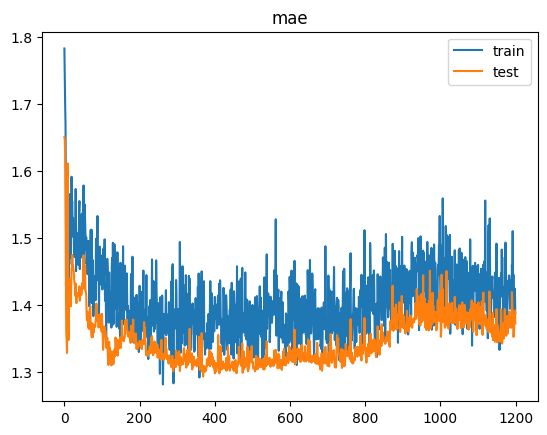

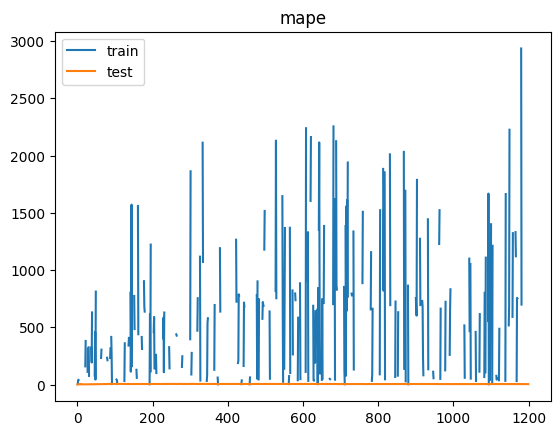

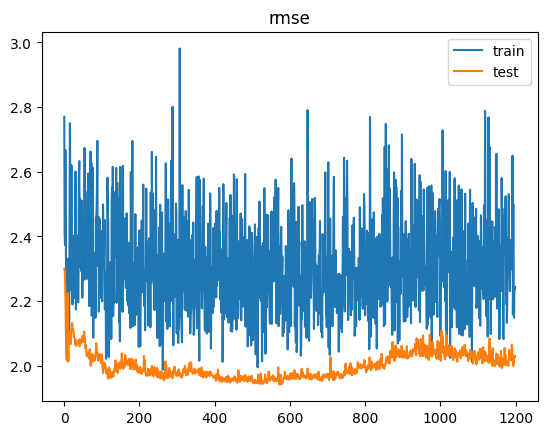

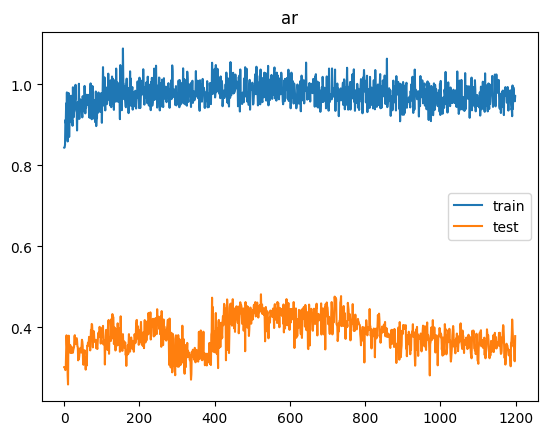

2/2 [==============================] - 0s 4ms/step


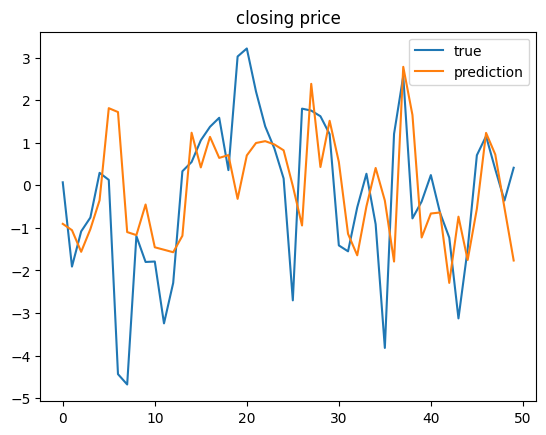

[MSE Baseline] train: 8.21378010624283  test: 4.16723565376744
Delta time with epochs = 1200: 0:17:33.304241
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 gru_10 (GRU)                (None, 5, 10)             570       
                                                                 
 batch_normalization_10 (Bat  (None, 5, 10)            40        
 chNormalization)                                                
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_25 (Dropout)        (None, 5, 10)             0         
                                                                 
 gru_11 (GRU)   

Time for epoch 53 is 0.827739953994751 sec Generator Loss: 0.9849539995193481,  Discriminator_loss: 1.2323081493377686
Time for epoch 54 is 0.806344747543335 sec Generator Loss: 0.9862006306648254,  Discriminator_loss: 1.2221894264221191
Time for epoch 55 is 0.7968213558197021 sec Generator Loss: 0.9809966683387756,  Discriminator_loss: 1.236348032951355
Time for epoch 56 is 0.805199384689331 sec Generator Loss: 0.9893866181373596,  Discriminator_loss: 1.2272783517837524
Time for epoch 57 is 0.8269541263580322 sec Generator Loss: 0.9729483127593994,  Discriminator_loss: 1.2396764755249023
Time for epoch 58 is 0.8006625175476074 sec Generator Loss: 0.9685246348381042,  Discriminator_loss: 1.2338721752166748
Time for epoch 59 is 0.7992880344390869 sec Generator Loss: 0.9822776317596436,  Discriminator_loss: 1.2327308654785156
Time for epoch 60 is 0.798661470413208 sec Generator Loss: 0.9598553776741028,  Discriminator_loss: 1.2427634000778198
Time for epoch 61 is 0.8280444145202637 sec G

Time for epoch 122 is 0.8655242919921875 sec Generator Loss: 0.8955380916595459,  Discriminator_loss: 1.294857382774353
Time for epoch 123 is 0.8167891502380371 sec Generator Loss: 0.9134803414344788,  Discriminator_loss: 1.2751126289367676
Time for epoch 124 is 0.7998998165130615 sec Generator Loss: 0.9099676012992859,  Discriminator_loss: 1.2853038311004639
Time for epoch 125 is 0.7973558902740479 sec Generator Loss: 0.9108837842941284,  Discriminator_loss: 1.2855441570281982
Time for epoch 126 is 0.8411452770233154 sec Generator Loss: 0.9159077405929565,  Discriminator_loss: 1.2930757999420166
Time for epoch 127 is 0.9429359436035156 sec Generator Loss: 0.8935770988464355,  Discriminator_loss: 1.296865701675415
Time for epoch 128 is 0.9980151653289795 sec Generator Loss: 0.9021390080451965,  Discriminator_loss: 1.2937192916870117
Time for epoch 129 is 0.9176850318908691 sec Generator Loss: 0.8842355012893677,  Discriminator_loss: 1.2954835891723633
Time for epoch 130 is 0.9049534797

Time for epoch 190 is 0.8214969635009766 sec Generator Loss: 0.8867525458335876,  Discriminator_loss: 1.2956130504608154
Time for epoch 191 is 0.8029477596282959 sec Generator Loss: 0.8841963410377502,  Discriminator_loss: 1.3047722578048706
Time for epoch 192 is 0.796586275100708 sec Generator Loss: 0.8866713643074036,  Discriminator_loss: 1.2908793687820435
Time for epoch 193 is 0.7985701560974121 sec Generator Loss: 0.911361813545227,  Discriminator_loss: 1.289613127708435
Time for epoch 194 is 0.8215363025665283 sec Generator Loss: 0.9060050845146179,  Discriminator_loss: 1.306734323501587
Time for epoch 195 is 0.7958908081054688 sec Generator Loss: 0.8832725286483765,  Discriminator_loss: 1.293783187866211
Time for epoch 196 is 0.8993792533874512 sec Generator Loss: 0.8904297351837158,  Discriminator_loss: 1.2943559885025024
Time for epoch 197 is 0.8988006114959717 sec Generator Loss: 0.9058147668838501,  Discriminator_loss: 1.2926477193832397
Time for epoch 198 is 1.0007724761962

Time for epoch 259 is 0.7966151237487793 sec Generator Loss: 0.909386157989502,  Discriminator_loss: 1.2871805429458618
Time for epoch 260 is 0.7717485427856445 sec Generator Loss: 0.900200605392456,  Discriminator_loss: 1.2947297096252441
Time for epoch 261 is 0.7498633861541748 sec Generator Loss: 0.8781883716583252,  Discriminator_loss: 1.301478385925293
Time for epoch 262 is 0.7487165927886963 sec Generator Loss: 0.8954482078552246,  Discriminator_loss: 1.2895617485046387
Time for epoch 263 is 0.7549498081207275 sec Generator Loss: 0.9275778532028198,  Discriminator_loss: 1.300730586051941
Time for epoch 264 is 0.777738094329834 sec Generator Loss: 0.8716698884963989,  Discriminator_loss: 1.3072881698608398
Time for epoch 265 is 0.8284754753112793 sec Generator Loss: 0.891030490398407,  Discriminator_loss: 1.2998942136764526
Time for epoch 266 is 0.7670028209686279 sec Generator Loss: 0.8738695979118347,  Discriminator_loss: 1.2991639375686646
Time for epoch 267 is 0.77026987075805

Time for epoch 327 is 0.8549702167510986 sec Generator Loss: 0.8850553631782532,  Discriminator_loss: 1.3007659912109375
Time for epoch 328 is 1.069523572921753 sec Generator Loss: 0.8891335129737854,  Discriminator_loss: 1.308611512184143
Time for epoch 329 is 0.9244422912597656 sec Generator Loss: 0.8847332000732422,  Discriminator_loss: 1.3112208843231201
Time for epoch 330 is 1.1291804313659668 sec Generator Loss: 0.8850085735321045,  Discriminator_loss: 1.2989692687988281
Time for epoch 331 is 1.176710844039917 sec Generator Loss: 0.9108700156211853,  Discriminator_loss: 1.3008708953857422
Time for epoch 332 is 1.1635093688964844 sec Generator Loss: 0.8854150176048279,  Discriminator_loss: 1.3026849031448364
Time for epoch 333 is 1.1574149131774902 sec Generator Loss: 0.8723508715629578,  Discriminator_loss: 1.3013930320739746
Time for epoch 334 is 0.9341299533843994 sec Generator Loss: 0.8729705810546875,  Discriminator_loss: 1.3026467561721802
Time for epoch 335 is 0.94836497306

Time for epoch 395 is 0.8727693557739258 sec Generator Loss: 0.8777336478233337,  Discriminator_loss: 1.3009017705917358
Time for epoch 396 is 0.915503740310669 sec Generator Loss: 0.8852037787437439,  Discriminator_loss: 1.2935607433319092
Time for epoch 397 is 0.8679261207580566 sec Generator Loss: 0.895387589931488,  Discriminator_loss: 1.2966607809066772
Time for epoch 398 is 0.950427770614624 sec Generator Loss: 0.8810517191886902,  Discriminator_loss: 1.2966104745864868
Time for epoch 399 is 0.9259796142578125 sec Generator Loss: 0.8919002413749695,  Discriminator_loss: 1.2916486263275146
Time for epoch 400 is 0.7918810844421387 sec Generator Loss: 0.9032148122787476,  Discriminator_loss: 1.2938954830169678
Time for epoch 401 is 0.8321974277496338 sec Generator Loss: 0.8955028057098389,  Discriminator_loss: 1.3027300834655762
Time for epoch 402 is 0.8023700714111328 sec Generator Loss: 0.8930778503417969,  Discriminator_loss: 1.2883156538009644
Time for epoch 403 is 0.84498095512

Time for epoch 463 is 0.7568738460540771 sec Generator Loss: 0.8826718926429749,  Discriminator_loss: 1.2971532344818115
Time for epoch 464 is 0.7410955429077148 sec Generator Loss: 0.8941971659660339,  Discriminator_loss: 1.2952693700790405
Time for epoch 465 is 0.739025354385376 sec Generator Loss: 0.8725576400756836,  Discriminator_loss: 1.295632243156433
Time for epoch 466 is 0.7494995594024658 sec Generator Loss: 0.8839510083198547,  Discriminator_loss: 1.291504144668579
Time for epoch 467 is 0.7688262462615967 sec Generator Loss: 0.8788618445396423,  Discriminator_loss: 1.303045630455017
Time for epoch 468 is 0.7760686874389648 sec Generator Loss: 0.9083189368247986,  Discriminator_loss: 1.2927944660186768
Time for epoch 469 is 0.8473033905029297 sec Generator Loss: 0.9010793566703796,  Discriminator_loss: 1.2937242984771729
Time for epoch 470 is 0.7565102577209473 sec Generator Loss: 0.8819678425788879,  Discriminator_loss: 1.2977749109268188
Time for epoch 471 is 0.844154119491

Time for epoch 531 is 0.7867705821990967 sec Generator Loss: 0.8917749524116516,  Discriminator_loss: 1.3029365539550781
Time for epoch 532 is 0.7536659240722656 sec Generator Loss: 0.929021418094635,  Discriminator_loss: 1.2914923429489136
Time for epoch 533 is 0.7548096179962158 sec Generator Loss: 0.8917486071586609,  Discriminator_loss: 1.3015605211257935
Time for epoch 534 is 0.7673139572143555 sec Generator Loss: 0.8915773630142212,  Discriminator_loss: 1.2936391830444336
Time for epoch 535 is 0.7484250068664551 sec Generator Loss: 0.8857387900352478,  Discriminator_loss: 1.2915856838226318
Time for epoch 536 is 0.7747647762298584 sec Generator Loss: 0.8974420428276062,  Discriminator_loss: 1.2947794198989868
Time for epoch 537 is 0.8029384613037109 sec Generator Loss: 0.8990095257759094,  Discriminator_loss: 1.2991684675216675
Time for epoch 538 is 0.7618081569671631 sec Generator Loss: 0.8916771411895752,  Discriminator_loss: 1.2931166887283325
Time for epoch 539 is 0.735392093

Time for epoch 599 is 0.761497974395752 sec Generator Loss: 0.9080650806427002,  Discriminator_loss: 1.283901572227478
Time for epoch 600 is 0.7567403316497803 sec Generator Loss: 0.918841540813446,  Discriminator_loss: 1.2844834327697754
Time for epoch 601 is 0.7558784484863281 sec Generator Loss: 0.8901634812355042,  Discriminator_loss: 1.2952622175216675
Time for epoch 602 is 0.7715761661529541 sec Generator Loss: 0.8786751627922058,  Discriminator_loss: 1.2994283437728882
Time for epoch 603 is 0.7586839199066162 sec Generator Loss: 0.8905291557312012,  Discriminator_loss: 1.2908602952957153
Time for epoch 604 is 0.7889144420623779 sec Generator Loss: 0.9046657681465149,  Discriminator_loss: 1.2838083505630493
Time for epoch 605 is 0.7605769634246826 sec Generator Loss: 0.8938440680503845,  Discriminator_loss: 1.2865861654281616
Time for epoch 606 is 0.7729396820068359 sec Generator Loss: 0.8929539322853088,  Discriminator_loss: 1.2907533645629883
Time for epoch 607 is 0.73069596290

Time for epoch 667 is 0.7653701305389404 sec Generator Loss: 0.8931015133857727,  Discriminator_loss: 1.285109281539917
Time for epoch 668 is 0.753493070602417 sec Generator Loss: 0.893868088722229,  Discriminator_loss: 1.2928948402404785
Time for epoch 669 is 0.7963690757751465 sec Generator Loss: 0.8875894546508789,  Discriminator_loss: 1.2855645418167114
Time for epoch 670 is 0.7845845222473145 sec Generator Loss: 0.9175916314125061,  Discriminator_loss: 1.2818090915679932
Time for epoch 671 is 0.793513298034668 sec Generator Loss: 0.8957710266113281,  Discriminator_loss: 1.2953232526779175
Time for epoch 672 is 0.8543851375579834 sec Generator Loss: 0.8864189386367798,  Discriminator_loss: 1.2862491607666016
Time for epoch 673 is 0.8533258438110352 sec Generator Loss: 0.8977141380310059,  Discriminator_loss: 1.293920636177063
Time for epoch 674 is 0.8056361675262451 sec Generator Loss: 0.9042885303497314,  Discriminator_loss: 1.2828317880630493
Time for epoch 675 is 0.7931957244873

Time for epoch 736 is 0.9387900829315186 sec Generator Loss: 0.8919388651847839,  Discriminator_loss: 1.2844475507736206
Time for epoch 737 is 1.0713706016540527 sec Generator Loss: 0.9057965874671936,  Discriminator_loss: 1.2851803302764893
Time for epoch 738 is 0.8551781177520752 sec Generator Loss: 0.9053736925125122,  Discriminator_loss: 1.278477668762207
Time for epoch 739 is 0.8213529586791992 sec Generator Loss: 0.8973612785339355,  Discriminator_loss: 1.2897824048995972
Time for epoch 740 is 1.0669538974761963 sec Generator Loss: 0.9089867472648621,  Discriminator_loss: 1.2842776775360107
Time for epoch 741 is 0.973257303237915 sec Generator Loss: 0.8909082412719727,  Discriminator_loss: 1.2832590341567993
Time for epoch 742 is 0.9362270832061768 sec Generator Loss: 0.9057670831680298,  Discriminator_loss: 1.2875365018844604
Time for epoch 743 is 0.9070594310760498 sec Generator Loss: 0.9160288572311401,  Discriminator_loss: 1.2769765853881836
Time for epoch 744 is 0.7909221649

Time for epoch 804 is 0.8643286228179932 sec Generator Loss: 0.9159493446350098,  Discriminator_loss: 1.2794946432113647
Time for epoch 805 is 2.745875835418701 sec Generator Loss: 0.9084759950637817,  Discriminator_loss: 1.2694482803344727
Time for epoch 806 is 0.8724687099456787 sec Generator Loss: 0.9330461025238037,  Discriminator_loss: 1.2743672132492065
Time for epoch 807 is 0.8943030834197998 sec Generator Loss: 0.9186195135116577,  Discriminator_loss: 1.2819831371307373
Time for epoch 808 is 0.8561527729034424 sec Generator Loss: 0.9190086722373962,  Discriminator_loss: 1.2838068008422852
Time for epoch 809 is 0.8191132545471191 sec Generator Loss: 0.8949048519134521,  Discriminator_loss: 1.2804418802261353
Time for epoch 810 is 0.7725794315338135 sec Generator Loss: 0.8953623175621033,  Discriminator_loss: 1.2720305919647217
Time for epoch 811 is 0.7519781589508057 sec Generator Loss: 0.930788516998291,  Discriminator_loss: 1.2597928047180176
Time for epoch 812 is 0.7572593688

Time for epoch 872 is 0.7732620239257812 sec Generator Loss: 0.9150199294090271,  Discriminator_loss: 1.273921012878418
Time for epoch 873 is 0.8078179359436035 sec Generator Loss: 0.9351556897163391,  Discriminator_loss: 1.2732019424438477
Time for epoch 874 is 0.8554565906524658 sec Generator Loss: 0.9066565036773682,  Discriminator_loss: 1.2817955017089844
Time for epoch 875 is 0.9304356575012207 sec Generator Loss: 0.9224092960357666,  Discriminator_loss: 1.283066987991333
Time for epoch 876 is 0.8809220790863037 sec Generator Loss: 0.9142199158668518,  Discriminator_loss: 1.2771053314208984
Time for epoch 877 is 0.964848518371582 sec Generator Loss: 0.9298122525215149,  Discriminator_loss: 1.2718433141708374
Time for epoch 878 is 0.9487812519073486 sec Generator Loss: 0.917953610420227,  Discriminator_loss: 1.2754892110824585
Time for epoch 879 is 0.8605456352233887 sec Generator Loss: 0.924111545085907,  Discriminator_loss: 1.2713755369186401
Time for epoch 880 is 0.8102667331695

Time for epoch 941 is 0.9496819972991943 sec Generator Loss: 0.8922683000564575,  Discriminator_loss: 1.2881842851638794
Time for epoch 942 is 0.9539926052093506 sec Generator Loss: 0.9094772338867188,  Discriminator_loss: 1.2770049571990967
Time for epoch 943 is 0.8382155895233154 sec Generator Loss: 0.9309881925582886,  Discriminator_loss: 1.266756534576416
Time for epoch 944 is 0.809826135635376 sec Generator Loss: 0.9218897223472595,  Discriminator_loss: 1.2717334032058716
Time for epoch 945 is 0.8049623966217041 sec Generator Loss: 0.9176987409591675,  Discriminator_loss: 1.26802396774292
Time for epoch 946 is 0.8422966003417969 sec Generator Loss: 0.9106972813606262,  Discriminator_loss: 1.2797943353652954
Time for epoch 947 is 0.8941197395324707 sec Generator Loss: 0.9251762628555298,  Discriminator_loss: 1.2724580764770508
Time for epoch 948 is 0.9094657897949219 sec Generator Loss: 0.9383620619773865,  Discriminator_loss: 1.2775131464004517
Time for epoch 949 is 0.903162002563

Time for epoch 1009 is 0.8450613021850586 sec Generator Loss: 0.907389223575592,  Discriminator_loss: 1.276473879814148
Time for epoch 1010 is 0.8471288681030273 sec Generator Loss: 0.9198856949806213,  Discriminator_loss: 1.27701735496521
Time for epoch 1011 is 0.8624951839447021 sec Generator Loss: 0.9276573061943054,  Discriminator_loss: 1.2783910036087036
Time for epoch 1012 is 0.8284070491790771 sec Generator Loss: 0.928481936454773,  Discriminator_loss: 1.2725547552108765
Time for epoch 1013 is 0.8330132961273193 sec Generator Loss: 0.918115496635437,  Discriminator_loss: 1.2710013389587402
Time for epoch 1014 is 0.8421118259429932 sec Generator Loss: 0.9019210338592529,  Discriminator_loss: 1.2761138677597046
Time for epoch 1015 is 0.867875337600708 sec Generator Loss: 0.9199830889701843,  Discriminator_loss: 1.2781891822814941
Time for epoch 1016 is 0.8430655002593994 sec Generator Loss: 0.9154265522956848,  Discriminator_loss: 1.275673270225525
Time for epoch 1017 is 0.8120710

Time for epoch 1077 is 0.8320679664611816 sec Generator Loss: 0.919933021068573,  Discriminator_loss: 1.2767066955566406
Time for epoch 1078 is 0.8421041965484619 sec Generator Loss: 0.9106869697570801,  Discriminator_loss: 1.270998239517212
Time for epoch 1079 is 0.8858456611633301 sec Generator Loss: 0.938433051109314,  Discriminator_loss: 1.2720965147018433
Time for epoch 1080 is 0.8663861751556396 sec Generator Loss: 0.9369494318962097,  Discriminator_loss: 1.2751739025115967
Time for epoch 1081 is 0.8125112056732178 sec Generator Loss: 0.9424101114273071,  Discriminator_loss: 1.2656537294387817
Time for epoch 1082 is 0.8201766014099121 sec Generator Loss: 0.9440855979919434,  Discriminator_loss: 1.2707555294036865
Time for epoch 1083 is 0.8397855758666992 sec Generator Loss: 0.9344519376754761,  Discriminator_loss: 1.2679439783096313
Time for epoch 1084 is 0.823340892791748 sec Generator Loss: 0.9287338256835938,  Discriminator_loss: 1.284636378288269
Time for epoch 1085 is 0.8479

Time for epoch 1145 is 0.8680338859558105 sec Generator Loss: 0.9104416966438293,  Discriminator_loss: 1.2716798782348633
Time for epoch 1146 is 0.7903156280517578 sec Generator Loss: 0.9270373582839966,  Discriminator_loss: 1.27799391746521
Time for epoch 1147 is 0.7740402221679688 sec Generator Loss: 0.899739682674408,  Discriminator_loss: 1.2932732105255127
Time for epoch 1148 is 0.7808597087860107 sec Generator Loss: 0.9097687602043152,  Discriminator_loss: 1.271602749824524
Time for epoch 1149 is 0.800616979598999 sec Generator Loss: 0.9306600093841553,  Discriminator_loss: 1.2763994932174683
Time for epoch 1150 is 0.7642638683319092 sec Generator Loss: 0.9364047050476074,  Discriminator_loss: 1.2591674327850342
Time for epoch 1151 is 0.7829370498657227 sec Generator Loss: 0.941366970539093,  Discriminator_loss: 1.2725929021835327
Time for epoch 1152 is 0.7831528186798096 sec Generator Loss: 0.8987687826156616,  Discriminator_loss: 1.276668667793274
Time for epoch 1153 is 0.770868

Time for epoch 1213 is 0.7739813327789307 sec Generator Loss: 0.9424387812614441,  Discriminator_loss: 1.2695503234863281
Time for epoch 1214 is 0.7870497703552246 sec Generator Loss: 0.9169250726699829,  Discriminator_loss: 1.2783559560775757
Time for epoch 1215 is 0.7830660343170166 sec Generator Loss: 0.9286795258522034,  Discriminator_loss: 1.2718089818954468
Time for epoch 1216 is 0.7752223014831543 sec Generator Loss: 0.9110689759254456,  Discriminator_loss: 1.2621498107910156
Time for epoch 1217 is 0.7929997444152832 sec Generator Loss: 0.9203212261199951,  Discriminator_loss: 1.2738332748413086
Time for epoch 1218 is 0.7760446071624756 sec Generator Loss: 0.925069272518158,  Discriminator_loss: 1.2716865539550781
Time for epoch 1219 is 0.8070354461669922 sec Generator Loss: 0.9376537203788757,  Discriminator_loss: 1.262012243270874
Time for epoch 1220 is 0.778519868850708 sec Generator Loss: 0.9227606654167175,  Discriminator_loss: 1.2679041624069214
Time for epoch 1221 is 0.75

Time for epoch 1281 is 0.7559106349945068 sec Generator Loss: 0.9268266558647156,  Discriminator_loss: 1.2739924192428589
Time for epoch 1282 is 0.7593827247619629 sec Generator Loss: 0.9377841353416443,  Discriminator_loss: 1.2729657888412476
Time for epoch 1283 is 0.790503978729248 sec Generator Loss: 0.9356558322906494,  Discriminator_loss: 1.2853031158447266
Time for epoch 1284 is 0.7776374816894531 sec Generator Loss: 0.9311883449554443,  Discriminator_loss: 1.2718325853347778
Time for epoch 1285 is 0.844083309173584 sec Generator Loss: 0.9310473799705505,  Discriminator_loss: 1.2574151754379272
Time for epoch 1286 is 0.7566208839416504 sec Generator Loss: 0.9146504998207092,  Discriminator_loss: 1.2722938060760498
Time for epoch 1287 is 0.7673046588897705 sec Generator Loss: 0.9127411842346191,  Discriminator_loss: 1.280985713005066
Time for epoch 1288 is 0.764880895614624 sec Generator Loss: 0.9155130982398987,  Discriminator_loss: 1.2689049243927002
Time for epoch 1289 is 0.773

Time for epoch 1349 is 1.0876388549804688 sec Generator Loss: 0.9248424768447876,  Discriminator_loss: 1.2874468564987183
Time for epoch 1350 is 1.1300783157348633 sec Generator Loss: 0.9219098687171936,  Discriminator_loss: 1.2598735094070435
Time for epoch 1351 is 1.2016994953155518 sec Generator Loss: 0.9257919788360596,  Discriminator_loss: 1.2657203674316406
Time for epoch 1352 is 1.0310351848602295 sec Generator Loss: 0.926746129989624,  Discriminator_loss: 1.2709168195724487
Time for epoch 1353 is 1.0737509727478027 sec Generator Loss: 0.9439287185668945,  Discriminator_loss: 1.2684789896011353
Time for epoch 1354 is 0.9827430248260498 sec Generator Loss: 0.9471254944801331,  Discriminator_loss: 1.2539464235305786
Time for epoch 1355 is 1.0420782566070557 sec Generator Loss: 0.9603439569473267,  Discriminator_loss: 1.25820791721344
Time for epoch 1356 is 1.0944464206695557 sec Generator Loss: 0.9414715766906738,  Discriminator_loss: 1.269403338432312
Time for epoch 1357 is 1.065

Time for epoch 1417 is 0.8932390213012695 sec Generator Loss: 0.9247602224349976,  Discriminator_loss: 1.273705244064331
Time for epoch 1418 is 0.8444201946258545 sec Generator Loss: 0.9158947467803955,  Discriminator_loss: 1.276003360748291
Time for epoch 1419 is 1.046492338180542 sec Generator Loss: 0.9264273047447205,  Discriminator_loss: 1.2657912969589233
Time for epoch 1420 is 0.8039238452911377 sec Generator Loss: 0.9381244778633118,  Discriminator_loss: 1.26665198802948
Time for epoch 1421 is 0.8623158931732178 sec Generator Loss: 0.9487305283546448,  Discriminator_loss: 1.267444372177124
Time for epoch 1422 is 0.834104061126709 sec Generator Loss: 0.942850649356842,  Discriminator_loss: 1.2679189443588257
Time for epoch 1423 is 0.8287923336029053 sec Generator Loss: 0.9440280199050903,  Discriminator_loss: 1.2609366178512573
Time for epoch 1424 is 0.8313844203948975 sec Generator Loss: 0.9477361440658569,  Discriminator_loss: 1.2594362497329712
Time for epoch 1425 is 0.8794777

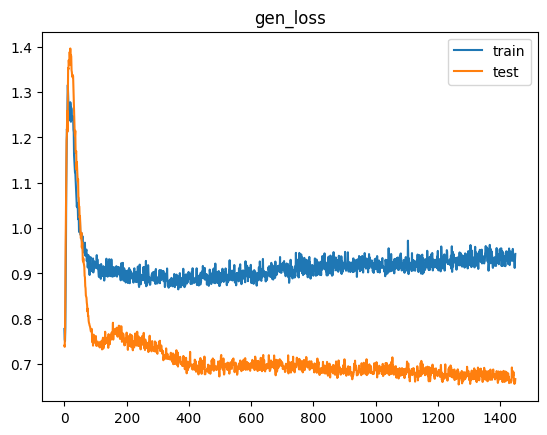

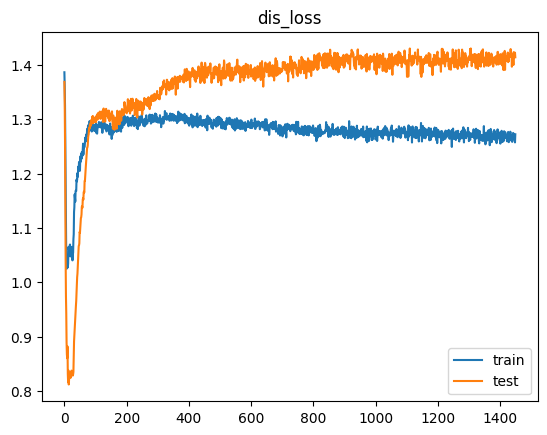

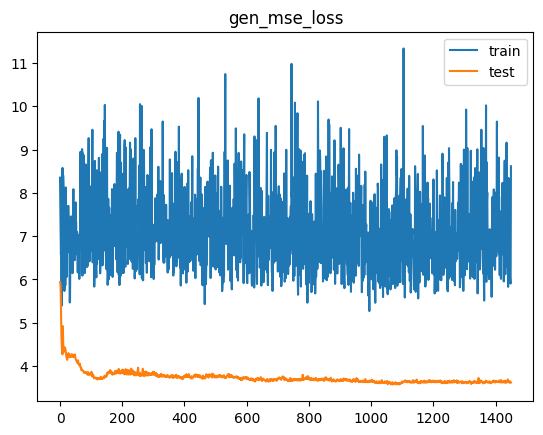

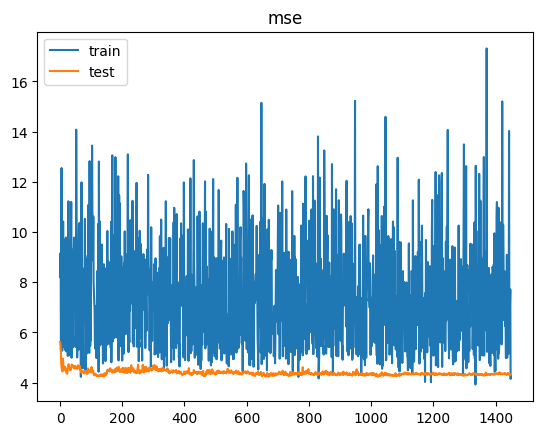

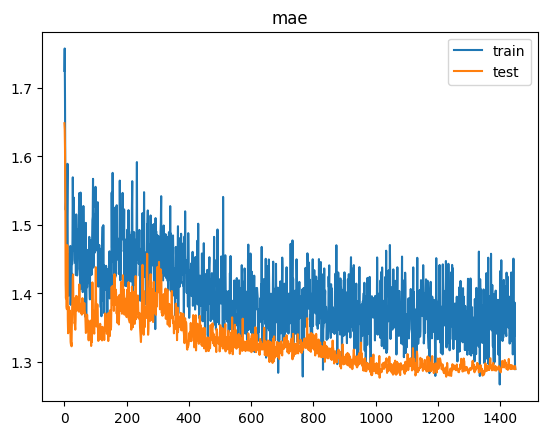

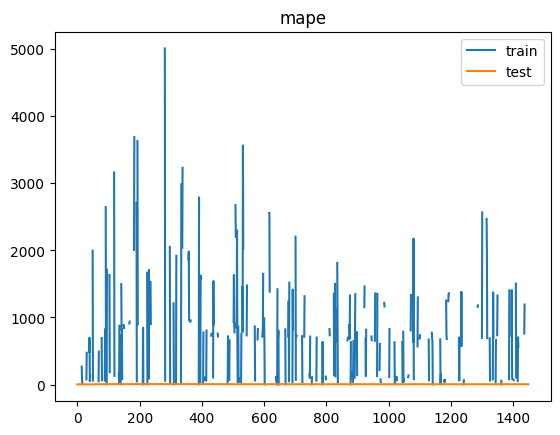

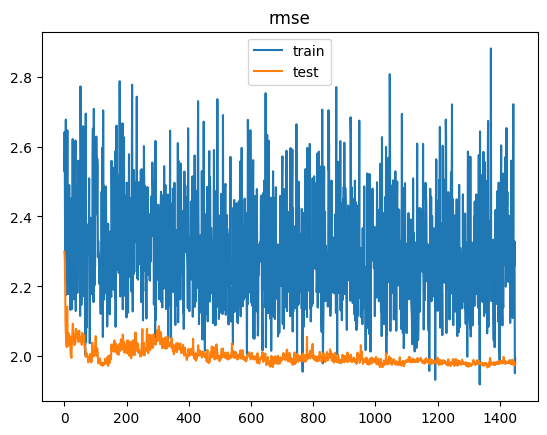

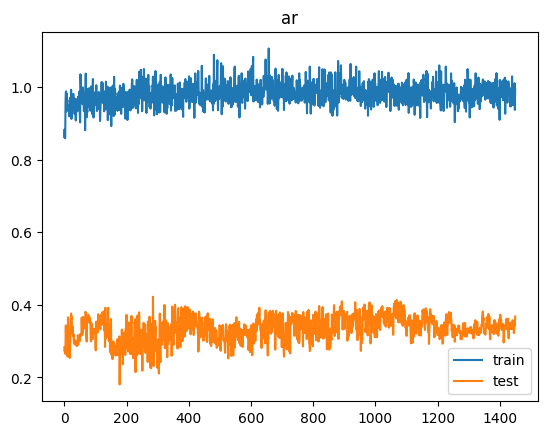

2/2 [==============================] - 0s 5ms/step


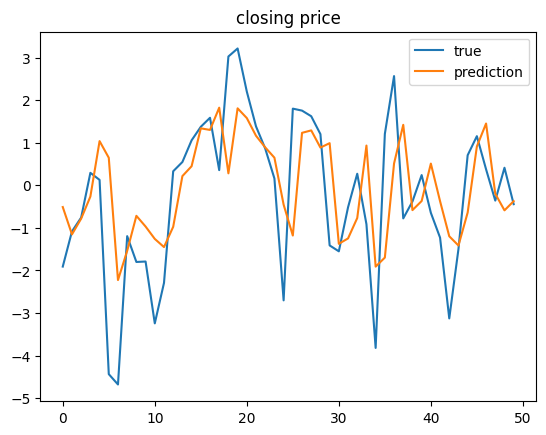

[MSE Baseline] train: 4.379548734286766  test: 4.18451216814071
Delta time with epochs = 1450: 0:21:06.089356


In [20]:
for epochs in [200, 450, 700, 950, 1200, 1450]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("gru_ffnn_epochs_{0}.h5".format(epochs))

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 gru_12 (GRU)                (None, 5, 10)             570       
                                                                 
 batch_normalization_12 (Bat  (None, 5, 10)            40        
 chNormalization)                                                
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_30 (Dropout)        (None, 5, 10)             0         
                                                                 
 gru_13 (GRU)                (None, 10)                660       
                                                           

Time for epoch 53 is 0.9169905185699463 sec Generator Loss: 1.1375569105148315,  Discriminator_loss: 1.1161588430404663
Time for epoch 54 is 0.923358678817749 sec Generator Loss: 1.1285104751586914,  Discriminator_loss: 1.1155626773834229
Time for epoch 55 is 0.9042782783508301 sec Generator Loss: 1.119855284690857,  Discriminator_loss: 1.1147984266281128
Time for epoch 56 is 0.8965151309967041 sec Generator Loss: 1.1229088306427002,  Discriminator_loss: 1.1432809829711914
Time for epoch 57 is 1.0468337535858154 sec Generator Loss: 1.0968209505081177,  Discriminator_loss: 1.1468162536621094
Time for epoch 58 is 0.9559416770935059 sec Generator Loss: 1.0938293933868408,  Discriminator_loss: 1.1537784337997437
Time for epoch 59 is 0.9004366397857666 sec Generator Loss: 1.0803083181381226,  Discriminator_loss: 1.154117226600647
Time for epoch 60 is 0.9018065929412842 sec Generator Loss: 1.076653003692627,  Discriminator_loss: 1.181310772895813
Time for epoch 61 is 0.8724384307861328 sec G

Time for epoch 122 is 0.8011572360992432 sec Generator Loss: 0.9178175330162048,  Discriminator_loss: 1.2826248407363892
Time for epoch 123 is 0.8874244689941406 sec Generator Loss: 0.9183660745620728,  Discriminator_loss: 1.285434365272522
Time for epoch 124 is 0.8074955940246582 sec Generator Loss: 0.9193055629730225,  Discriminator_loss: 1.288170337677002
Time for epoch 125 is 0.7992522716522217 sec Generator Loss: 0.9232619404792786,  Discriminator_loss: 1.277582049369812
Time for epoch 126 is 0.7357053756713867 sec Generator Loss: 0.903789222240448,  Discriminator_loss: 1.287635326385498
Time for epoch 127 is 0.7413370609283447 sec Generator Loss: 0.9498047828674316,  Discriminator_loss: 1.2746891975402832
Time for epoch 128 is 0.7381854057312012 sec Generator Loss: 0.9213657975196838,  Discriminator_loss: 1.2827550172805786
Time for epoch 129 is 0.8117930889129639 sec Generator Loss: 0.9149709343910217,  Discriminator_loss: 1.286313772201538
Time for epoch 130 is 0.78620672225952

Time for epoch 190 is 0.7176909446716309 sec Generator Loss: 0.8784345984458923,  Discriminator_loss: 1.303374171257019
Time for epoch 191 is 0.7332870960235596 sec Generator Loss: 0.9019334316253662,  Discriminator_loss: 1.2971872091293335
Time for epoch 192 is 0.7126936912536621 sec Generator Loss: 0.9113490581512451,  Discriminator_loss: 1.2965781688690186
Time for epoch 193 is 0.7614545822143555 sec Generator Loss: 0.8914678692817688,  Discriminator_loss: 1.2944905757904053
Time for epoch 194 is 0.7583963871002197 sec Generator Loss: 0.8859723210334778,  Discriminator_loss: 1.2928065061569214
Time for epoch 195 is 0.8391482830047607 sec Generator Loss: 0.8961308002471924,  Discriminator_loss: 1.302535057067871
Time for epoch 196 is 0.742243766784668 sec Generator Loss: 0.8840463161468506,  Discriminator_loss: 1.302400827407837
Time for epoch 197 is 0.7353417873382568 sec Generator Loss: 0.9030195474624634,  Discriminator_loss: 1.2873939275741577
Time for epoch 198 is 0.766645669937

Time for epoch 259 is 0.7293186187744141 sec Generator Loss: 0.8910790085792542,  Discriminator_loss: 1.2931638956069946
Time for epoch 260 is 0.7440693378448486 sec Generator Loss: 0.8974448442459106,  Discriminator_loss: 1.2913633584976196
Time for epoch 261 is 0.7317371368408203 sec Generator Loss: 0.9076172709465027,  Discriminator_loss: 1.2833189964294434
Time for epoch 262 is 0.7899825572967529 sec Generator Loss: 0.8893242478370667,  Discriminator_loss: 1.2898542881011963
Time for epoch 263 is 0.7173738479614258 sec Generator Loss: 0.8899034261703491,  Discriminator_loss: 1.294958472251892
Time for epoch 264 is 0.7164657115936279 sec Generator Loss: 0.8981589078903198,  Discriminator_loss: 1.292931318283081
Time for epoch 265 is 0.7188060283660889 sec Generator Loss: 0.9013211131095886,  Discriminator_loss: 1.291332483291626
Time for epoch 266 is 0.852266788482666 sec Generator Loss: 0.8926310539245605,  Discriminator_loss: 1.3007227182388306
Time for epoch 267 is 0.847322225570

Time for epoch 327 is 0.7609739303588867 sec Generator Loss: 0.8874247074127197,  Discriminator_loss: 1.2949817180633545
Time for epoch 328 is 0.7684955596923828 sec Generator Loss: 0.9094710350036621,  Discriminator_loss: 1.2929784059524536
Time for epoch 329 is 0.7269487380981445 sec Generator Loss: 0.9013142585754395,  Discriminator_loss: 1.2841989994049072
Time for epoch 330 is 0.7543864250183105 sec Generator Loss: 0.8967180252075195,  Discriminator_loss: 1.2873210906982422
Time for epoch 331 is 0.7323508262634277 sec Generator Loss: 0.8934356570243835,  Discriminator_loss: 1.288155198097229
Time for epoch 332 is 0.7220582962036133 sec Generator Loss: 0.8922809362411499,  Discriminator_loss: 1.292536735534668
Time for epoch 333 is 0.7327389717102051 sec Generator Loss: 0.9102482199668884,  Discriminator_loss: 1.2870063781738281
Time for epoch 334 is 0.7636134624481201 sec Generator Loss: 0.9138388633728027,  Discriminator_loss: 1.2780284881591797
Time for epoch 335 is 0.7301645278

Time for epoch 395 is 0.7236223220825195 sec Generator Loss: 0.9039978384971619,  Discriminator_loss: 1.278715968132019
Time for epoch 396 is 0.7409148216247559 sec Generator Loss: 0.909355878829956,  Discriminator_loss: 1.2781459093093872
Time for epoch 397 is 0.7512927055358887 sec Generator Loss: 0.9173501133918762,  Discriminator_loss: 1.2736985683441162
Time for epoch 398 is 0.7176997661590576 sec Generator Loss: 0.9207006692886353,  Discriminator_loss: 1.2798305749893188
Time for epoch 399 is 0.7368643283843994 sec Generator Loss: 0.8999148011207581,  Discriminator_loss: 1.2810097932815552
Time for epoch 400 is 0.7456684112548828 sec Generator Loss: 0.9013681411743164,  Discriminator_loss: 1.2812294960021973
Time for epoch 401 is 0.7282912731170654 sec Generator Loss: 0.9341000914573669,  Discriminator_loss: 1.2780438661575317
Time for epoch 402 is 0.7362661361694336 sec Generator Loss: 0.918548047542572,  Discriminator_loss: 1.2813565731048584
Time for epoch 403 is 0.73994874954

Time for epoch 464 is 0.7915177345275879 sec Generator Loss: 0.9074493050575256,  Discriminator_loss: 1.2864158153533936
Time for epoch 465 is 0.781968355178833 sec Generator Loss: 0.9271265864372253,  Discriminator_loss: 1.2838317155838013
Time for epoch 466 is 0.7661945819854736 sec Generator Loss: 0.9091833829879761,  Discriminator_loss: 1.2810649871826172
Time for epoch 467 is 0.7765023708343506 sec Generator Loss: 0.9204418659210205,  Discriminator_loss: 1.2796781063079834
Time for epoch 468 is 0.7507247924804688 sec Generator Loss: 0.9040930867195129,  Discriminator_loss: 1.2931607961654663
Time for epoch 469 is 0.7442514896392822 sec Generator Loss: 0.9064406752586365,  Discriminator_loss: 1.2880462408065796
Time for epoch 470 is 0.7823576927185059 sec Generator Loss: 0.90901118516922,  Discriminator_loss: 1.2818503379821777
Time for epoch 471 is 0.7516136169433594 sec Generator Loss: 0.9027386903762817,  Discriminator_loss: 1.2812199592590332
Time for epoch 472 is 0.76357269287

Time for epoch 532 is 0.7679500579833984 sec Generator Loss: 0.898097038269043,  Discriminator_loss: 1.2858341932296753
Time for epoch 533 is 0.7508811950683594 sec Generator Loss: 0.8940373063087463,  Discriminator_loss: 1.290587067604065
Time for epoch 534 is 0.7915980815887451 sec Generator Loss: 0.9034292101860046,  Discriminator_loss: 1.2978819608688354
Time for epoch 535 is 0.7560722827911377 sec Generator Loss: 0.8892607092857361,  Discriminator_loss: 1.2885332107543945
Time for epoch 536 is 0.7709033489227295 sec Generator Loss: 0.8827041983604431,  Discriminator_loss: 1.2971152067184448
Time for epoch 537 is 0.7495293617248535 sec Generator Loss: 0.9171529412269592,  Discriminator_loss: 1.2905175685882568
Time for epoch 538 is 0.8009903430938721 sec Generator Loss: 0.8887377381324768,  Discriminator_loss: 1.2936146259307861
Time for epoch 539 is 0.8313336372375488 sec Generator Loss: 0.8925909399986267,  Discriminator_loss: 1.289054274559021
Time for epoch 540 is 0.80091977119

Time for epoch 600 is 0.8204410076141357 sec Generator Loss: 0.9008108377456665,  Discriminator_loss: 1.2913635969161987
Time for epoch 601 is 0.7524216175079346 sec Generator Loss: 0.9172542095184326,  Discriminator_loss: 1.283667802810669
Time for epoch 602 is 0.7982337474822998 sec Generator Loss: 0.9191746115684509,  Discriminator_loss: 1.2914478778839111
Time for epoch 603 is 0.8231005668640137 sec Generator Loss: 0.918635368347168,  Discriminator_loss: 1.2846683263778687
Time for epoch 604 is 0.7656311988830566 sec Generator Loss: 0.9289065599441528,  Discriminator_loss: 1.2767341136932373
Time for epoch 605 is 0.7767696380615234 sec Generator Loss: 0.9042390584945679,  Discriminator_loss: 1.290923833847046
Time for epoch 606 is 0.8308095932006836 sec Generator Loss: 0.9002536535263062,  Discriminator_loss: 1.2940565347671509
Time for epoch 607 is 0.7715296745300293 sec Generator Loss: 0.9276790618896484,  Discriminator_loss: 1.2820806503295898
Time for epoch 608 is 0.81585764884

Time for epoch 668 is 0.7864484786987305 sec Generator Loss: 0.9053411483764648,  Discriminator_loss: 1.2932289838790894
Time for epoch 669 is 0.7601909637451172 sec Generator Loss: 0.9054269790649414,  Discriminator_loss: 1.2775027751922607
Time for epoch 670 is 0.7811908721923828 sec Generator Loss: 0.9094104766845703,  Discriminator_loss: 1.2866747379302979
Time for epoch 671 is 0.775517463684082 sec Generator Loss: 0.9204784035682678,  Discriminator_loss: 1.2845706939697266
Time for epoch 672 is 0.7913358211517334 sec Generator Loss: 0.9004846811294556,  Discriminator_loss: 1.2938305139541626
Time for epoch 673 is 0.7565591335296631 sec Generator Loss: 0.9251261949539185,  Discriminator_loss: 1.2765437364578247
Time for epoch 674 is 0.7596781253814697 sec Generator Loss: 0.9135716557502747,  Discriminator_loss: 1.2753146886825562
Time for epoch 675 is 0.7768714427947998 sec Generator Loss: 0.9439030289649963,  Discriminator_loss: 1.2728527784347534
Time for epoch 676 is 0.767674207

Time for epoch 736 is 0.7547152042388916 sec Generator Loss: 0.9341443777084351,  Discriminator_loss: 1.277768850326538
Time for epoch 737 is 0.7331380844116211 sec Generator Loss: 0.9279147982597351,  Discriminator_loss: 1.2677741050720215
Time for epoch 738 is 0.7493784427642822 sec Generator Loss: 0.9098690748214722,  Discriminator_loss: 1.2801192998886108
Time for epoch 739 is 0.7511684894561768 sec Generator Loss: 0.922930121421814,  Discriminator_loss: 1.2828328609466553
Time for epoch 740 is 0.7836129665374756 sec Generator Loss: 0.91041499376297,  Discriminator_loss: 1.284827470779419
Time for epoch 741 is 0.7600176334381104 sec Generator Loss: 0.9047999382019043,  Discriminator_loss: 1.2804272174835205
Time for epoch 742 is 0.7547454833984375 sec Generator Loss: 0.9227079749107361,  Discriminator_loss: 1.2821166515350342
Time for epoch 743 is 0.7632431983947754 sec Generator Loss: 0.9233900904655457,  Discriminator_loss: 1.2712112665176392
Time for epoch 744 is 0.7503609657287

Time for epoch 805 is 0.7655918598175049 sec Generator Loss: 0.9287306070327759,  Discriminator_loss: 1.269006371498108
Time for epoch 806 is 0.7768557071685791 sec Generator Loss: 0.9245843291282654,  Discriminator_loss: 1.2755036354064941
Time for epoch 807 is 0.7500040531158447 sec Generator Loss: 0.9064229726791382,  Discriminator_loss: 1.2756508588790894
Time for epoch 808 is 0.8100535869598389 sec Generator Loss: 0.9303988814353943,  Discriminator_loss: 1.287680983543396
Time for epoch 809 is 0.8179097175598145 sec Generator Loss: 0.9233137965202332,  Discriminator_loss: 1.2708113193511963
Time for epoch 810 is 0.8134324550628662 sec Generator Loss: 0.9127012491226196,  Discriminator_loss: 1.2812397480010986
Time for epoch 811 is 0.809880256652832 sec Generator Loss: 0.9118607044219971,  Discriminator_loss: 1.2775720357894897
Time for epoch 812 is 0.8218412399291992 sec Generator Loss: 0.9241394400596619,  Discriminator_loss: 1.2757080793380737
Time for epoch 813 is 0.78780269622

Time for epoch 873 is 0.7941346168518066 sec Generator Loss: 0.9422838091850281,  Discriminator_loss: 1.265933871269226
Time for epoch 874 is 0.7649407386779785 sec Generator Loss: 0.9299188852310181,  Discriminator_loss: 1.2610024213790894
Time for epoch 875 is 0.8111329078674316 sec Generator Loss: 0.9465787410736084,  Discriminator_loss: 1.2873239517211914
Time for epoch 876 is 0.7758674621582031 sec Generator Loss: 0.9211649298667908,  Discriminator_loss: 1.2849745750427246
Time for epoch 877 is 0.8289139270782471 sec Generator Loss: 0.925660252571106,  Discriminator_loss: 1.2743905782699585
Time for epoch 878 is 0.7711985111236572 sec Generator Loss: 0.92234206199646,  Discriminator_loss: 1.2802733182907104
Time for epoch 879 is 0.8186872005462646 sec Generator Loss: 0.9107510447502136,  Discriminator_loss: 1.29179048538208
Time for epoch 880 is 0.7829380035400391 sec Generator Loss: 0.922244668006897,  Discriminator_loss: 1.2732930183410645
Time for epoch 881 is 0.773082971572876

Time for epoch 942 is 0.7381665706634521 sec Generator Loss: 0.9491211771965027,  Discriminator_loss: 1.2619558572769165
Time for epoch 943 is 0.7856643199920654 sec Generator Loss: 0.9738450050354004,  Discriminator_loss: 1.2623652219772339
Time for epoch 944 is 0.7611045837402344 sec Generator Loss: 0.9313651323318481,  Discriminator_loss: 1.2640115022659302
Time for epoch 945 is 0.750906229019165 sec Generator Loss: 0.9334084391593933,  Discriminator_loss: 1.269869327545166
Time for epoch 946 is 0.7380955219268799 sec Generator Loss: 0.9314686059951782,  Discriminator_loss: 1.2689751386642456
Time for epoch 947 is 0.7338886260986328 sec Generator Loss: 0.9413014054298401,  Discriminator_loss: 1.265467882156372
Time for epoch 948 is 0.7561066150665283 sec Generator Loss: 0.9428901672363281,  Discriminator_loss: 1.2670267820358276
Time for epoch 949 is 0.7488219738006592 sec Generator Loss: 0.9290503859519958,  Discriminator_loss: 1.2743263244628906
Time for epoch 950 is 0.76581192016

Time for epoch 1010 is 0.7427158355712891 sec Generator Loss: 0.9418467879295349,  Discriminator_loss: 1.2638041973114014
Time for epoch 1011 is 0.7305631637573242 sec Generator Loss: 0.9293185472488403,  Discriminator_loss: 1.2743200063705444
Time for epoch 1012 is 0.7196574211120605 sec Generator Loss: 0.9271471500396729,  Discriminator_loss: 1.2736334800720215
Time for epoch 1013 is 0.7272171974182129 sec Generator Loss: 0.9326558709144592,  Discriminator_loss: 1.2682268619537354
Time for epoch 1014 is 0.7225058078765869 sec Generator Loss: 0.9341447353363037,  Discriminator_loss: 1.2832657098770142
Time for epoch 1015 is 0.7530741691589355 sec Generator Loss: 0.9581313133239746,  Discriminator_loss: 1.273343801498413
Time for epoch 1016 is 0.7399210929870605 sec Generator Loss: 0.9224537014961243,  Discriminator_loss: 1.2759251594543457
Time for epoch 1017 is 0.7493436336517334 sec Generator Loss: 0.9352292418479919,  Discriminator_loss: 1.2699660062789917
Time for epoch 1018 is 0.

Time for epoch 1078 is 0.7883820533752441 sec Generator Loss: 0.9558626413345337,  Discriminator_loss: 1.2573039531707764
Time for epoch 1079 is 0.8068337440490723 sec Generator Loss: 0.9427564144134521,  Discriminator_loss: 1.2743428945541382
Time for epoch 1080 is 0.7937712669372559 sec Generator Loss: 0.9446402192115784,  Discriminator_loss: 1.2641351222991943
Time for epoch 1081 is 0.7931077480316162 sec Generator Loss: 0.9337625503540039,  Discriminator_loss: 1.268925428390503
Time for epoch 1082 is 0.7795460224151611 sec Generator Loss: 0.9456508159637451,  Discriminator_loss: 1.2518337965011597
Time for epoch 1083 is 0.7675786018371582 sec Generator Loss: 0.9396748542785645,  Discriminator_loss: 1.2508623600006104
Time for epoch 1084 is 0.7741124629974365 sec Generator Loss: 0.9248455762863159,  Discriminator_loss: 1.2659128904342651
Time for epoch 1085 is 0.8298344612121582 sec Generator Loss: 0.946601927280426,  Discriminator_loss: 1.2676438093185425
Time for epoch 1086 is 0.8

Time for epoch 1146 is 0.8176164627075195 sec Generator Loss: 0.9488314390182495,  Discriminator_loss: 1.2662800550460815
Time for epoch 1147 is 0.7936885356903076 sec Generator Loss: 0.9519261121749878,  Discriminator_loss: 1.265383005142212
Time for epoch 1148 is 0.7545952796936035 sec Generator Loss: 0.9326643943786621,  Discriminator_loss: 1.265764832496643
Time for epoch 1149 is 0.7443351745605469 sec Generator Loss: 0.9330753684043884,  Discriminator_loss: 1.2638216018676758
Time for epoch 1150 is 0.7486100196838379 sec Generator Loss: 0.952630341053009,  Discriminator_loss: 1.2644712924957275
Time for epoch 1151 is 0.7773611545562744 sec Generator Loss: 0.9468976855278015,  Discriminator_loss: 1.2668237686157227
Time for epoch 1152 is 0.752732515335083 sec Generator Loss: 0.9418870210647583,  Discriminator_loss: 1.250309944152832
Time for epoch 1153 is 0.8059089183807373 sec Generator Loss: 0.9518866539001465,  Discriminator_loss: 1.2568144798278809
Time for epoch 1154 is 0.8009

Time for epoch 1214 is 0.7332332134246826 sec Generator Loss: 0.9570906162261963,  Discriminator_loss: 1.2510254383087158
Time for epoch 1215 is 0.745525598526001 sec Generator Loss: 0.9434531331062317,  Discriminator_loss: 1.262834906578064
Time for epoch 1216 is 0.831958532333374 sec Generator Loss: 0.934301495552063,  Discriminator_loss: 1.2683145999908447
Time for epoch 1217 is 0.819751501083374 sec Generator Loss: 0.9368480443954468,  Discriminator_loss: 1.2626391649246216
Time for epoch 1218 is 0.7251970767974854 sec Generator Loss: 0.9463167190551758,  Discriminator_loss: 1.2600271701812744
Time for epoch 1219 is 0.8455417156219482 sec Generator Loss: 0.9572232961654663,  Discriminator_loss: 1.249971628189087
Time for epoch 1220 is 0.7266950607299805 sec Generator Loss: 0.9395913481712341,  Discriminator_loss: 1.263290524482727
Time for epoch 1221 is 0.7344174385070801 sec Generator Loss: 0.93635493516922,  Discriminator_loss: 1.2630497217178345
Time for epoch 1222 is 0.84338784

Time for epoch 1282 is 0.7662672996520996 sec Generator Loss: 0.9598588943481445,  Discriminator_loss: 1.254373550415039
Time for epoch 1283 is 0.7810850143432617 sec Generator Loss: 0.9616774916648865,  Discriminator_loss: 1.252512812614441
Time for epoch 1284 is 0.7665314674377441 sec Generator Loss: 0.9391545653343201,  Discriminator_loss: 1.250664234161377
Time for epoch 1285 is 0.7497663497924805 sec Generator Loss: 0.9414222240447998,  Discriminator_loss: 1.261635661125183
Time for epoch 1286 is 0.9151012897491455 sec Generator Loss: 0.9616352915763855,  Discriminator_loss: 1.2500790357589722
Time for epoch 1287 is 0.7849457263946533 sec Generator Loss: 0.9496248960494995,  Discriminator_loss: 1.2525933980941772
Time for epoch 1288 is 0.7820026874542236 sec Generator Loss: 0.9564995169639587,  Discriminator_loss: 1.253688931465149
Time for epoch 1289 is 0.7644534111022949 sec Generator Loss: 0.9519658088684082,  Discriminator_loss: 1.2590457201004028
Time for epoch 1290 is 0.8258

Time for epoch 1350 is 0.9513990879058838 sec Generator Loss: 0.9441154599189758,  Discriminator_loss: 1.2608453035354614
Time for epoch 1351 is 0.7856793403625488 sec Generator Loss: 0.966391921043396,  Discriminator_loss: 1.2628703117370605
Time for epoch 1352 is 0.759056806564331 sec Generator Loss: 0.9756342768669128,  Discriminator_loss: 1.2604390382766724
Time for epoch 1353 is 0.7829852104187012 sec Generator Loss: 0.9456148147583008,  Discriminator_loss: 1.2602267265319824
Time for epoch 1354 is 0.8335356712341309 sec Generator Loss: 0.947020947933197,  Discriminator_loss: 1.2551535367965698
Time for epoch 1355 is 0.7690463066101074 sec Generator Loss: 0.9524406790733337,  Discriminator_loss: 1.263122320175171
Time for epoch 1356 is 0.7654173374176025 sec Generator Loss: 0.94914311170578,  Discriminator_loss: 1.2576149702072144
Time for epoch 1357 is 0.7575263977050781 sec Generator Loss: 0.959316611289978,  Discriminator_loss: 1.2568246126174927
Time for epoch 1358 is 0.806564

Time for epoch 1418 is 0.8278000354766846 sec Generator Loss: 0.9599512815475464,  Discriminator_loss: 1.2481173276901245
Time for epoch 1419 is 0.8197445869445801 sec Generator Loss: 0.957116425037384,  Discriminator_loss: 1.243233561515808
Time for epoch 1420 is 0.8812863826751709 sec Generator Loss: 0.9411765336990356,  Discriminator_loss: 1.255732774734497
Time for epoch 1421 is 0.9090936183929443 sec Generator Loss: 0.9441090822219849,  Discriminator_loss: 1.2596007585525513
Time for epoch 1422 is 1.214010238647461 sec Generator Loss: 0.9581183791160583,  Discriminator_loss: 1.2458722591400146
Time for epoch 1423 is 0.8397724628448486 sec Generator Loss: 0.941777765750885,  Discriminator_loss: 1.2533806562423706
Time for epoch 1424 is 0.8231122493743896 sec Generator Loss: 0.9511672854423523,  Discriminator_loss: 1.2501789331436157
Time for epoch 1425 is 0.8190968036651611 sec Generator Loss: 0.9515475630760193,  Discriminator_loss: 1.2411859035491943
Time for epoch 1426 is 0.8575

Time for epoch 1486 is 0.76318359375 sec Generator Loss: 0.9594895243644714,  Discriminator_loss: 1.2524350881576538
Time for epoch 1487 is 0.7781140804290771 sec Generator Loss: 0.9630146622657776,  Discriminator_loss: 1.2378655672073364
Time for epoch 1488 is 0.8020329475402832 sec Generator Loss: 0.9548162221908569,  Discriminator_loss: 1.2500724792480469
Time for epoch 1489 is 0.7760560512542725 sec Generator Loss: 0.962641179561615,  Discriminator_loss: 1.2580986022949219
Time for epoch 1490 is 0.782463788986206 sec Generator Loss: 0.9446847438812256,  Discriminator_loss: 1.2492375373840332
Time for epoch 1491 is 0.7569875717163086 sec Generator Loss: 0.9572769999504089,  Discriminator_loss: 1.2527849674224854
Time for epoch 1492 is 0.7624335289001465 sec Generator Loss: 0.9548012018203735,  Discriminator_loss: 1.2523305416107178
Time for epoch 1493 is 0.760155439376831 sec Generator Loss: 0.9506189823150635,  Discriminator_loss: 1.2671496868133545
Time for epoch 1494 is 0.7949857

Time for epoch 1554 is 0.75553297996521 sec Generator Loss: 0.9590851068496704,  Discriminator_loss: 1.254440188407898
Time for epoch 1555 is 0.857330322265625 sec Generator Loss: 0.982469916343689,  Discriminator_loss: 1.2491581439971924
Time for epoch 1556 is 0.8250000476837158 sec Generator Loss: 0.9649162292480469,  Discriminator_loss: 1.2493847608566284
Time for epoch 1557 is 0.8583464622497559 sec Generator Loss: 0.9432878494262695,  Discriminator_loss: 1.2540109157562256
Time for epoch 1558 is 0.8338561058044434 sec Generator Loss: 0.9653202295303345,  Discriminator_loss: 1.2470496892929077
Time for epoch 1559 is 0.7975084781646729 sec Generator Loss: 0.9582436084747314,  Discriminator_loss: 1.2412049770355225
Time for epoch 1560 is 0.7947156429290771 sec Generator Loss: 0.9499607086181641,  Discriminator_loss: 1.2480305433273315
Time for epoch 1561 is 0.7949705123901367 sec Generator Loss: 0.9484661817550659,  Discriminator_loss: 1.2544509172439575
Time for epoch 1562 is 1.4831

Time for epoch 1622 is 0.8280143737792969 sec Generator Loss: 0.9508387446403503,  Discriminator_loss: 1.2502000331878662
Time for epoch 1623 is 0.7294661998748779 sec Generator Loss: 0.97426438331604,  Discriminator_loss: 1.241518259048462
Time for epoch 1624 is 0.737079381942749 sec Generator Loss: 0.9511929154396057,  Discriminator_loss: 1.2597929239273071
Time for epoch 1625 is 0.732276201248169 sec Generator Loss: 0.9569017887115479,  Discriminator_loss: 1.239065170288086
Time for epoch 1626 is 0.7267005443572998 sec Generator Loss: 0.9411550760269165,  Discriminator_loss: 1.267539143562317
Time for epoch 1627 is 0.741823673248291 sec Generator Loss: 0.9402430057525635,  Discriminator_loss: 1.256730079650879
Time for epoch 1628 is 0.7944705486297607 sec Generator Loss: 0.958321213722229,  Discriminator_loss: 1.2464544773101807
Time for epoch 1629 is 0.7752161026000977 sec Generator Loss: 0.9659826159477234,  Discriminator_loss: 1.2441514730453491
Time for epoch 1630 is 0.772688627

Time for epoch 1690 is 0.8770737648010254 sec Generator Loss: 0.954162061214447,  Discriminator_loss: 1.2554277181625366
Time for epoch 1691 is 0.7864997386932373 sec Generator Loss: 0.9473117589950562,  Discriminator_loss: 1.2523990869522095
Time for epoch 1692 is 0.7528700828552246 sec Generator Loss: 0.9412891268730164,  Discriminator_loss: 1.2525562047958374
Time for epoch 1693 is 0.7618811130523682 sec Generator Loss: 0.9636822938919067,  Discriminator_loss: 1.254077672958374
Time for epoch 1694 is 0.7766001224517822 sec Generator Loss: 0.9520624279975891,  Discriminator_loss: 1.2513688802719116
Time for epoch 1695 is 0.7969794273376465 sec Generator Loss: 0.9571695327758789,  Discriminator_loss: 1.2571395635604858
Time for epoch 1696 is 0.7617635726928711 sec Generator Loss: 0.974125325679779,  Discriminator_loss: 1.25421941280365
Time for epoch 1697 is 0.7340958118438721 sec Generator Loss: 0.9433413147926331,  Discriminator_loss: 1.2605998516082764
Time for epoch 1698 is 0.7445

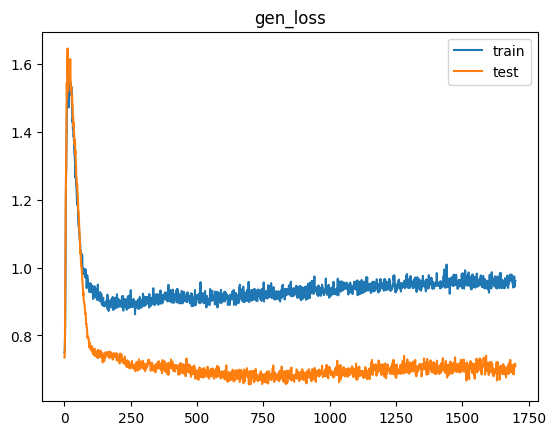

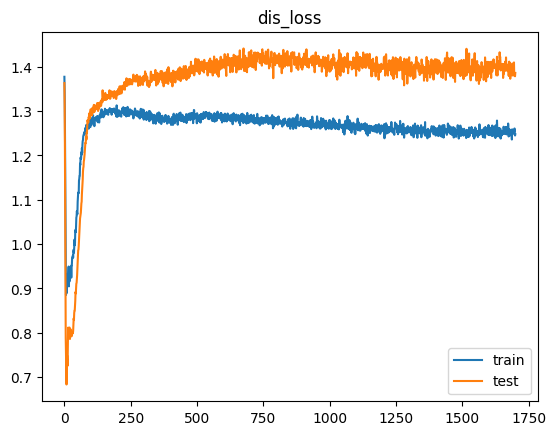

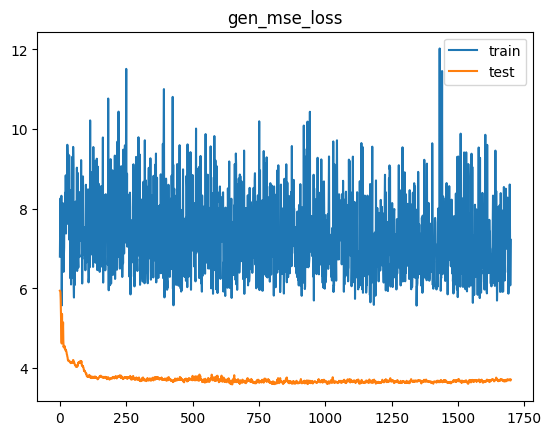

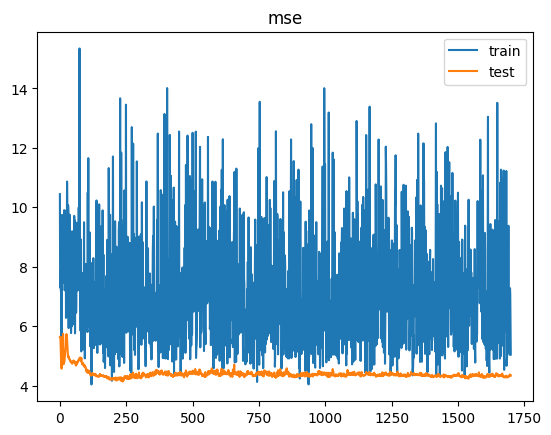

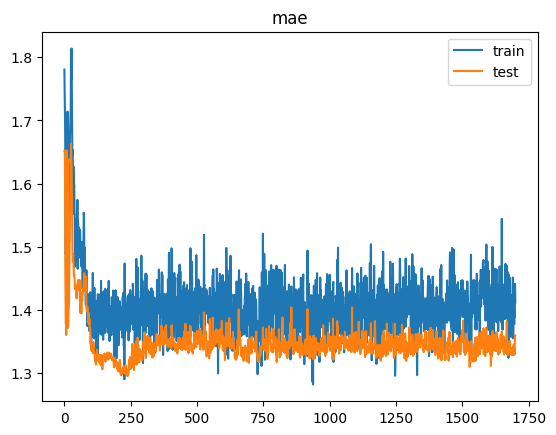

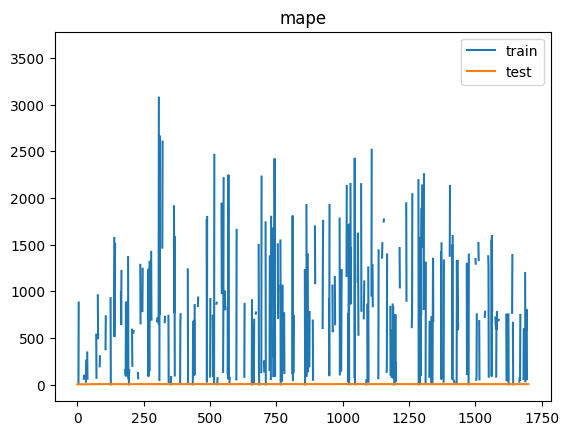

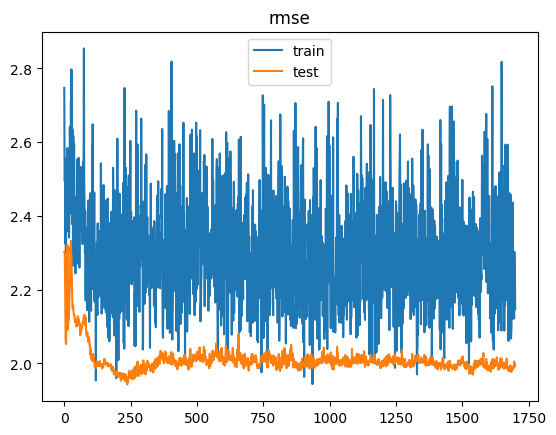

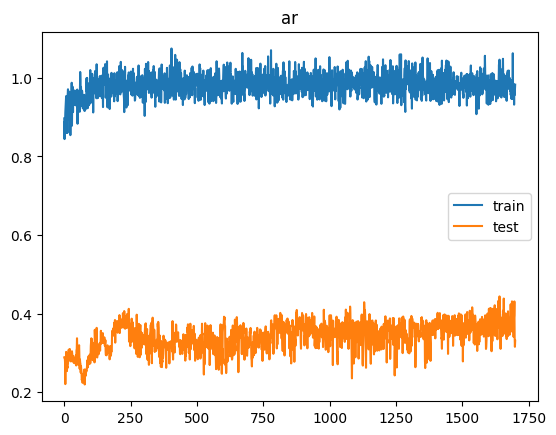

2/2 [==============================] - 0s 3ms/step


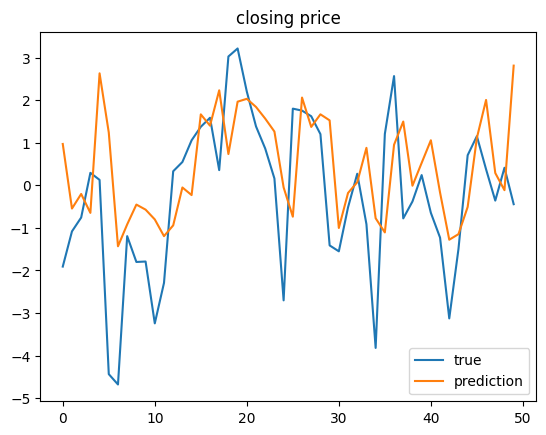

[MSE Baseline] train: 9.225079298121557  test: 4.18451216814071
Delta time with epochs = 1700: 0:22:55.358234
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 5, 7)]            0         
                                                                 
 gru_14 (GRU)                (None, 5, 10)             570       
                                                                 
 batch_normalization_14 (Bat  (None, 5, 10)            40        
 chNormalization)                                                
                                                                 
 leaky_re_lu_42 (LeakyReLU)  (None, 5, 10)             0         
                                                                 
 dropout_35 (Dropout)        (None, 5, 10)             0         
                                                                 
 gru_15 (GRU)  

Time for epoch 52 is 0.7695810794830322 sec Generator Loss: 0.9503013491630554,  Discriminator_loss: 1.2659215927124023
Time for epoch 53 is 0.7824857234954834 sec Generator Loss: 0.9187812805175781,  Discriminator_loss: 1.2508200407028198
Time for epoch 54 is 0.8035578727722168 sec Generator Loss: 0.9122335910797119,  Discriminator_loss: 1.2549715042114258
Time for epoch 55 is 0.7628457546234131 sec Generator Loss: 0.9307480454444885,  Discriminator_loss: 1.2618885040283203
Time for epoch 56 is 0.7958674430847168 sec Generator Loss: 0.9355055689811707,  Discriminator_loss: 1.257595419883728
Time for epoch 57 is 0.7790207862854004 sec Generator Loss: 0.936937153339386,  Discriminator_loss: 1.2624183893203735
Time for epoch 58 is 0.7413351535797119 sec Generator Loss: 0.9264622330665588,  Discriminator_loss: 1.257596731185913
Time for epoch 59 is 0.8256077766418457 sec Generator Loss: 0.9136890172958374,  Discriminator_loss: 1.2669857740402222
Time for epoch 60 is 0.8535952568054199 sec

Time for epoch 121 is 0.7879858016967773 sec Generator Loss: 0.8576486110687256,  Discriminator_loss: 1.307586669921875
Time for epoch 122 is 0.800473690032959 sec Generator Loss: 0.8717725872993469,  Discriminator_loss: 1.3186744451522827
Time for epoch 123 is 0.7972719669342041 sec Generator Loss: 0.8590331673622131,  Discriminator_loss: 1.3117741346359253
Time for epoch 124 is 0.8000586032867432 sec Generator Loss: 0.857582151889801,  Discriminator_loss: 1.3052852153778076
Time for epoch 125 is 0.7864456176757812 sec Generator Loss: 0.8869903087615967,  Discriminator_loss: 1.3067467212677002
Time for epoch 126 is 0.782198429107666 sec Generator Loss: 0.8513796925544739,  Discriminator_loss: 1.309699296951294
Time for epoch 127 is 0.8048474788665771 sec Generator Loss: 0.8649288415908813,  Discriminator_loss: 1.306087613105774
Time for epoch 128 is 0.7827062606811523 sec Generator Loss: 0.8789453506469727,  Discriminator_loss: 1.3020929098129272
Time for epoch 129 is 0.75322389602661

Time for epoch 190 is 0.7752058506011963 sec Generator Loss: 0.8983797430992126,  Discriminator_loss: 1.2811133861541748
Time for epoch 191 is 0.7650954723358154 sec Generator Loss: 0.9072997570037842,  Discriminator_loss: 1.2839328050613403
Time for epoch 192 is 0.7971560955047607 sec Generator Loss: 0.9025043845176697,  Discriminator_loss: 1.2826558351516724
Time for epoch 193 is 0.7616498470306396 sec Generator Loss: 0.9264928102493286,  Discriminator_loss: 1.2712197303771973
Time for epoch 194 is 0.8052058219909668 sec Generator Loss: 0.9267547726631165,  Discriminator_loss: 1.276820421218872
Time for epoch 195 is 0.7748644351959229 sec Generator Loss: 0.9072695970535278,  Discriminator_loss: 1.2781847715377808
Time for epoch 196 is 0.7480859756469727 sec Generator Loss: 0.9202728867530823,  Discriminator_loss: 1.2776308059692383
Time for epoch 197 is 0.7635476589202881 sec Generator Loss: 0.8997929096221924,  Discriminator_loss: 1.28067946434021
Time for epoch 198 is 0.76566672325

Time for epoch 258 is 0.7400548458099365 sec Generator Loss: 0.8807376623153687,  Discriminator_loss: 1.303483486175537
Time for epoch 259 is 0.7275781631469727 sec Generator Loss: 0.8751983642578125,  Discriminator_loss: 1.288487434387207
Time for epoch 260 is 0.7436938285827637 sec Generator Loss: 0.9134712219238281,  Discriminator_loss: 1.2947367429733276
Time for epoch 261 is 0.7354686260223389 sec Generator Loss: 0.8904528021812439,  Discriminator_loss: 1.292979121208191
Time for epoch 262 is 0.7565431594848633 sec Generator Loss: 0.8821670413017273,  Discriminator_loss: 1.2935516834259033
Time for epoch 263 is 0.7810652256011963 sec Generator Loss: 0.8927354216575623,  Discriminator_loss: 1.3028591871261597
Time for epoch 264 is 0.7386581897735596 sec Generator Loss: 0.8936297297477722,  Discriminator_loss: 1.2965625524520874
Time for epoch 265 is 0.7270293235778809 sec Generator Loss: 0.9010754227638245,  Discriminator_loss: 1.2972480058670044
Time for epoch 266 is 0.73726415634

Time for epoch 326 is 0.7280936241149902 sec Generator Loss: 0.8998129963874817,  Discriminator_loss: 1.2990126609802246
Time for epoch 327 is 0.7850773334503174 sec Generator Loss: 0.8897543549537659,  Discriminator_loss: 1.2958024740219116
Time for epoch 328 is 0.7284481525421143 sec Generator Loss: 0.9055226445198059,  Discriminator_loss: 1.2866159677505493
Time for epoch 329 is 0.752798318862915 sec Generator Loss: 0.8973696231842041,  Discriminator_loss: 1.2976733446121216
Time for epoch 330 is 0.7431282997131348 sec Generator Loss: 0.8950409889221191,  Discriminator_loss: 1.2906016111373901
Time for epoch 331 is 0.740699052810669 sec Generator Loss: 0.8974221348762512,  Discriminator_loss: 1.2925405502319336
Time for epoch 332 is 0.7327291965484619 sec Generator Loss: 0.893705427646637,  Discriminator_loss: 1.2899209260940552
Time for epoch 333 is 0.770643949508667 sec Generator Loss: 0.8886322975158691,  Discriminator_loss: 1.300901174545288
Time for epoch 334 is 0.7660212516784

Time for epoch 394 is 0.7708852291107178 sec Generator Loss: 0.8937125205993652,  Discriminator_loss: 1.288979411125183
Time for epoch 395 is 0.7865805625915527 sec Generator Loss: 0.9092085361480713,  Discriminator_loss: 1.2806705236434937
Time for epoch 396 is 0.7913367748260498 sec Generator Loss: 0.9141674637794495,  Discriminator_loss: 1.2918758392333984
Time for epoch 397 is 0.7642343044281006 sec Generator Loss: 0.9099804759025574,  Discriminator_loss: 1.288461446762085
Time for epoch 398 is 0.8084225654602051 sec Generator Loss: 0.9204565286636353,  Discriminator_loss: 1.2786446809768677
Time for epoch 399 is 0.7825560569763184 sec Generator Loss: 0.9050664901733398,  Discriminator_loss: 1.2906794548034668
Time for epoch 400 is 0.7846934795379639 sec Generator Loss: 0.9028550982475281,  Discriminator_loss: 1.2933311462402344
Time for epoch 401 is 0.7427785396575928 sec Generator Loss: 0.8812186121940613,  Discriminator_loss: 1.2970064878463745
Time for epoch 402 is 0.7473146915

Time for epoch 463 is 0.8880414962768555 sec Generator Loss: 0.9102535247802734,  Discriminator_loss: 1.2835296392440796
Time for epoch 464 is 0.8512351512908936 sec Generator Loss: 0.911170244216919,  Discriminator_loss: 1.279462456703186
Time for epoch 465 is 0.7773430347442627 sec Generator Loss: 0.9053135514259338,  Discriminator_loss: 1.2809686660766602
Time for epoch 466 is 0.8078069686889648 sec Generator Loss: 0.913494884967804,  Discriminator_loss: 1.2882986068725586
Time for epoch 467 is 0.8010787963867188 sec Generator Loss: 0.9035804271697998,  Discriminator_loss: 1.286756157875061
Time for epoch 468 is 0.8533227443695068 sec Generator Loss: 0.9229331612586975,  Discriminator_loss: 1.2859644889831543
Time for epoch 469 is 1.0058281421661377 sec Generator Loss: 0.9155547022819519,  Discriminator_loss: 1.2895712852478027
Time for epoch 470 is 0.7584273815155029 sec Generator Loss: 0.8970911502838135,  Discriminator_loss: 1.297271966934204
Time for epoch 471 is 0.8268001079559

Time for epoch 531 is 0.7966756820678711 sec Generator Loss: 0.9057227969169617,  Discriminator_loss: 1.2784589529037476
Time for epoch 532 is 0.7700669765472412 sec Generator Loss: 0.9124710559844971,  Discriminator_loss: 1.2780694961547852
Time for epoch 533 is 0.780555248260498 sec Generator Loss: 0.9324304461479187,  Discriminator_loss: 1.2758840322494507
Time for epoch 534 is 0.7665495872497559 sec Generator Loss: 0.9515554904937744,  Discriminator_loss: 1.2647203207015991
Time for epoch 535 is 0.7583510875701904 sec Generator Loss: 0.9025996923446655,  Discriminator_loss: 1.2905030250549316
Time for epoch 536 is 0.7590017318725586 sec Generator Loss: 0.9195199012756348,  Discriminator_loss: 1.270031452178955
Time for epoch 537 is 0.7644727230072021 sec Generator Loss: 0.914421021938324,  Discriminator_loss: 1.2829537391662598
Time for epoch 538 is 0.8181686401367188 sec Generator Loss: 0.9083870649337769,  Discriminator_loss: 1.2794269323349
Time for epoch 539 is 0.78817534446716

Time for epoch 600 is 0.7511529922485352 sec Generator Loss: 0.9209344387054443,  Discriminator_loss: 1.27034592628479
Time for epoch 601 is 0.8012814521789551 sec Generator Loss: 0.9278021454811096,  Discriminator_loss: 1.2740330696105957
Time for epoch 602 is 0.7427153587341309 sec Generator Loss: 0.9527737498283386,  Discriminator_loss: 1.2800737619400024
Time for epoch 603 is 0.7459816932678223 sec Generator Loss: 0.9206525683403015,  Discriminator_loss: 1.2841798067092896
Time for epoch 604 is 0.8017306327819824 sec Generator Loss: 0.9192950129508972,  Discriminator_loss: 1.272664189338684
Time for epoch 605 is 0.7624413967132568 sec Generator Loss: 0.930997908115387,  Discriminator_loss: 1.2776648998260498
Time for epoch 606 is 0.7810239791870117 sec Generator Loss: 0.9096724987030029,  Discriminator_loss: 1.2730664014816284
Time for epoch 607 is 0.7684116363525391 sec Generator Loss: 0.9111003279685974,  Discriminator_loss: 1.2738616466522217
Time for epoch 608 is 0.777203559875

Time for epoch 669 is 0.7545239925384521 sec Generator Loss: 0.9304859638214111,  Discriminator_loss: 1.2789653539657593
Time for epoch 670 is 0.7617709636688232 sec Generator Loss: 0.9223151206970215,  Discriminator_loss: 1.27419114112854
Time for epoch 671 is 0.7260749340057373 sec Generator Loss: 0.924342691898346,  Discriminator_loss: 1.2715200185775757
Time for epoch 672 is 0.7291514873504639 sec Generator Loss: 0.9307527542114258,  Discriminator_loss: 1.2772947549819946
Time for epoch 673 is 0.7400803565979004 sec Generator Loss: 0.9270107746124268,  Discriminator_loss: 1.2721885442733765
Time for epoch 674 is 0.7439792156219482 sec Generator Loss: 0.9152506589889526,  Discriminator_loss: 1.2765820026397705
Time for epoch 675 is 0.7704203128814697 sec Generator Loss: 0.9223914742469788,  Discriminator_loss: 1.2736260890960693
Time for epoch 676 is 0.7469363212585449 sec Generator Loss: 0.9566517472267151,  Discriminator_loss: 1.265946626663208
Time for epoch 677 is 0.742891073226

Time for epoch 737 is 0.7383453845977783 sec Generator Loss: 0.9140381813049316,  Discriminator_loss: 1.2737797498703003
Time for epoch 738 is 0.7473092079162598 sec Generator Loss: 0.9445253014564514,  Discriminator_loss: 1.269554853439331
Time for epoch 739 is 0.7565360069274902 sec Generator Loss: 0.928209125995636,  Discriminator_loss: 1.2685539722442627
Time for epoch 740 is 0.7258594036102295 sec Generator Loss: 0.9345774054527283,  Discriminator_loss: 1.2777363061904907
Time for epoch 741 is 0.7739827632904053 sec Generator Loss: 0.9278063774108887,  Discriminator_loss: 1.2726590633392334
Time for epoch 742 is 0.7098898887634277 sec Generator Loss: 0.9304820895195007,  Discriminator_loss: 1.2734251022338867
Time for epoch 743 is 0.7526171207427979 sec Generator Loss: 0.9246869087219238,  Discriminator_loss: 1.267148733139038
Time for epoch 744 is 0.7253375053405762 sec Generator Loss: 0.9454192519187927,  Discriminator_loss: 1.277780294418335
Time for epoch 745 is 0.739363908767

Time for epoch 806 is 0.7631032466888428 sec Generator Loss: 0.9245736002922058,  Discriminator_loss: 1.2731443643569946
Time for epoch 807 is 0.7353954315185547 sec Generator Loss: 0.9458348751068115,  Discriminator_loss: 1.2673667669296265
Time for epoch 808 is 0.742811918258667 sec Generator Loss: 0.9328105449676514,  Discriminator_loss: 1.2685587406158447
Time for epoch 809 is 0.7485105991363525 sec Generator Loss: 0.9287958741188049,  Discriminator_loss: 1.2712101936340332
Time for epoch 810 is 0.754176139831543 sec Generator Loss: 0.9245281219482422,  Discriminator_loss: 1.2680768966674805
Time for epoch 811 is 0.738882303237915 sec Generator Loss: 0.9329550862312317,  Discriminator_loss: 1.26905357837677
Time for epoch 812 is 0.7467613220214844 sec Generator Loss: 0.9425207376480103,  Discriminator_loss: 1.256960391998291
Time for epoch 813 is 0.7639539241790771 sec Generator Loss: 0.9451890587806702,  Discriminator_loss: 1.2635754346847534
Time for epoch 814 is 0.75212073326110

Time for epoch 875 is 0.8040471076965332 sec Generator Loss: 0.9417585730552673,  Discriminator_loss: 1.2712464332580566
Time for epoch 876 is 0.8844218254089355 sec Generator Loss: 0.9169636368751526,  Discriminator_loss: 1.2729747295379639
Time for epoch 877 is 0.7971935272216797 sec Generator Loss: 0.9173802733421326,  Discriminator_loss: 1.2702921628952026
Time for epoch 878 is 0.7497296333312988 sec Generator Loss: 0.9393328428268433,  Discriminator_loss: 1.2652716636657715
Time for epoch 879 is 0.8719322681427002 sec Generator Loss: 0.958858072757721,  Discriminator_loss: 1.2543890476226807
Time for epoch 880 is 0.819659948348999 sec Generator Loss: 0.9422537088394165,  Discriminator_loss: 1.2704901695251465
Time for epoch 881 is 0.7542054653167725 sec Generator Loss: 0.9276249408721924,  Discriminator_loss: 1.2639832496643066
Time for epoch 882 is 0.7773325443267822 sec Generator Loss: 0.9270736575126648,  Discriminator_loss: 1.263277292251587
Time for epoch 883 is 0.74136614799

Time for epoch 943 is 0.8069088459014893 sec Generator Loss: 0.9254632592201233,  Discriminator_loss: 1.271720051765442
Time for epoch 944 is 0.83778977394104 sec Generator Loss: 0.9430435299873352,  Discriminator_loss: 1.2559242248535156
Time for epoch 945 is 0.8135802745819092 sec Generator Loss: 0.9348642826080322,  Discriminator_loss: 1.2636141777038574
Time for epoch 946 is 0.8429219722747803 sec Generator Loss: 0.954472541809082,  Discriminator_loss: 1.2539918422698975
Time for epoch 947 is 0.8053576946258545 sec Generator Loss: 0.9244545698165894,  Discriminator_loss: 1.2586971521377563
Time for epoch 948 is 0.8064537048339844 sec Generator Loss: 0.967513382434845,  Discriminator_loss: 1.2546374797821045
Time for epoch 949 is 0.7570221424102783 sec Generator Loss: 0.9257335662841797,  Discriminator_loss: 1.272142767906189
Time for epoch 950 is 0.7763631343841553 sec Generator Loss: 0.9253525733947754,  Discriminator_loss: 1.269826054573059
Time for epoch 951 is 0.822974443435669

Time for epoch 1011 is 0.764641284942627 sec Generator Loss: 0.9430581331253052,  Discriminator_loss: 1.2678176164627075
Time for epoch 1012 is 0.7372140884399414 sec Generator Loss: 0.919321596622467,  Discriminator_loss: 1.2669687271118164
Time for epoch 1013 is 0.7328677177429199 sec Generator Loss: 0.9524739980697632,  Discriminator_loss: 1.2542445659637451
Time for epoch 1014 is 0.7505226135253906 sec Generator Loss: 0.9393085241317749,  Discriminator_loss: 1.261342167854309
Time for epoch 1015 is 0.7593083381652832 sec Generator Loss: 0.9501117467880249,  Discriminator_loss: 1.2660257816314697
Time for epoch 1016 is 0.7772746086120605 sec Generator Loss: 0.9317613840103149,  Discriminator_loss: 1.2639364004135132
Time for epoch 1017 is 0.7392218112945557 sec Generator Loss: 0.9575867056846619,  Discriminator_loss: 1.26982843875885
Time for epoch 1018 is 0.7359719276428223 sec Generator Loss: 0.9395952820777893,  Discriminator_loss: 1.2519432306289673
Time for epoch 1019 is 0.7392

Time for epoch 1079 is 0.7852816581726074 sec Generator Loss: 0.9371100664138794,  Discriminator_loss: 1.255087971687317
Time for epoch 1080 is 0.7914261817932129 sec Generator Loss: 0.941119909286499,  Discriminator_loss: 1.2609201669692993
Time for epoch 1081 is 0.8111867904663086 sec Generator Loss: 0.9551771879196167,  Discriminator_loss: 1.259932041168213
Time for epoch 1082 is 0.7780210971832275 sec Generator Loss: 0.951735258102417,  Discriminator_loss: 1.2628941535949707
Time for epoch 1083 is 0.7302877902984619 sec Generator Loss: 0.9471703767776489,  Discriminator_loss: 1.2481107711791992
Time for epoch 1084 is 0.7297124862670898 sec Generator Loss: 0.95257967710495,  Discriminator_loss: 1.2527083158493042
Time for epoch 1085 is 0.7524707317352295 sec Generator Loss: 0.9556035995483398,  Discriminator_loss: 1.2683439254760742
Time for epoch 1086 is 0.7502846717834473 sec Generator Loss: 0.9531148672103882,  Discriminator_loss: 1.267340898513794
Time for epoch 1087 is 0.746390

Time for epoch 1147 is 0.7773551940917969 sec Generator Loss: 0.9656850099563599,  Discriminator_loss: 1.274101734161377
Time for epoch 1148 is 0.8105988502502441 sec Generator Loss: 0.935735821723938,  Discriminator_loss: 1.2639684677124023
Time for epoch 1149 is 0.7648072242736816 sec Generator Loss: 0.9477925300598145,  Discriminator_loss: 1.2525631189346313
Time for epoch 1150 is 0.7645328044891357 sec Generator Loss: 0.9272966384887695,  Discriminator_loss: 1.261373519897461
Time for epoch 1151 is 0.7937088012695312 sec Generator Loss: 0.941987156867981,  Discriminator_loss: 1.2612366676330566
Time for epoch 1152 is 0.7900655269622803 sec Generator Loss: 0.9639902114868164,  Discriminator_loss: 1.2569658756256104
Time for epoch 1153 is 0.8643355369567871 sec Generator Loss: 0.9526536464691162,  Discriminator_loss: 1.2641338109970093
Time for epoch 1154 is 0.7830750942230225 sec Generator Loss: 0.9236064553260803,  Discriminator_loss: 1.2788676023483276
Time for epoch 1155 is 0.808

Time for epoch 1215 is 0.8087666034698486 sec Generator Loss: 0.9533206820487976,  Discriminator_loss: 1.2580671310424805
Time for epoch 1216 is 0.7811169624328613 sec Generator Loss: 0.936836838722229,  Discriminator_loss: 1.2724745273590088
Time for epoch 1217 is 0.7747266292572021 sec Generator Loss: 0.9399649500846863,  Discriminator_loss: 1.265128254890442
Time for epoch 1218 is 0.7755229473114014 sec Generator Loss: 0.956356406211853,  Discriminator_loss: 1.2543128728866577
Time for epoch 1219 is 0.7959558963775635 sec Generator Loss: 0.9471472501754761,  Discriminator_loss: 1.264548659324646
Time for epoch 1220 is 0.7501246929168701 sec Generator Loss: 0.940703272819519,  Discriminator_loss: 1.254722237586975
Time for epoch 1221 is 0.7676594257354736 sec Generator Loss: 0.9448025822639465,  Discriminator_loss: 1.2581496238708496
Time for epoch 1222 is 0.8015081882476807 sec Generator Loss: 0.9419647455215454,  Discriminator_loss: 1.2666252851486206
Time for epoch 1223 is 0.81633

Time for epoch 1283 is 0.74540114402771 sec Generator Loss: 0.9612300395965576,  Discriminator_loss: 1.2573469877243042
Time for epoch 1284 is 0.7534713745117188 sec Generator Loss: 0.9392165541648865,  Discriminator_loss: 1.263333797454834
Time for epoch 1285 is 0.7742817401885986 sec Generator Loss: 0.957718014717102,  Discriminator_loss: 1.266318917274475
Time for epoch 1286 is 0.7489025592803955 sec Generator Loss: 0.9507454633712769,  Discriminator_loss: 1.2592730522155762
Time for epoch 1287 is 0.7417516708374023 sec Generator Loss: 0.9390024542808533,  Discriminator_loss: 1.2629194259643555
Time for epoch 1288 is 0.7324075698852539 sec Generator Loss: 0.9918364882469177,  Discriminator_loss: 1.2529163360595703
Time for epoch 1289 is 0.8203790187835693 sec Generator Loss: 0.9506548643112183,  Discriminator_loss: 1.2482986450195312
Time for epoch 1290 is 0.7909982204437256 sec Generator Loss: 0.9576227068901062,  Discriminator_loss: 1.244246482849121
Time for epoch 1291 is 0.80434

Time for epoch 1351 is 0.7426357269287109 sec Generator Loss: 0.937903642654419,  Discriminator_loss: 1.2588056325912476
Time for epoch 1352 is 0.7784759998321533 sec Generator Loss: 0.9324755668640137,  Discriminator_loss: 1.2669799327850342
Time for epoch 1353 is 0.7305037975311279 sec Generator Loss: 0.9589323401451111,  Discriminator_loss: 1.2547310590744019
Time for epoch 1354 is 0.7756402492523193 sec Generator Loss: 0.9593439102172852,  Discriminator_loss: 1.267263650894165
Time for epoch 1355 is 0.7179374694824219 sec Generator Loss: 0.9383578896522522,  Discriminator_loss: 1.2624152898788452
Time for epoch 1356 is 0.7419302463531494 sec Generator Loss: 0.9346795678138733,  Discriminator_loss: 1.268694281578064
Time for epoch 1357 is 0.7453875541687012 sec Generator Loss: 0.9757669568061829,  Discriminator_loss: 1.2566348314285278
Time for epoch 1358 is 0.7569789886474609 sec Generator Loss: 0.9338972568511963,  Discriminator_loss: 1.2681150436401367
Time for epoch 1359 is 0.76

Time for epoch 1419 is 0.7458508014678955 sec Generator Loss: 0.9299469590187073,  Discriminator_loss: 1.266965627670288
Time for epoch 1420 is 0.7340822219848633 sec Generator Loss: 0.9527153968811035,  Discriminator_loss: 1.264512062072754
Time for epoch 1421 is 0.7532963752746582 sec Generator Loss: 0.9771425724029541,  Discriminator_loss: 1.2511640787124634
Time for epoch 1422 is 0.7573935985565186 sec Generator Loss: 0.9438711404800415,  Discriminator_loss: 1.2524664402008057
Time for epoch 1423 is 0.751387357711792 sec Generator Loss: 0.9361160397529602,  Discriminator_loss: 1.258499026298523
Time for epoch 1424 is 0.7393441200256348 sec Generator Loss: 0.9564307332038879,  Discriminator_loss: 1.2658185958862305
Time for epoch 1425 is 0.7878069877624512 sec Generator Loss: 0.9478296637535095,  Discriminator_loss: 1.258957862854004
Time for epoch 1426 is 0.7956640720367432 sec Generator Loss: 0.9283015727996826,  Discriminator_loss: 1.262890100479126
Time for epoch 1427 is 0.75377

Time for epoch 1487 is 0.7618715763092041 sec Generator Loss: 0.9346268177032471,  Discriminator_loss: 1.2593961954116821
Time for epoch 1488 is 0.7404568195343018 sec Generator Loss: 0.9794923067092896,  Discriminator_loss: 1.2581901550292969
Time for epoch 1489 is 0.7337067127227783 sec Generator Loss: 0.9321673512458801,  Discriminator_loss: 1.2602448463439941
Time for epoch 1490 is 0.7582924365997314 sec Generator Loss: 0.9506459832191467,  Discriminator_loss: 1.2544498443603516
Time for epoch 1491 is 0.753931999206543 sec Generator Loss: 0.9595656991004944,  Discriminator_loss: 1.2611262798309326
Time for epoch 1492 is 0.7716684341430664 sec Generator Loss: 0.9663287997245789,  Discriminator_loss: 1.2543251514434814
Time for epoch 1493 is 0.7566826343536377 sec Generator Loss: 0.9468353986740112,  Discriminator_loss: 1.2622016668319702
Time for epoch 1494 is 0.7318670749664307 sec Generator Loss: 0.9502755999565125,  Discriminator_loss: 1.2604238986968994
Time for epoch 1495 is 0.

Time for epoch 1555 is 0.7495203018188477 sec Generator Loss: 0.9717003107070923,  Discriminator_loss: 1.2653815746307373
Time for epoch 1556 is 0.7789609432220459 sec Generator Loss: 0.9561133980751038,  Discriminator_loss: 1.2548637390136719
Time for epoch 1557 is 0.7453200817108154 sec Generator Loss: 0.9582498669624329,  Discriminator_loss: 1.2490642070770264
Time for epoch 1558 is 0.7572622299194336 sec Generator Loss: 0.9870884418487549,  Discriminator_loss: 1.2588584423065186
Time for epoch 1559 is 0.7514755725860596 sec Generator Loss: 0.9462278485298157,  Discriminator_loss: 1.2557402849197388
Time for epoch 1560 is 0.8042361736297607 sec Generator Loss: 0.9339240789413452,  Discriminator_loss: 1.274401068687439
Time for epoch 1561 is 0.743131160736084 sec Generator Loss: 0.9666674137115479,  Discriminator_loss: 1.2565295696258545
Time for epoch 1562 is 0.7538049221038818 sec Generator Loss: 0.9709663987159729,  Discriminator_loss: 1.2670235633850098
Time for epoch 1563 is 0.7

Time for epoch 1623 is 0.7411906719207764 sec Generator Loss: 0.9519229531288147,  Discriminator_loss: 1.2632179260253906
Time for epoch 1624 is 0.7721009254455566 sec Generator Loss: 0.9568079710006714,  Discriminator_loss: 1.2479346990585327
Time for epoch 1625 is 0.7676465511322021 sec Generator Loss: 0.9467751383781433,  Discriminator_loss: 1.2622904777526855
Time for epoch 1626 is 0.7495582103729248 sec Generator Loss: 0.9598745107650757,  Discriminator_loss: 1.2554677724838257
Time for epoch 1627 is 0.7560927867889404 sec Generator Loss: 0.9572693109512329,  Discriminator_loss: 1.255324363708496
Time for epoch 1628 is 0.7673799991607666 sec Generator Loss: 0.9495446681976318,  Discriminator_loss: 1.2536665201187134
Time for epoch 1629 is 0.7591443061828613 sec Generator Loss: 0.9412885308265686,  Discriminator_loss: 1.260163426399231
Time for epoch 1630 is 0.7534148693084717 sec Generator Loss: 0.9429797530174255,  Discriminator_loss: 1.2525871992111206
Time for epoch 1631 is 0.7

Time for epoch 1691 is 0.763930082321167 sec Generator Loss: 0.9600350856781006,  Discriminator_loss: 1.2605316638946533
Time for epoch 1692 is 0.7660746574401855 sec Generator Loss: 0.9398950338363647,  Discriminator_loss: 1.2590222358703613
Time for epoch 1693 is 0.7501838207244873 sec Generator Loss: 0.9552039504051208,  Discriminator_loss: 1.2516369819641113
Time for epoch 1694 is 0.7579796314239502 sec Generator Loss: 0.9473264217376709,  Discriminator_loss: 1.2521151304244995
Time for epoch 1695 is 0.7524738311767578 sec Generator Loss: 0.9538840651512146,  Discriminator_loss: 1.2700732946395874
Time for epoch 1696 is 0.7676973342895508 sec Generator Loss: 0.9452741146087646,  Discriminator_loss: 1.2604793310165405
Time for epoch 1697 is 0.7546160221099854 sec Generator Loss: 0.963801920413971,  Discriminator_loss: 1.2501120567321777
Time for epoch 1698 is 0.7315373420715332 sec Generator Loss: 0.9617996215820312,  Discriminator_loss: 1.2393944263458252
Time for epoch 1699 is 0.7

Time for epoch 1759 is 0.7748618125915527 sec Generator Loss: 0.9466888308525085,  Discriminator_loss: 1.254093885421753
Time for epoch 1760 is 0.7936551570892334 sec Generator Loss: 0.9713559746742249,  Discriminator_loss: 1.2596527338027954
Time for epoch 1761 is 0.813025712966919 sec Generator Loss: 0.9596928954124451,  Discriminator_loss: 1.2571395635604858
Time for epoch 1762 is 0.810154914855957 sec Generator Loss: 0.9485859274864197,  Discriminator_loss: 1.2614187002182007
Time for epoch 1763 is 0.7490181922912598 sec Generator Loss: 0.9482094049453735,  Discriminator_loss: 1.2584822177886963
Time for epoch 1764 is 0.8296689987182617 sec Generator Loss: 0.942926824092865,  Discriminator_loss: 1.253669261932373
Time for epoch 1765 is 0.7579436302185059 sec Generator Loss: 0.9473077654838562,  Discriminator_loss: 1.2560986280441284
Time for epoch 1766 is 0.8162577152252197 sec Generator Loss: 0.978725254535675,  Discriminator_loss: 1.2566910982131958
Time for epoch 1767 is 0.78428

Time for epoch 1827 is 0.7612073421478271 sec Generator Loss: 0.9776149392127991,  Discriminator_loss: 1.2402005195617676
Time for epoch 1828 is 0.7989263534545898 sec Generator Loss: 0.9474629759788513,  Discriminator_loss: 1.2679023742675781
Time for epoch 1829 is 0.8138585090637207 sec Generator Loss: 0.9491443037986755,  Discriminator_loss: 1.2534127235412598
Time for epoch 1830 is 0.8169968128204346 sec Generator Loss: 0.9683636426925659,  Discriminator_loss: 1.2551065683364868
Time for epoch 1831 is 0.8014254570007324 sec Generator Loss: 0.9465720653533936,  Discriminator_loss: 1.247051477432251
Time for epoch 1832 is 0.8303639888763428 sec Generator Loss: 0.9413197636604309,  Discriminator_loss: 1.2639180421829224
Time for epoch 1833 is 0.7963664531707764 sec Generator Loss: 0.9444543123245239,  Discriminator_loss: 1.2525957822799683
Time for epoch 1834 is 0.7860438823699951 sec Generator Loss: 0.9961041808128357,  Discriminator_loss: 1.2529772520065308
Time for epoch 1835 is 0.

Time for epoch 1895 is 0.7732012271881104 sec Generator Loss: 0.9437176585197449,  Discriminator_loss: 1.26357102394104
Time for epoch 1896 is 0.7509803771972656 sec Generator Loss: 0.9273994565010071,  Discriminator_loss: 1.260254979133606
Time for epoch 1897 is 0.85129714012146 sec Generator Loss: 0.9537152647972107,  Discriminator_loss: 1.2530584335327148
Time for epoch 1898 is 0.7803590297698975 sec Generator Loss: 0.946110188961029,  Discriminator_loss: 1.2622125148773193
Time for epoch 1899 is 0.8047113418579102 sec Generator Loss: 0.9620401859283447,  Discriminator_loss: 1.2690813541412354
Time for epoch 1900 is 0.7779045104980469 sec Generator Loss: 0.9536148309707642,  Discriminator_loss: 1.2573339939117432
Time for epoch 1901 is 0.8038642406463623 sec Generator Loss: 0.9610317349433899,  Discriminator_loss: 1.2581440210342407
Time for epoch 1902 is 0.7922177314758301 sec Generator Loss: 0.965712308883667,  Discriminator_loss: 1.2455989122390747
Time for epoch 1903 is 0.798371

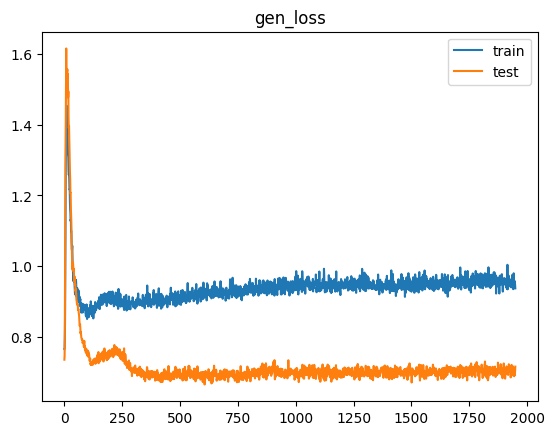

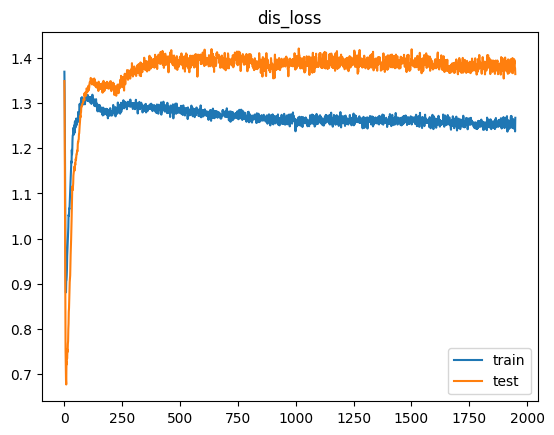

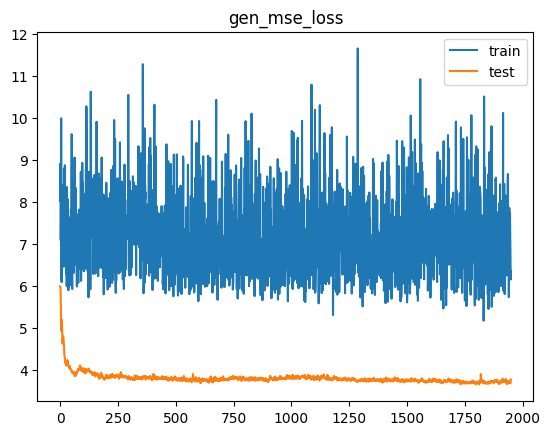

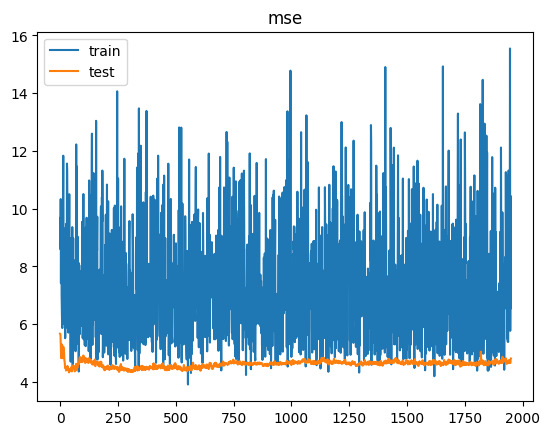

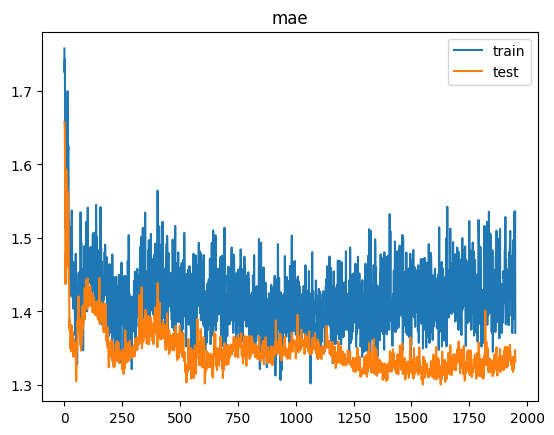

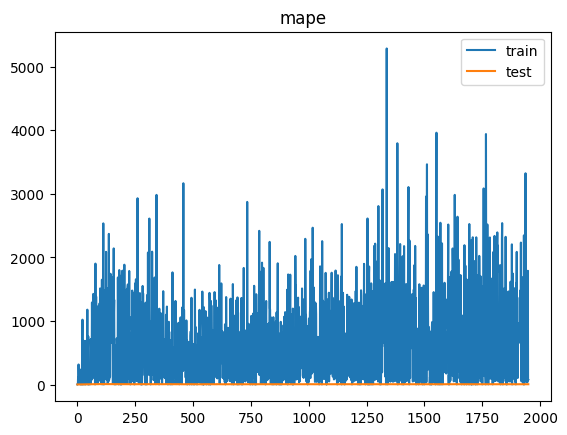

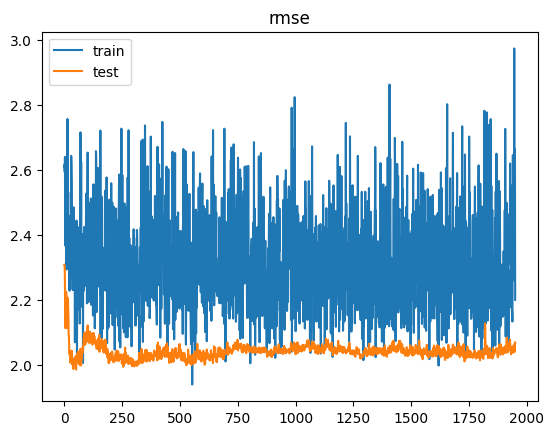

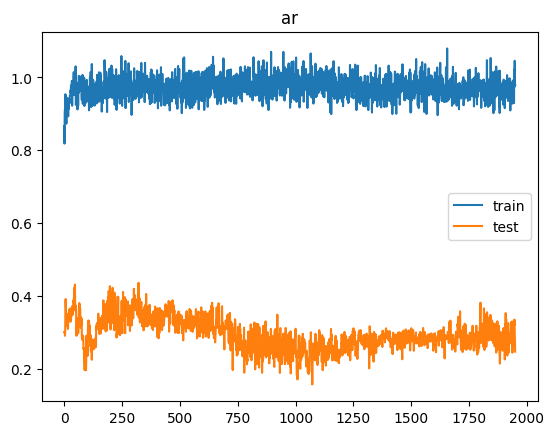

2/2 [==============================] - 0s 3ms/step


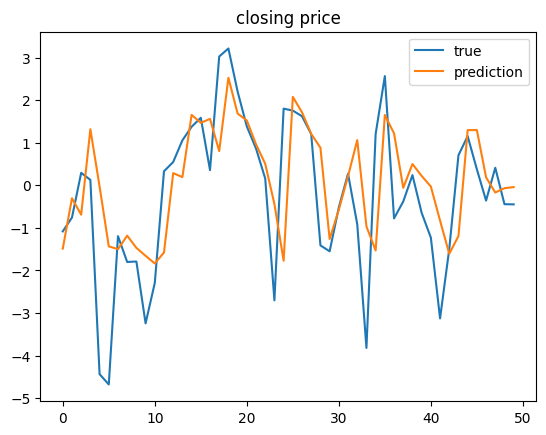

[MSE Baseline] train: 8.272516082500465  test: 4.203018036962421
Delta time with epochs = 1950: 0:25:45.620107


In [21]:
for epochs in [1700, 1950]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("gru_ffnn_epochs_{0}.h5".format(epochs))